In [1]:
#Import libraries

import rdkit 
from rdkit import Chem
import re
from rdkit.Chem.rdchem import *
from rdkit.Chem.rdmolops import *

from collections import Counter
from pyparsing import *
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import rdMolDraw2D
import copy
from time import sleep
from itertools import chain
from pyparsing import *
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
from rdkit.Chem import Descriptors

from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM

from subprocess import check_call
import subprocess
import os
import copy
import seaborn as sns

import pandas as pd
from json import loads,dumps
from rdkit import Chem, DataStructs
from rdkit.Chem.rdMolDescriptors import GetHashedAtomPairFingerprintAsBitVect
import numpy as np
from sklearn.metrics import *
import xgboost as xgb
import seaborn as sns
import random
from rdkit.Chem import Draw
from mordred import Calculator, descriptors
from tqdm import tqdm

from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

from rdkit.Chem import AllChem
import copy

from itertools import chain
import os

from molmass import Formula as molmassFormula


#from rdkit.Chem.rdchem import GetAtomWithIdx

In [2]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Function for producing unique values fo the list.
# Fastest way to uniqify a list in Python

def f5(seq, idfun=None): 
   # order preserving
   if idfun is None:
       def idfun(x): return x
   seen = {}
   result = []
   for item in seq:
       marker = idfun(item)
       # in old Python versions:
       # if seen.has_key(marker)
       # but in new ones:
       if marker in seen: continue
       seen[marker] = 1
       result.append(item)
   return result

In [4]:
# Calculate molecular mass from formula

def get_mass(formula):

    parts = re.findall("[A-Z][a-z]?|[0-9]+", formula)
    mass = 0

    for index in range(len(parts)):
        if parts[index].isnumeric():
            continue

        atom = Chem.Atom(parts[index])
        multiplier = int(parts[index + 1]) if len(parts) > index + 1 and parts[index + 1].isnumeric() else 1
        mass += atom.GetMass() * multiplier

    return mass

In [5]:
# Function to parse molecular formula

def parse_formula(formula):
    elements = [(1, "H"),(2, "He"),(3, "Li"),(4, "Be"),(5, "B"),(6, "C"),(7, "N"),(8, "O"),(9, "F"),(10, "Ne"),(11, "Na"),(12, "Mg"),(13, "Al"),(14, "Si"),(15, "P"),(16, "S"),(17, "Cl"),(18, "Ar"),(19, "K"),(20, "Ca"),(21, "Sc"),(22, "Ti"),(23, "V"),(24, "Cr"),(25, "Mn"),(26, "Fe"),(27, "Co"),(28, "Ni"),(29, "Cu"),(30, "Zn"),(31, "Ga"),(32, "Ge"),(33, "As"),(34, "Se"),(35, "Br"),(36, "Kr"),(37, "Rb"),(38, "Sr"),(39, "Y"),(40, "Zr"),(41, "Nb"),(42, "Mo"),(43, "Tc"),(44, "Ru"),(45, "Rh"),(46, "Pd"),(47, "Ag"),(48, "Cd"),(49, "In"),(50, "Sn"),(51, "Sb"),(52, "Te"),(53, "I"),(54, "Xe"),(55, "Cs"),(56, "Ba"),(57, "La"),(58, "Ce"),(59, "Pr"),(60, "Nd"),(61, "Pm"),(62, "Sm"),(63, "Eu"),(64, "Gd"),(65, "Tb"),(66, "Dy"),(67, "Ho"),(68, "Er"),(69, "Tm"),(70, "Yb"),(71, "Lu"),(72, "Hf"),(73, "Ta"),(74, "W"),(75, "Re"),(76, "Os"),(77, "Ir"),(78, "Pt"),(79, "Au"),(80, "Hg"),(81, "Tl"),(82, "Pb"),(83, "Bi"),(84, "Po"),(85, "At"),(86, "Rn"),(87, "Fr"),(88, "Ra"),(89, "Ac"),(90, "Th"),(91, "Pa"),(92, "U"),(93, "Np"),(94, "Pu"),(95, "Am"),(96, "Cm"),(97, "Bk"),(98, "Cf"),(99, "Es"),(100, "Fm"),(101, "Md"),(102, "No"),(103, "Lr"),(104, "Rf"),(105, "Db"),(106, "Sg"),(107, "Bh"),(108, "Hs"),(109, "Mt"),(110, "Ds"),(111, "Rg"),(112, "Cn"),(113, "Uut"),(114, "Uuq"),(115, "Uup"),(116, "Uuh"),(118, "Uuo")]
    el_list = sorted(list(zip(*elements))[1],key=lambda x:len(x),reverse=True)
    el = Or([Word(x) for x in el_list])
    isotop = el ^ Group(Suppress("[") + OneOrMore(Word(nums)) + el + Suppress("]")).setParseAction(lambda str, location, tokens: "".join(tokens[0]))
    parser = OneOrMore(Group(isotop + ZeroOrMore(Word(nums))))
    parsed = parser.parseString(formula)
    res = set()
    for p in parsed:
        if p[0] =='H': continue
        if len(p) == 2:
            res.add((p[0],int(p[1])))
        else:
            res.add((p[0],1))
    return res

In [6]:
# Calculate fragments
# Main function. Unumerates all paths on mlecular graph and select only those with correct brutto-formula

def calc_fragments(mol,target_with_d,check_one_molecule_rule=False, parent_indexes_condition=False):
    rdDepictor.Compute2DCoords(mol)
    target_mol = copy.deepcopy(mol)
    
    # Remove deuterium
    target=set()
    for idx in target_with_d:
        if idx[0]!='2H':
            target.add(idx)
    #????????????????
    target=target_with_d
    
    # if input fragment contains only 1 atom
    
    if len(target)==1:
        if list(target)[0][1]==1:
            print(1212)
            Single_Atoms_list=[]
            for a in range(len(mol.GetAtoms())):
                atom_s=mol.GetAtomWithIdx(a).GetSymbol()
                atom_pi=mol.GetAtomWithIdx(a).GetProp('pi')
                if (atom_s==list(target)[0][0]):
                    if parent_indexes_condition==True:
                        Single_Atoms_list.append(frozenset({atom_pi}))
                    if parent_indexes_condition==False:
                        Single_Atoms_list.append(frozenset({a}))
            return(Single_Atoms_list)
    
    # if input fragment contain >1 atoms
    
    N = sum([v for (_,v) in target])
    M = N -1
    
    # It works for bonds! Not for atoms!!
    Min_value=N-2
    if(Min_value<0):
        Min_value=0
    
    frags = rdkit.Chem.rdmolops.FindAllSubgraphsOfLengthMToN(target_mol,Min_value,N+3, True) #it was M, N+1
    frags = chain.from_iterable(frags)
    
    # Finding atoms connected to found bonds
    indexes = set()
    indexes_list=[]
    All_Atoms_list=set()
    All_Atoms_list_list=[]
    for fragment in frags:
        bonds = [mol.GetBondWithIdx(idx) for idx in fragment]
        idxs = set()
        atoms = []
        Atoms_list=set()

        for bond in bonds:
            begin = bond.GetBeginAtom()
            end   = bond.GetEndAtom()

            if begin.GetIdx() not in idxs:
                idxs.add(begin.GetIdx())
                Atoms_list.add(begin)
                if begin.GetIsotope() != 0:
                    atoms.append(str(begin.GetIsotope()) + begin.GetSymbol())
                else:    
                    atoms.append(begin.GetSymbol())                    

            if end.GetIdx() not in idxs:
                idxs.add(end.GetIdx())
                Atoms_list.add(end)
                if end.GetIsotope() != 0:
                    atoms.append(str(end.GetIsotope()) + end.GetSymbol())     
                else:    
                    atoms.append(end.GetSymbol())
          
        atom_set = frozenset(Counter(atoms).items()) #sorted(set(Counter(atoms).items()),key=lambda x: x[0])        
       
        if (parent_indexes_condition==True):
            #parent_indexes=set(int(idx.GetProp('pi')) for idx in Atoms_list)
            parent_indexes=set(int(target_mol.GetAtomWithIdx(idx).GetProp("pi")) for idx in idxs)
            
        
        if (atom_set == target):

            indexes.add(frozenset(idxs))
            indexes_list.append(frozenset(idxs))
            if (parent_indexes_condition==True):
                All_Atoms_list.add(frozenset(parent_indexes))
                All_Atoms_list_list.append(frozenset(parent_indexes))
                #print(idxs)
                #print(parent_indexes)
            
    if (parent_indexes_condition==True):        
        return f5(All_Atoms_list_list)
    else:
        return f5(indexes_list)
       

In [7]:
# Calculate the number of fragments remaining in the molecule after removing selected atoms

def validate_connectivity(mol,idxs, parent_indexes_condition=False):
    edit_mol = Chem.RWMol(mol)
    if (parent_indexes_condition==False):
        for idx in sorted(list(idxs), reverse=True):
            edit_mol.RemoveAtom(idx)    
        return len(GetMolFrags(edit_mol)) #GetMolFrags(edit_mol) #
    if (parent_indexes_condition==True):
        
        mol_pi_list=[int(edit_mol.GetAtomWithIdx(idx).GetProp("pi")) for idx in range(len(edit_mol.GetAtoms()))]
        fragments_local_i=[mol_pi_list.index(idx) for idx in frag]
        for idx1 in sorted(list(fragments_local_i),reverse=True):
            edit_mol.RemoveAtom(idx1)
        return len(GetMolFrags(edit_mol))

In [8]:
# Function to get molecular weigth of the selected fragment of the molecule. M/z can be calculated using RDKit functions
# or taken from input Fragment_data

def get_mw_elem_of_fr(Parent_mol,highlight, TakeMzFromInput=False,Fragment_data=pd.DataFrame({"formula":["C9H9O4"], "mz":[181.0495],"formulaNoH":["C9O4"]})):
    edit_mol = Chem.RWMol(Parent_mol)
    Remaining_mol=set([i for i in range(len(edit_mol.GetAtoms()))])-highlight
    for idx in sorted(list(Remaining_mol), reverse=True):
        edit_mol.RemoveAtom(idx) 
    elem_formula=rdMolDescriptors.CalcMolFormula(edit_mol,True)
    mol_weight=round(Descriptors.ExactMolWt(edit_mol),5)
    mol_weight_from_formula=get_mass(elem_formula)
    mol_weight_from_formula=molmassFormula(elem_formula).isotope.mass
    
    elem_formula_from_input='C0'
    if TakeMzFromInput==True:
        elem_formula_NoH=re.sub("H\d*", "", elem_formula)
        mol_weight_1=Fragment_data[Fragment_data["formulaNoH"]==elem_formula_NoH]["mz"]
        elem_formula_from_input=Fragment_data[Fragment_data["formulaNoH"]==elem_formula_NoH]["formula"]
        
        if (mol_weight_1.empty==False):
            mol_weight=float(mol_weight_1.iat[0])
            elem_formula_from_input=elem_formula_from_input.iat[0]
        else:
            mol_weight=0
            elem_formula_from_input='C1'
        
    return ([mol_weight,elem_formula,mol_weight_from_formula,elem_formula_from_input]) #GetMolFrags(edit_mol) #
    

In [9]:
# Function to get intensity of fragment from input Fragment_data

def get_intensity_of_frag(elem_formula_NoH, TakeMzFromInput=False,DropIsotopes=False,Fragment_data=pd.DataFrame({"formula":["C9H9O4"], "mz":[181.0495],"Intensity":[90],"formulaNoH":["C9O4"]})):
    
    Intensity=100
    
    if DropIsotopes==True:
        elem_formula_NoH_1=re.sub(r'(\[\d*)','',elem_formula_NoH)
        elem_formula_NoH_2=re.sub(r'\]','',elem_formula_NoH_1)
        elem_formula_NoH=molmassFormula(elem_formula_NoH_2).formula
        print(elem_formula_NoH)
            
    if TakeMzFromInput==True:
        Intensity_1=Fragment_data[Fragment_data["formulaNoH"]==elem_formula_NoH]["Intensity"]
        if (Intensity_1.empty==False):
            Intensity=float(Intensity_1.iat[0])
        else:
            Intensity=1
        
    return (Intensity) 

In [10]:
# Creates an SVG file to be drawn. 

def Gererate_SVG (Parent_mol,legend='',highlight=frozenset({}),Fragment_data=pd.DataFrame({"formula":["C9H9O4"], "mz":[181.0495],"Intensity":[90],"formulaNoH":["C9O4"]})):
    size_x=450 
    size_y=150
    
    elem_formula=get_mw_elem_of_fr(Parent_mol,highlight)[1]
    mol_weight=get_mw_elem_of_fr(Parent_mol,highlight,True,Fragment_data)[0]
    
    elem_formula=get_mw_elem_of_fr(Parent_mol,highlight)[1]
    mol_weight=get_mw_elem_of_fr(Parent_mol,highlight,True,Fragment_data)[0]
    mol_weight_from_formula=get_mw_elem_of_fr(Parent_mol,highlight)[2]
    elem_formula_from_input=get_mw_elem_of_fr(Parent_mol,highlight,True,Fragment_data)[3]
    
    # Draw
    try:
        mc_mol = rdMolDraw2D.PrepareMolForDrawing(Parent_mol, kekulize=True)
    except ValueError: # <- can happen on a kekulization failure
        mc_mol = rdMolDraw2D.PrepareMolForDrawing(Parent_mol, kekulize=False) #edit_mol
    try:
        Chem.SanitizeMol(mc_mol)

        drawer = rdMolDraw2D.MolDraw2DSVG(size_x, size_y)     
        #drawer.DrawMolecule(mc_mol,legend=legend+"; m="+str(mol_weight)+"; "+elem_formula,highlightAtoms=highlight)

        drawer.DrawMolecule(mc_mol,legend=legend+"; "+str(round(mol_weight,2))+";"+str(elem_formula_from_input)+" / "+str(round(mol_weight_from_formula,2))+";"+str(elem_formula) ,highlightAtoms=highlight)


        #drawer.DrawMolecule(mc_mol,legend=str(fragment_index))
        drawer.FinishDrawing()
        svg = drawer.GetDrawingText()
        return(svg)
    except AtomKekulizeException:
        print("!!!!! CAN'T DROW AtomKekulizeException !!!!!!")
        return(False)
    
    except KekulizeException:
        print("!!!!! CAN'T DROW KekulizeException !!!!!!")
        return(False)

In [11]:
###########################################################################
# Check the correctness of the input data
#
###########################################################################
def Check_input_data (Fragment_data):

    for index in range(len(Fragment_data)):
        mass=round(get_mass(Fragment_data.iloc[index]['formula']),3)
        mass_ini=round(Fragment_data.iloc[index]['mz'],3)
        Check_fragment=""
        if abs(mass_ini-mass)>1:
            Check_fragment="!!!!!!!!!!!CHECK FRAGMENT!!!!!!!!!!!!"

        print(Fragment_data.iloc[index]['formula'],mass_ini,mass,mass_ini-mass,Check_fragment)


In [12]:
# Generate all possible fragments of molecule for given input and sorting according to the filtration rule.

def Generate_all_fragments (mol,Fragment_data):


    All_Fragments=[]
    For_order=pd.DataFrame()
    fragment_formula_index=0
    fragment_index=0

    for fragment_formula in Fragment_data["formula"]:
        target = parse_formula(fragment_formula)#{('C',11),('O',1)}
        fragments = calc_fragments(mol,target,False)
        All_Fragments=All_Fragments + (list(fragments))
        Mz=Fragment_data["mz"][fragment_formula_index]
        fragment_formula_index=fragment_formula_index+1

        for fragment in fragments:

            Nummber_of_remaining_fragments = validate_connectivity(mol,fragment)     

            Bonds_between_fr_and_restofmol=0
            Remaining_mol=set([i for i in range(len(mol.GetAtoms()))])-fragment
            for fr_atom in fragment:
                for mol_atom in Remaining_mol:
                    bond=mol.GetBondBetweenAtoms(fr_atom,mol_atom)
                    if bond !=None:
                        Bonds_between_fr_and_restofmol=Bonds_between_fr_and_restofmol+1
                    #print(fr_atom,mol_atom,bond)

            For_order=For_order.append(pd.DataFrame({'nr':[Nummber_of_remaining_fragments],'fi':[fragment_index],'elem':[fragment_formula],'mz':[Mz],'bb':Bonds_between_fr_and_restofmol}),ignore_index=True)
            fragment_index=fragment_index+1

    For_order=For_order.sort_values(by=['nr','bb'])

    # Restoring row indexing to normal. Without it it will remain the same even after sorting!!!!
    For_order = For_order.reset_index(drop=True)
    Ordered_fragments=list( All_Fragments[i] for i in For_order['fi'] )
    
    return ([For_order,Ordered_fragments])


In [13]:
# Draw fragments

def Draw_fragments(mol, For_order, Ordered_fragments):

    fragment_index=0
    for fragment in Ordered_fragments:

        AllChem.Compute2DCoords(mol)
        try:
            mol.GetAtomWithIdx(0).GetExplicitValence()
        except RuntimeError:
            mol.UpdatePropertyCache(False)
        try:
            mc_mol = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize=True)
        except ValueError: # <- can happen on a kekulization failure
            mc_mol = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize=False)
        drawer = rdMolDraw2D.MolDraw2DSVG(size_x, size_y)

        opts = drawer.drawOptions()

        for i in range(mol.GetNumAtoms()):
            if mol.GetAtomWithIdx(i).GetIsotope()!=0:
                opts.atomLabels[i] = str(mol.GetAtomWithIdx(i).GetIsotope())+mol.GetAtomWithIdx(i).GetSymbol()+str(i)
            else:
                opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol()+str(i)



        drawer.DrawMolecule(mc_mol,highlightAtoms=fragment,legend=str(fragment_index)+'; m/z='+str(For_order['mz'][fragment_index])+"; nr="+str(For_order['nr'][fragment_index]) + "; b="+str(For_order['bb'][fragment_index])+ "                                          ")

        #drawer.DrawMolecule(mc_mol,legend=str(fragment_index))
        drawer.FinishDrawing()
        svg = drawer.GetDrawingText()
        display(SVG(svg))
        fragment_index=fragment_index+1
    

In [14]:
###################################################################
# Work Here!!!
#
####################################################################
# New approach. Calculating fragments and creating 2D list of mol objects
# Generating fragmentation graph as dictionary
# New attempt
#
#
#####################################################################

def Calculate_fragmentation_tree (Parent_mol,Number_of_levels,Fragment_data, Breaking_bonds_max, Remaining_fragments_max):

    # Define fragmentation graph
    Fragmentation_graph={Parent_mol:[]}

    # Store atom indexes in fragmentation graph. Both keys and values
    Parent_mol_set=frozenset(int(i.GetProp("pi")) for i in Parent_mol.GetAtoms())

    ###############################################################
    # Comment here to run loops!!!!!!!

    Fragmentation_graph_sets={Parent_mol_set: []}

    Fragmentation_graph_sets_edge={Parent_mol_set: []}

    ###############################################################

    level=0
    while level <= Number_of_levels:
        level=level+1
        # Get all parent fragments
        Parent_fragments=list(Fragmentation_graph.keys())+list(Fragmentation_graph.values())[0]
        #Parent_fragments_set=list(Fragmentation_graph_sets.values())[0]
        #Parent_fragments_set.add(list(Fragmentation_graph_sets.keys())[0])

        Parent_fragments_set={(list(Fragmentation_graph_sets.keys())[0])}
        Parent_fragments_set=Parent_fragments_set.union(set(chain.from_iterable(Fragmentation_graph_sets.values())))

        #for mol in Parent_fragments:

        for mol_pi in Parent_fragments_set:
            ###############
            Remaining_mol=set([i for i in range(len(Parent_mol.GetAtoms()))])-mol_pi
            ################
            mol = Chem.RWMol(Parent_mol)
            for idx in sorted(list(Remaining_mol), reverse=True):
                mol.RemoveAtom(idx)

            Fragment_structure_list=[]
            Fragment_structure_list_pi=[]
            Fragment_structure_list_pi_edge=[]

            fragment_formula_index=0

            for fragment_formula in Fragment_data["formula"]:
                target = parse_formula(fragment_formula)#{('C',11),('O',1)}
                fragments = calc_fragments(mol,target,False)
                fragments_pi = calc_fragments(mol,target,False,True)

                if fragments !=[]: 
                    Mz=Fragment_data['mz'][fragment_formula_index]


                    For_order=pd.DataFrame()
                    fragment_index=0


                    for fragment in fragments:

                        Nummber_of_remaining_fragments = validate_connectivity(mol,fragment)     

                        Bonds_between_fr_and_restofmol=0
                        total_breaking_bonds_energy=0
                        Remaining_mol=set([i for i in range(len(mol.GetAtoms()))])-fragment
                        for fr_atom in fragment:
                            for mol_atom in Remaining_mol:
                                bond=mol.GetBondBetweenAtoms(fr_atom,mol_atom)
                                if bond !=None:
                                    Bonds_between_fr_and_restofmol=Bonds_between_fr_and_restofmol+1
                                    total_breaking_bonds_energy=total_breaking_bonds_energy+float(bond.GetProp('e'))
                            #print(fr_atom,mol_atom,bond)
                        print(total_breaking_bonds_energy)
                        For_order=For_order.append(pd.DataFrame({'nr':[Nummber_of_remaining_fragments],'fi':[fragment_index],'elem':[fragment_formula],'mz':[Mz],'bb':Bonds_between_fr_and_restofmol,'e':total_breaking_bonds_energy}),ignore_index=True)
                        fragment_index=fragment_index+1

                    For_order=For_order.sort_values(by=['nr','bb'])

                    # Restoring row indexing to normal. Without it it will remain the same even after sorting!!!!
                    For_order = For_order.reset_index(drop=True)
                    Ordered_fragments=list( list(fragments)[i] for i in For_order['fi'] )

                    # Condition to filter real fragments
                    # If working with deuterium this should be incresased by to 4 and 3 respectively!!!!
                    # Without deuterium I used 3 and 2
                    #
                    #Possible_Candidates=For_order[(For_order['bb']<3) & (For_order['nr']<2)]   #4 and 3            
                    Possible_Candidates=For_order[(For_order['nr']==For_order.iloc[0]['nr']) & (For_order['bb']==For_order.iloc[0]['bb'])]
                    Possible_Candidates=Possible_Candidates[(Possible_Candidates['bb']<Breaking_bonds_max) & (Possible_Candidates['nr']<Remaining_fragments_max)]
                    #
                    ##################################

                    Possible_fragments=list( list(fragments)[i] for i in Possible_Candidates['fi'] )
                    Possible_fragments_pi=list( list(fragments_pi)[i] for i in Possible_Candidates['fi'] )
                    Possible_fragments_pi_edge=[[int(For_order[For_order["fi"]==i]["nr"]),int(For_order[For_order["fi"]==i]["bb"]),float(For_order[For_order["fi"]==i]['e']),str(For_order[For_order["fi"]==i]['elem'].iat[0])] for i in For_order["fi"]]


                    if (Possible_fragments!=[]):
                        print("Parent fragment "+str(mol_pi))
                        print("Generated fragment. Current indexes" + str(Possible_fragments))

                        print("Generated fragment. Parrent indexes" + str(Possible_fragments_pi))

                    for selected_fragment_index in range(len(Possible_fragments)):
                        selected_fragment = Possible_fragments[selected_fragment_index] 

                        Remaining_mol=set([i for i in range(len(mol.GetAtoms()))])-selected_fragment
                        edit_mol = Chem.RWMol(mol)
                        for idx in sorted(list(Remaining_mol), reverse=True):
                            edit_mol.RemoveAtom(idx) 

                        Fragment_structure_list.append(edit_mol)
                        Fragment_structure_list_pi.append(Possible_fragments_pi[selected_fragment_index])
                        Fragment_structure_list_pi_edge.append(Possible_fragments_pi_edge[selected_fragment_index])

                        # Draw
                        svg=Gererate_SVG(mol,str(Mz),selected_fragment)
                        if svg!=False:
                            display(SVG(svg))                   

                    Fragmentation_graph[mol]=Fragment_structure_list                  #
                    Fragmentation_graph_sets[mol_pi]=Fragment_structure_list_pi       #
                    Fragmentation_graph_sets_edge[mol_pi]=Fragment_structure_list_pi_edge

                    print(Fragmentation_graph_sets)
                fragment_formula_index=fragment_formula_index+1
    
    for parent in Fragmentation_graph_sets.copy():
        for frag in Fragmentation_graph_sets[parent]:
            frag_index_in_Fragmentation_graph_sets=Fragmentation_graph_sets[parent].index(frag) 
            print(parent,frag,frag_index_in_Fragmentation_graph_sets)
            if (frag==parent):
                Fragmentation_graph_sets[parent].remove(frag)
                Fragmentation_graph_sets_edge[parent].remove(Fragmentation_graph_sets_edge[parent][frag_index_in_Fragmentation_graph_sets])
                
    return(Fragmentation_graph_sets,Fragmentation_graph_sets_edge)

In [15]:
################################################################################################
# Draw generated fragmentatoin graph
#
#
#
################################################################################################

def Draw_tree (Parent_mol,Fragment_data,Fragmentation_graph_sets,Fragmentation_graph_sets_edge,path_to_pictures,Number_of_levels=2,Normalized_collision_Energy="40",DropIsotopes=False):

    parent_index=0
    fragment_index=0

    Unique_Fragments=[]
    All_Nodes_description=[]
    All_Edges_description=[]

    Fragments_Id=pd.DataFrame()
    fragment_id=0

    All_Nodes_description_Id=[]
    All_Edges_description_Id=[]

    for parent in Fragmentation_graph_sets:
        print("Displaying parent structure " + str(parent))
        print("Fragmentation_graph_sets_edge"+str(Fragmentation_graph_sets_edge[parent]))
        parent_Colors={a: (0,1,0) for a in parent}

        Node_Name_P=list(parent)
        Node_Name_P=' '.join(map(str,Node_Name_P))
        Node_Name_P = Node_Name_P.replace(" ","a")

        if parent not in Unique_Fragments:
            print("dddddddddddddddd")
            Unique_Fragments.append(parent)
            elem_formula=get_mw_elem_of_fr(Parent_mol,parent)[1]
            mol_weight=get_mw_elem_of_fr(Parent_mol,parent,True,Fragment_data)[0]
            mol_weight_from_formula=get_mw_elem_of_fr(Parent_mol,parent)[2]
            elem_formula_from_input=get_mw_elem_of_fr(Parent_mol,parent,True,Fragment_data)[3]
            
            if (mol_weight==0):
                print("!!!!!! mol_weight=0")
                
            formulaNoH=re.sub("H\d*", "", elem_formula)
            frag_intensity=get_intensity_of_frag(formulaNoH,True,DropIsotopes=DropIsotopes,Fragment_data=Fragment_data)

            Fragments_Id=Fragments_Id.append(pd.DataFrame({'atom_set':[parent],'name':[Node_Name_P],'fi':[str(fragment_id)],"formula":[elem_formula],"mz":[mol_weight],"formulaNoH":[formulaNoH],"frag_intensity":[frag_intensity],"mol_weight_from_formula":[mol_weight_from_formula],"elem_formula_from_input":[elem_formula_from_input]}),ignore_index=True)
            fragment_id=fragment_id+1

            Node_description=Node_Name_P+" [label=\"\",image=\""+path_to_pictures+"Fig\\"+Node_Name_P+".png"+"\",labelloc=b];"
            All_Nodes_description.append(Node_description)

            node_id_P=Fragments_Id[Fragments_Id['atom_set']==parent]['fi'].iat[0]
            Node_description_id=node_id_P+" [label=\"\",image=\""+path_to_pictures+"Fig\\"+Node_Name_P+".png"+"\",labelloc=b, penwidth="+str((Fragments_Id[Fragments_Id['atom_set']==parent]['frag_intensity'].iat[0])/10)+"];"

            All_Nodes_description_Id.append(Node_description_id)

            svg=Gererate_SVG(Parent_mol,str(node_id_P),parent,Fragment_data)
            #write svg picture to file
            file_name=path_to_pictures+"Fig\\"+Node_Name_P
            with open (file_name+".svg",'w') as f:
                f.write(svg)

            drawing = svg2rlg(file_name +".svg")
            renderPM.drawToFile(drawing, file_name+".png",fmt="PNG")

        else:
            node_id_P=Fragments_Id[Fragments_Id['atom_set']==parent]['fi'].iat[0]

        fragment_index=0

        svg=Gererate_SVG(Parent_mol,str(node_id_P),parent,Fragment_data)
        display(SVG(svg))

        for frag in Fragmentation_graph_sets[parent]:
            print("Displaying fragments " + str(frag))

            frag_index_in_Fragmentation_graph_sets=Fragmentation_graph_sets[parent].index(frag) 

            Node_Name_F=list(frag)
            Node_Name_F=' '.join(map(str,Node_Name_F))
            Node_Name_F = Node_Name_F.replace(" ","a")

            if frag not in Unique_Fragments:
                print("dddddddddddddddd")
                Unique_Fragments.append(frag)
                elem_formula=get_mw_elem_of_fr(Parent_mol,frag)[1]
                mol_weight=get_mw_elem_of_fr(Parent_mol,frag,True,Fragment_data)[0]
                mol_weight_from_formula=get_mw_elem_of_fr(Parent_mol,frag)[2]
                elem_formula_from_input=get_mw_elem_of_fr(Parent_mol,frag,True,Fragment_data)[3]
                
                formulaNoH=re.sub("H\d*", "", elem_formula)
                frag_intensity=get_intensity_of_frag(formulaNoH,True,DropIsotopes=DropIsotopes,Fragment_data=Fragment_data)

                Fragments_Id=Fragments_Id.append(pd.DataFrame({'atom_set':[frag],'name':[Node_Name_F],'fi':[str(fragment_id)],"formula":[elem_formula],"mz":[mol_weight],"formulaNoH":[formulaNoH],"frag_intensity":[frag_intensity],"mol_weight_from_formula":[mol_weight_from_formula],"elem_formula_from_input":[elem_formula_from_input]}),ignore_index=True)
                fragment_id=fragment_id+1

                Node_description=Node_Name_F+" [label=\"\",image=\""+path_to_pictures+"Fig\\"+Node_Name_F+".png"+"\",labelloc=b];"
                All_Nodes_description.append(Node_description)

                node_id_F=Fragments_Id[Fragments_Id['atom_set']==frag]['fi'].iat[0]
                Node_description_id=node_id_F+" [label=\"\",image=\""+path_to_pictures+"Fig\\"+Node_Name_F+".png"+"\",labelloc=b, penwidth="+str((Fragments_Id[Fragments_Id['atom_set']==frag]['frag_intensity'].iat[0])/10)+"];"

                All_Nodes_description_Id.append(Node_description_id)

                svg=Gererate_SVG(Parent_mol,str(node_id_F),frag,Fragment_data)
                #write svg picture to file
                file_name=path_to_pictures+"Fig\\"+Node_Name_F
                with open (file_name+".svg",'w') as f:
                    f.write(svg)

                drawing = svg2rlg(file_name +".svg")
                renderPM.drawToFile(drawing, file_name+".png",fmt="PNG")

            else:
                node_id_F=Fragments_Id[Fragments_Id['atom_set']==frag]['fi'].iat[0]

            # Draw
            svg=Gererate_SVG(Parent_mol,str(node_id_F),frag,Fragment_data)
            display(SVG(svg))

            Edge_description=Node_Name_P+" -- "+Node_Name_F+";"
            All_Edges_description.append(Edge_description)

            Edge_description_id=node_id_P+" -- "+node_id_F+"[ label=\""+str(Fragmentation_graph_sets_edge[parent][frag_index_in_Fragmentation_graph_sets])+"\" ];"
            All_Edges_description_Id.append(Edge_description_id)

            fragment_index=fragment_index+1
        parent_index=parent_index+1

    ###########
    # Create NetworX graph
    
    G = ceate_networkX_graph (Fragments_Id,All_Edges_description_Id)
    All_paths=get_paths(G, '0')
    
    if All_paths:
        Achived_depth=max(list(map(len, All_paths)))
    else:
        Achived_depth=0
    ###########
    edges_pairs=[]
    for i in list(Fragmentation_graph_sets_edge.values()):
        edges_pairs=edges_pairs+i

    Ind1=0
    Ind2=0
    Total_energy=0
    k=0
    for edge in edges_pairs:
        if (edge!=[0,0]):
            k=k+1
            Ind1=Ind1+edge[0]
            Ind2=Ind2+edge[1]
            Total_energy=Total_energy+edge[2]

      
    if k>0:
        Breaking_bond_index=round(Ind2/k,3)
        Remaining_fragments_Index=round(Ind1/k,3)     
        print (Ind1/k,Ind2/k,Total_energy)
    else:
        Breaking_bond_index=1
        Remaining_fragments_Index=1

    UsedFragments=len(f5(Fragments_Id['formulaNoH']))/(len(Fragment_data['formulaNoH']))
    print(UsedFragments)
    # Write grap description to file

    f=open(path_to_pictures+'For_Graphviz.txt','w')
    f.write("graph G {"+'\n')

    f.write("label = <"+"Smiles = "+str(Molecular_Smiles)+" ;NCE = "+str(Normalized_collision_Energy)+" ;N_nodes = "+str(len(Fragments_Id))+"; N_edges = "+str(len(edges_pairs))+"; Tree_depth_set = "+str(Number_of_levels)+"; Achived_depth = "+str(Achived_depth)+"; Remaining fragments Index = "+str(Remaining_fragments_Index)+ "; Breaking bond index = " +str(Breaking_bond_index)+ "; Used fragments (%) index = " +str(round(UsedFragments,3))+"; Total Energy = "+str(Total_energy)+ ">;"+'\n')
    
    Index_list={"Molecular_Smiles": Molecular_Smiles,"Normalized_collision_Energy": Normalized_collision_Energy,"N_nodes": len(Fragments_Id),"N_edges":len(edges_pairs),"Tree_depth_set":Number_of_levels,"Achived_depth": Achived_depth,"Remaining_fragments_Index":Remaining_fragments_Index,"Breaking_bond_index":Breaking_bond_index,"UsedFragments": round(UsedFragments,3),"Total_energy":Total_energy}
    
    f.write("labelloc = \"t\";"+'\n')

    ####################################
    # Add table with ions
    f.write("aHtmlTable [shape=plaintext;  label=< <table border='1' cellborder='0'> \n")
    # Add molecular formulas
    f.write("<tr>")
    f.write("<td>"+"FormulaNoH"+"</td>\n")
    for idx in range(len(Fragment_data)):
        f.write("<td>"+Fragment_data.iloc[idx]["formulaNoH"]+"</td>\n")
    
    # Number of peaks
    f.write("<td>"+str(len(Fragment_data['formulaNoH']))+"</td>\n")
    f.write("</tr>\n")
    
    # Add m/z
    f.write("<tr>")
    f.write("<td>"+"m/z"+"</td>\n")
    for idx in range(len(Fragment_data)):
        f.write("<td>"+str(Fragment_data.iloc[idx]["mz"])+"</td>\n")
    
    # Number of peaks    
    f.write("<td>"+str(len(Fragment_data['mz']))+"</td>\n")
    f.write("</tr>\n")
    
    # Add presence
    f.write("<tr>")
    f.write("<td>"+"Presence"+"</td>\n")
    for formulaNoH in Fragment_data['formulaNoH']:
        if formulaNoH in list(Fragments_Id['formulaNoH']):
            f.write("<td>"+"+"+"</td>\n")
        else:
            f.write("<td>"+"-"+"</td>\n")
    # Number of used fragments
    f.write("<td>"+str(len(f5(Fragments_Id['formulaNoH'])))+"</td>\n")
    f.write("</tr>\n")
    
    # Add intensities
    f.write("<tr>")
    f.write("<td>"+"Intensity"+"</td>\n")
    for idx in range(len(Fragment_data)):
        f.write("<td>"+str(Fragment_data.iloc[idx]["Intensity"])+"</td>\n")
    # Number of peaks    
    f.write("<td>"+str(len(Fragment_data['mz']))+"</td>\n")
    f.write("</tr>\n")
    
    # Add edges to
    f.write("<tr>")
    f.write("<td>"+"Edges to"+"</td>\n")
    Total_number_of_edges=0
    for formulaNoH in Fragment_data['formulaNoH']:
        if formulaNoH in list(Fragments_Id['formulaNoH']):
            atom_indexes_list=list(Fragments_Id[Fragments_Id['formulaNoH']==formulaNoH]['atom_set'])
            occurence_total=0
            for atom_indexes in atom_indexes_list:
                print(atom_indexes)
                occurence=sum(value == atom_indexes for value in list(chain.from_iterable(Fragmentation_graph_sets.values())))
                occurence_total=occurence_total+occurence  
            f.write("<td>"+str(occurence_total)+"</td>\n")
            Total_number_of_edges=Total_number_of_edges+occurence_total
        else:
            f.write("<td>"+"-"+"</td>\n")
    
    # Total edges to
    f.write("<td>"+str(Total_number_of_edges)+"</td>\n")
    f.write("</tr>\n")
    
    # Add edges from
    f.write("<tr>")
    f.write("<td>"+"Edges from"+"</td>\n")
    Total_number_of_edges=0
    for formulaNoH in Fragment_data['formulaNoH']:
        if formulaNoH in list(Fragments_Id['formulaNoH']):
            atom_indexes_list=list(Fragments_Id[Fragments_Id['formulaNoH']==formulaNoH]['atom_set'])
            occurence_total=0
            for atom_indexes in atom_indexes_list:
                print(atom_indexes)
                if atom_indexes in Fragmentation_graph_sets.keys():
                    occurence=len(list(Fragmentation_graph_sets[atom_indexes]))
                    occurence_total=occurence_total+occurence  
            f.write("<td>"+str(occurence_total)+"</td>\n")
            Total_number_of_edges=Total_number_of_edges+occurence_total
        else:
            f.write("<td>"+"-"+"</td>\n")

    f.write("<td>"+str(Total_number_of_edges)+"</td>\n")
    f.write("</tr>\n")

    f.write("</table> >]; \n")

    for ele in All_Nodes_description_Id:
        f.write(ele+'\n')
    f.write('\n')
    for ele in All_Edges_description_Id:
        f.write(ele+'\n')

    f.write("}"+'\n')
    f.close()

    with open(path_to_pictures+'Fragmentation_graph_sets.txt', 'w') as f:
        print(Fragmentation_graph_sets, file=f)

    with open(path_to_pictures+'Fragmentation_graph_sets_edge.txt', 'w') as f:
        print(Fragmentation_graph_sets_edge, file=f)

    Fragments_Id.to_csv(path_to_pictures+'Fragments_Id.txt', sep='\t')
    
    return(Fragments_Id,G,Index_list)

In [16]:
def ceate_networkX_graph (Fragments_Id,All_Edges_description_Id):
    edges=set()
    edges_dic={}
    for idx in All_Edges_description_Id :
        edge_idx=tuple(idx.split("[ l")[0].split(" -- "))
        edges.add(edge_idx)

        nr=idx.split("=\"[")[1].split(",")[0]
        bb=idx.split("=\"[")[1].split(",")[1]

        edges_dic[edge_idx]=[nr,bb]

    print(edges)

    G=nx.DiGraph()
    for i in  range(0, len(Fragments_Id)):
        G.add_node(Fragments_Id.fi[i], atom_set=Fragments_Id.atom_set[i],name=Fragments_Id.name[i],fi=Fragments_Id.fi[i],formula=Fragments_Id.formula[i], mz=Fragments_Id.mz[i],formulaNoH=Fragments_Id.formulaNoH[i],
                   frag_intensity=Fragments_Id.frag_intensity[i],mol_weight_from_formula=Fragments_Id.mol_weight_from_formula[i],elem_formula_from_input=Fragments_Id.elem_formula_from_input[i])
    G.add_edges_from(edges)

    for edge in list(G.edges):
        attrs = {edge: {"nr": edges_dic[edge][0],"bb": edges_dic[edge][1]}}
        nx.set_edge_attributes(G, attrs)

    return (G)

In [17]:
####################################################################################
# Ceaning trees
# Copy the generated Fragmentation_graph_sets
# !!!!!! Use deepcopy!!!!!!!!!! Othewise BOTH dict will change!!!!!!!
#
####################################################################################
#Generated_data_backup

def clean_tree_read_file (path):
    Generated_data_backup=copy.deepcopy(Generated_data)

    file1 = open(path+'Fragmentation_graph_sets.txt', 'r') 
    Lines = file1.readline() 
    Fragmentation_graph_sets_read=eval(Lines)

    file1 = open(path+'Fragmentation_graph_sets_edge.txt', 'r') 
    Lines = file1.readline() 
    Fragmentation_graph_sets_edge_read=eval(Lines)

    Fragments_Id_read=pd.read_table(path+'Fragments_Id.txt',delimiter='\t',index_col=0) 
    
    return([Fragmentation_graph_sets_read,Fragmentation_graph_sets_edge_read,Fragments_Id_read])


In [18]:
#########################################################
#
# Remove undesirable fragments
#
#
#########################################################

frarments_to_remove=[2,4]

def clean_tree_remove_fragments(frarments_to_remove,Fragmentation_graph_sets_read,Fragmentation_graph_sets_edge_read,Fragments_Id_read):

    Fragmentation_graph_sets_cleaned=copy.deepcopy(Fragmentation_graph_sets_read)
    Fragmentation_graph_sets_edge_cleaned=copy.deepcopy(Fragmentation_graph_sets_edge_read)

    Fragments_Id_cleaned=Fragments_Id_read

    for i in frarments_to_remove:
        Fragments_Id_cleaned=Fragments_Id_cleaned[i != Fragments_Id_read['fi']]  

    for parent in Fragmentation_graph_sets_cleaned.copy():
        Node_Name_P=list(parent)
        Node_Name_P=' '.join(map(str,Node_Name_P))
        Node_Name_P = Node_Name_P.replace(" ","a")

        if Node_Name_P not in list(Fragments_Id_cleaned['name']):
            Fragmentation_graph_sets_cleaned.pop(parent)
            Fragmentation_graph_sets_edge_cleaned.pop(parent)


        if Node_Name_P in list(Fragments_Id_cleaned['name']):
            for frag in Fragmentation_graph_sets_cleaned[parent].copy():

                Node_Name_F=list(frag)
                Node_Name_F=' '.join(map(str,Node_Name_F))
                Node_Name_F = Node_Name_F.replace(" ","a")

                if Node_Name_F not in list(Fragments_Id_cleaned['name']):
                    Fragmentation_graph_sets_edge_cleaned[parent].pop(Fragmentation_graph_sets_cleaned[parent].index(frag))
                    Fragmentation_graph_sets_cleaned[parent].remove(frag)

    return([Fragmentation_graph_sets_cleaned,Fragmentation_graph_sets_edge_cleaned,Fragments_Id_cleaned])

In [19]:
### This function xreates NetworkX Digraph from tree files
### It takes Nodes info from Fragments_Id.txt, nodes are ID's, while formulas are added as attributes
### It is required to differentiate fragments with different structures in calculated graphs
### Edge tuples are created from For Graphviz.txt
### Self-edges are removed

def parse_graph(path):
    file=open(path+"For_Graphviz.txt", 'r')
    inp=file.readlines()
    i=0
    edges=set()
    while inp[i]!='\n':
        i=i+1
    for j in range(i+1, len(inp)-1):
        inp[j]=inp[j].replace(";\n", "")
        inp[j] = tuple(inp[j].split(" -- "))
        if inp[j][0]!=inp[j][1]: 
            edges.add(inp[j])
    frag=pd.DataFrame()
    frag=pd.read_csv(path+'Fragments_Id.txt', sep='\t', dtype={'fi':str, 'mz':str})
    G=nx.DiGraph()
    for i in  range(0, len(frag)):
        G.add_node(frag.fi[i], formula=frag.formula[i], mz=frag.mz[i])
    G.add_edges_from(edges)
    #plt.subplot(111)
   # nx.draw(G, with_labels=True) 
    a=nx.get_node_attributes(G, 'formula')
    return G

In [20]:
###This function finds all paths on the fragmentation tree by nodes
###Returns formulas instead of nodes to make paths comparable
def get_paths(G, parent):
    nodes=G.nodes()
    formulas=nx.get_node_attributes(G, 'formula')
    mz=nx.get_node_attributes(G, 'mz')
    paths=[]
    for n in nodes:
        for path in nx.all_simple_paths(G, source=parent, target=n):
            path_f=[]
            for node in path:
               path_f.append(mz[node])
                
            paths.append(path_f)
    return paths

In [21]:
def scoring(G1,G2, parent):
    results=pd.DataFrame(index = range(0, len(get_paths(G1, parent))), columns = ['paths','length', 'found'])
    i=0
    g1=get_paths(G1, parent)
    g2=get_paths(G2, parent)
    #print(g1)
    #print(g2)
    for i in range (len(g1)):
        results.paths[i]= g1[i]
        results.length[i]=len(g1[i])
        if g1[i] in g2:
            results.found[i]=True
        else: 
            results.found[i]=False
    return results

In [22]:
def get_node_att(g):
    MZ=nx.get_node_attributes(g, 'mz')
    mz=set()
    for k in  MZ.keys():
        mz.add(MZ[k])
    return(mz)

In [23]:
######################################
#
# Replace labile oxygens for 18 O
#
######################################

def run_16O18O_exchange (mol):

    #Molecular_Smiles="CCCC(C(=O)C1=CC2=C(C=C1)OCO2)N3CCCC3"
    #Molecular_Smiles="CC(=O)CC(C1=CC=CC=C1)C2=C(C3=CC=CC=C3OC2=O)O"
    #Molecular_Smiles="C1=CC=C(C(=C1)C(=O)O)O"
    #mol=Chem.MolFromSmiles(Molecular_Smiles)

    #Carbonyle=  "[CX3]=[OX1]"
    #Carbonyle18=  "[CX3]=[18OX1]"

    Carbonyle=  "[#6]=O"
    Carbonyle18=  "[#6]=[18O]"

    Carboxylic_Acid = "[CX3](=O)[OX2H1]"
    Carboxylic_Acid18 = "[CX3](=[18O])[18OX2H1]"

    carb=Chem.MolFromSmarts(Carbonyle)
    carb18=Chem.MolFromSmarts(Carbonyle18)

    carb_acid=Chem.MolFromSmarts(Carboxylic_Acid)
    carb_acid18=Chem.MolFromSmarts(Carboxylic_Acid18)

    m18_carb=AllChem.ReplaceSubstructs(mol,carb,carb18,replaceAll=True)[0]
    Chem.SanitizeMol(m18_carb)

    m18_carb_carb_acid18=AllChem.ReplaceSubstructs(m18_carb,carb_acid,carb_acid18)[0]
    Chem.SanitizeMol(m18_carb_carb_acid18)

    return (m18_carb_carb_acid18)




In [24]:
def set_bond_energy(mol):
    energies=pd.DataFrame([
    ['C','C',1,368],
    ['C','C',1.5,418],
    ['C','C',2,682],
    ['C','C',3,962],
    ['C','N',1,331],
    ['C','N',1.5,644],
    ['C','N',2,644],
    ['C','N',3,937],
    ['C','O',1,384],
    ['C','O',2,732]],columns =['ba','ea','bt','e'])
    
    energies['set']=[{energies.iloc[idx]['ba'],energies.iloc[idx]['ea']} for idx in range(len(energies))]

    for bond in mol.GetBonds():
        begin=bond.GetBeginAtom()
        end=bond.GetEndAtom()
        bond_type=bond.GetBondTypeAsDouble()
        ba=begin.GetSymbol()
        ea=end.GetSymbol()
        atom_set={ba,ea}

        e1=energies[energies['set']==atom_set]
        e2=e1[e1['bt']==bond_type]
        if (len(e2)==1):
            bond.SetProp('e',str(e2['e'].values[0]))
        else:
            bond.SetProp('e',str(333))


In [25]:
def molecular_formula_from_smiles (smiles_1):

    elements = [(1, "H"),(2, "He"),(3, "Li"),(4, "Be"),(5, "B"),(6, "C","c"),(7, "N"),(8, "O"),(9, "F"),(10, "Ne"),(11, "Na"),(12, "Mg"),(13, "Al"),(14, "Si"),(15, "P"),(16, "S"),(17, "Cl"),(18, "Ar"),(19, "K"),(20, "Ca"),(21, "Sc"),(22, "Ti"),(23, "V"),(24, "Cr"),(25, "Mn"),(26, "Fe"),(27, "Co"),(28, "Ni"),(29, "Cu"),(30, "Zn"),(31, "Ga"),(32, "Ge"),(33, "As"),(34, "Se"),(35, "Br"),(36, "Kr"),(37, "Rb"),(38, "Sr"),(39, "Y"),(40, "Zr"),(41, "Nb"),(42, "Mo"),(43, "Tc"),(44, "Ru"),(45, "Rh"),(46, "Pd"),(47, "Ag"),(48, "Cd"),(49, "In"),(50, "Sn"),(51, "Sb"),(52, "Te"),(53, "I"),(54, "Xe"),(55, "Cs"),(56, "Ba"),(57, "La"),(58, "Ce"),(59, "Pr"),(60, "Nd"),(61, "Pm"),(62, "Sm"),(63, "Eu"),(64, "Gd"),(65, "Tb"),(66, "Dy"),(67, "Ho"),(68, "Er"),(69, "Tm"),(70, "Yb"),(71, "Lu"),(72, "Hf"),(73, "Ta"),(74, "W"),(75, "Re"),(76, "Os"),(77, "Ir"),(78, "Pt"),(79, "Au"),(80, "Hg"),(81, "Tl"),(82, "Pb"),(83, "Bi"),(84, "Po"),(85, "At"),(86, "Rn"),(87, "Fr"),(88, "Ra"),(89, "Ac"),(90, "Th"),(91, "Pa"),(92, "U"),(93, "Np"),(94, "Pu"),(95, "Am"),(96, "Cm"),(97, "Bk"),(98, "Cf"),(99, "Es"),(100, "Fm"),(101, "Md"),(102, "No"),(103, "Lr"),(104, "Rf"),(105, "Db"),(106, "Sg"),(107, "Bh"),(108, "Hs"),(109, "Mt"),(110, "Ds"),(111, "Rg"),(112, "Cn"),(113, "Uut"),(114, "Uuq"),(115, "Uup"),(116, "Uuh"),(118, "Uuo")]

    Formula=""

    for idx in elements:
        idx
        element_list=idx[1:]

        Correct_element_symbol=idx[1]
        Number_of_occurences=0

        for element_symbol in element_list:
            a=re.findall(element_symbol,smiles_1)
            if a!=[]:
                #print(element_symbol+str(len(a)))
                Number_of_occurences=Number_of_occurences+len(a)
        if Number_of_occurences!=0:
            if Number_of_occurences>1:
                Formula=Formula+str(Correct_element_symbol)+str(Number_of_occurences)
            if Number_of_occurences==1:
                Formula=Formula+str(Correct_element_symbol)
            #print(Formula)
    return(Formula)

In [26]:
def get_fp(mol,atoms,total_len=1024):
    fp = GetHashedAtomPairFingerprintAsBitVect(mol,maxLength=6, fromAtoms=atoms)
    arr = np.zeros(1,)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

morded_calculator = Calculator(descriptors, ignore_3D=False)
def morded(mol): return np.array([list(morded_calculator(mol)
                                      .fill_missing(value=0.)
                                      .values())])\
    .astype(np.float32)



def mapAtomToInternalNumbers(mol):
    res = {}
    for atom in mol.GetAtoms():
        res[int(atom.GetProp("molAtomMapNumber"))] = atom.GetIdx()
    return res    



In [27]:
def check_bond_break(to_process):
    mols_to_draw  = []
    global_bonds  = []
    for i,(smiles,bonds) in enumerate(to_process):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            bonds_to_draw = []
            mapping = mapAtomToInternalNumbers(mol)
            bonds = frozenset([frozenset(mapping[int(b)] for b in bond) for bond in bonds])
            for bond in mol.GetBonds():
                a1 = bond.GetBeginAtom().GetIdx()
                a2 = bond.GetEndAtom().GetIdx()
                #x_fp = get_fp(mol,atoms=[a1,a2])
                if frozenset([a1,a2]) in bonds:
                    #print("1")
                    bonds_to_draw.append(bond.GetIdx())
                    #d = rdMolDraw2D.MolDraw2DSVG(500, 500)
                    #rdMolDraw2D.PrepareAndDrawMolecule(d, mol,highlightBonds=bonds_to_draw)
            mols_to_draw.append(mol)
            global_bonds.append(bonds_to_draw)
    print(len(mols_to_draw))
    return Chem.Draw.MolsToGridImage(mols_to_draw,molsPerRow=3,subImgSize=(500, 500),highlightBondLists=global_bonds)   

In [28]:
def calc_descriptors(data,with_global=True):
    X = []
    y = []
    for i,(smiles,bonds) in tqdm(enumerate([(k,v) for k,v in data.items()])):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mapping = mapAtomToInternalNumbers(mol)
            bonds = frozenset([frozenset(mapping[int(b)] for b in bond) for bond in bonds])
            mol_fp = morded(mol)[0]
            for bond in mol.GetBonds():
                a1 = bond.GetBeginAtom().GetIdx()
                a2 = bond.GetEndAtom().GetIdx()
                atom_fp = get_fp(mol,atoms=[a1,a2])
                if frozenset([a1,a2]) in bonds:
                    y_ = 1
                    #print("here! {} {}".format(frozenset([a1,a2]),bonds))
                else:
                    y_ = 0
                    #print("NOT here! {} {}".format(frozenset([a1,a2]),bonds))
                fp = np.hstack((atom_fp,mol_fp)) if with_global else atom_fp    
                X.append(fp)
                y.append(y_)
    return (X,y)  

In [29]:
def predict_for_a_molecule(mol):
    bonds_to_draw = []
    mol_fp =  morded(mol)[0]
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        x_fp = [get_fp(mol,atoms=[a1,a2])]
      
        x_fp=np.asmatrix(x_fp)
        
        prob = float(model.predict(xgb.DMatrix(x_fp)))
       # print(prob)
        res = 1 if prob > 0.5 else 0
        bond.SetProp('bondNote', "{:02.2f}".format(prob))
        if res == 1:
            bonds_to_draw.append(bond.GetIdx())
    return (mol)        
        #print(res)

In [30]:
################################################################################################
# Draw generated fragmentatoin graph for predicted data
#
# 
#
################################################################################################

#Number_of_levels=2
#Normalized_collision_Energy="40"
#Fragment_data=pd.DataFrame({"formula":["C9H9O4"], "mz":[181.0495],"formulaNoH":["C9O4"],"Intensity":[1]})
#Unify=False

def Draw_tree_for_predicted (Parent_mol,Fragment_data,Fragmentation_graph_sets_btobraek,path_to_pictures,Number_of_levels,Unify=False,Normalized_collision_Energy="40"):

    parent_index=0
    fragment_index=0

    Unique_Fragments=[]
    All_Nodes_description=[]
    All_Edges_description=[]

    Fragments_Id=pd.DataFrame()
    fragment_id=0

    All_Nodes_description_Id=[]
    All_Edges_description_Id=[]

    for parent_i in Fragmentation_graph_sets_btobraek:

        if Unify:
            parent=copy.deepcopy(parent_i[0])
        else:
            parent=copy.deepcopy(parent_i)


        print("Displaying parent structure " + str(parent))
        parent_Colors={a: (0,1,0) for a in parent}

        Node_Name_P=list(parent)
        Node_Name_P=' '.join(map(str,Node_Name_P))
        Node_Name_P = Node_Name_P.replace(" ","a")

        if Unify:
            parent_fr=parent
        else:
            parent_fr=parent[0]

        if parent not in Unique_Fragments:

            print("dddddddddddddddd")
            Unique_Fragments.append(parent)
            elem_formula=get_mw_elem_of_fr(Parent_mol,parent_fr)[1]
            mol_weight=get_mw_elem_of_fr(Parent_mol,parent_fr,True,Fragment_data)[0]
            if (mol_weight==0):
                print("!!!!!! mol_weight=0")

            formulaNoH=re.sub("H\d*", "", elem_formula)
            frag_intensity=get_intensity_of_frag(formulaNoH,True,Fragment_data)

            Fragments_Id=Fragments_Id.append(pd.DataFrame({'atom_set':[parent],'name':[Node_Name_P],'fi':[str(fragment_id)],"formula":[elem_formula],"mz":[mol_weight],"formulaNoH":[formulaNoH],"frag_intensity":[frag_intensity]}),ignore_index=True)
            fragment_id=fragment_id+1

            Node_description=Node_Name_P+" [label=\"\",image=\""+path_to_pictures+"Fig\\"+Node_Name_P+".png"+"\",labelloc=b];"
            All_Nodes_description.append(Node_description)

            node_id_P=Fragments_Id[Fragments_Id['atom_set']==parent]['fi'].iat[0]
            Node_description_id=node_id_P+" [label=\"\",image=\""+path_to_pictures+"Fig\\"+Node_Name_P+".png"+"\",labelloc=b, penwidth="+str((Fragments_Id[Fragments_Id['atom_set']==parent]['frag_intensity'].iat[0])/10)+"];"

            All_Nodes_description_Id.append(Node_description_id)

            svg=Gererate_SVG(Parent_mol,str(node_id_P),parent_fr,Fragment_data)
            #write svg picture to file
            file_name=path_to_pictures+"Fig\\"+Node_Name_P
            with open (file_name+".svg",'w') as f:
                f.write(svg)

            drawing = svg2rlg(file_name +".svg")
            renderPM.drawToFile(drawing, file_name+".png",fmt="PNG")

        else:
            node_id_P=Fragments_Id[Fragments_Id['atom_set']==parent]['fi'].iat[0]

        fragment_index=0

        svg=Gererate_SVG(Parent_mol,str(node_id_P),parent_fr,Fragment_data)
        display(SVG(svg))

        for frag_i in Fragmentation_graph_sets_btobraek[parent_i]:
            
            if Unify:
                frag=copy.deepcopy(frag_i[0])
                frag_fr=frag
            else:
                frag=copy.deepcopy(frag_i)
                frag_fr=frag[0]
            print("Displaying fragments " + str(frag))
            
            frag_index_in_Fragmentation_graph_sets=Fragmentation_graph_sets_btobraek[parent_i].index(frag_i) 

            Node_Name_F=list(frag)
            Node_Name_F=' '.join(map(str,Node_Name_F))
            Node_Name_F = Node_Name_F.replace(" ","a")

            if frag not in Unique_Fragments:
                print("dddddddddddddddd")
                Unique_Fragments.append(frag)
                elem_formula=get_mw_elem_of_fr(Parent_mol,frag_fr)[1]
                mol_weight=get_mw_elem_of_fr(Parent_mol,frag_fr,True,Fragment_data)[0]

                formulaNoH=re.sub("H\d*", "", elem_formula)
                frag_intensity=get_intensity_of_frag(formulaNoH,True,Fragment_data)

                Fragments_Id=Fragments_Id.append(pd.DataFrame({'atom_set':[frag],'name':[Node_Name_F],'fi':[str(fragment_id)],"formula":[elem_formula],"mz":[mol_weight],"formulaNoH":[formulaNoH],"frag_intensity":[frag_intensity]}),ignore_index=True)
                fragment_id=fragment_id+1

                Node_description=Node_Name_F+" [label=\"\",image=\""+path_to_pictures+"Fig\\"+Node_Name_F+".png"+"\",labelloc=b];"
                All_Nodes_description.append(Node_description)

                node_id_F=Fragments_Id[Fragments_Id['atom_set']==frag]['fi'].iat[0]
                Node_description_id=node_id_F+" [label=\"\",image=\""+path_to_pictures+"Fig\\"+Node_Name_F+".png"+"\",labelloc=b, penwidth="+str((Fragments_Id[Fragments_Id['atom_set']==frag]['frag_intensity'].iat[0])/10)+"];"

                All_Nodes_description_Id.append(Node_description_id)

                svg=Gererate_SVG(Parent_mol,str(node_id_F),frag_fr,Fragment_data)
                #write svg picture to file
                file_name=path_to_pictures+"Fig\\"+Node_Name_F
                with open (file_name+".svg",'w') as f:
                    f.write(svg)

                drawing = svg2rlg(file_name +".svg")
                renderPM.drawToFile(drawing, file_name+".png",fmt="PNG")

            else:
                node_id_F=Fragments_Id[Fragments_Id['atom_set']==frag]['fi'].iat[0]

            # Draw
            svg=Gererate_SVG(Parent_mol,str(node_id_F),frag_fr,Fragment_data)
            display(SVG(svg))

            Edge_description=Node_Name_P+" -- "+Node_Name_F+";"
            All_Edges_description.append(Edge_description)

            Edge_description_id=node_id_P+" -- "+node_id_F #+"[ label=\""+str(Fragmentation_graph_sets_edge[parent][frag_index_in_Fragmentation_graph_sets])+"\" ];"
            All_Edges_description_Id.append(Edge_description_id)

            fragment_index=fragment_index+1
        parent_index=parent_index+1

    ###########
    # Create NetworX graph

    G = ceate_networkX_graph (Fragments_Id,All_Edges_description_Id)
    All_paths=get_paths(G, '0')

    if All_paths:
        Achived_depth=max(list(map(len, All_paths)))
    else:
        Achived_depth=0
    ###########

    # Write grap description to file

    Fragment_data=pd.DataFrame({"formula":Fragments_Id['formulaNoH'], "mz":[1]*len(Fragments_Id['formulaNoH']),"formulaNoH":Fragments_Id['formulaNoH'],"Intensity":[1]*len(Fragments_Id['formulaNoH'])})

    #

    f=open(path_to_pictures+'For_Graphviz.txt','w')
    f.write("graph G {"+'\n')

    f.write("label = <"+"Smiles = "+str(Molecular_Smiles)+" ;NCE = "+str(Normalized_collision_Energy)+" ;N_nodes = "+str(len(Fragments_Id))+"; N_edges = "+str(len("1"))+"; Tree_depth_set = "+str(Number_of_levels)+"; Achived_depth = "+str(Achived_depth)+"; Remaining fragments Index = "+str("Remaining_fragments_Index")+ "; Breaking bond index = " +str("Breaking_bond_index")+ "; Used fragments (%) index = " +str(round(1,3))+"; Total Energy = "+str(1)+ ">;"+'\n')

    f.write("labelloc = \"t\";"+'\n')

    ####################################
    # Add table with ions
    f.write("aHtmlTable [shape=plaintext;  label=< <table border='1' cellborder='0'> \n")
    # Add molecular formulas
    f.write("<tr>")
    f.write("<td>"+"FormulaNoH"+"</td>\n")
    for idx in range(len(Fragment_data)):
        f.write("<td>"+Fragment_data.iloc[idx]["formulaNoH"]+"</td>\n")

    # Number of peaks
    f.write("<td>"+str(len(Fragment_data['formulaNoH']))+"</td>\n")
    f.write("</tr>\n")

    # Add m/z
    f.write("<tr>")
    f.write("<td>"+"m/z"+"</td>\n")
    for idx in range(len(Fragment_data)):
        f.write("<td>"+str(Fragment_data.iloc[idx]["mz"])+"</td>\n")

    # Number of peaks    
    f.write("<td>"+str(len(Fragment_data['mz']))+"</td>\n")
    f.write("</tr>\n")

    # Add presence
    f.write("<tr>")
    f.write("<td>"+"Presence"+"</td>\n")
    for formulaNoH in Fragment_data['formulaNoH']:
        if formulaNoH in list(Fragments_Id['formulaNoH']):
            f.write("<td>"+"+"+"</td>\n")
        else:
            f.write("<td>"+"-"+"</td>\n")
    # Number of used fragments
    f.write("<td>"+str(len(f5(Fragments_Id['formulaNoH'])))+"</td>\n")
    f.write("</tr>\n")

    # Add intensities
    f.write("<tr>")
    f.write("<td>"+"Intensity"+"</td>\n")
    #for idx in range(len(Fragment_data)):
    #    f.write("<td>"+str(Fragment_data.iloc[idx]["Intensity"])+"</td>\n")

    for formulaNoH in Fragment_data['formulaNoH']:
        if formulaNoH in list(Fragments_Id['formulaNoH']):
            atom_indexes_list=list(Fragments_Id[Fragments_Id['formulaNoH']==formulaNoH]['atom_set'])
            occurence_total=0
            print(formulaNoH)
            for atom_indexes in atom_indexes_list:
                #print(atom_indexes)

                indexes=[i for i, x in enumerate(list(chain.from_iterable(Fragmentation_graph_sets_btobraek.values()))) if x == atom_indexes]
                for idx in indexes:
                  #  occurence=list(chain.from_iterable(Fragmentation_graph_sets_probabilities.values()))[idx]
                  #  occurence_total=occurence_total+occurence
                    occurence_total=0
            print(occurence_total)
            f.write("<td>"+str(occurence_total)+"</td>\n")
            #Total_number_of_edges=Total_number_of_edges+occurence_total
        else:
            f.write("<td>"+"-"+"</td>\n")
            print(1)    

    # Number of peaks    
    f.write("<td>"+str(len(Fragment_data['mz']))+"</td>\n")
    f.write("</tr>\n")

    # Add edges to
    f.write("<tr>")
    f.write("<td>"+"Edges to"+"</td>\n")
    Total_number_of_edges=0
    for formulaNoH in Fragment_data['formulaNoH']:
        if formulaNoH in list(Fragments_Id['formulaNoH']):
            atom_indexes_list=list(Fragments_Id[Fragments_Id['formulaNoH']==formulaNoH]['atom_set'])
            occurence_total=0
            for atom_indexes in atom_indexes_list:
                print(atom_indexes)
                occurence=sum(value == atom_indexes for value in list(chain.from_iterable(Fragmentation_graph_sets_btobraek.values())))
                occurence_total=occurence_total+occurence  
            f.write("<td>"+str(occurence_total)+"</td>\n")
            Total_number_of_edges=Total_number_of_edges+occurence_total
        else:
            f.write("<td>"+"-"+"</td>\n")

    # Total edges to
    f.write("<td>"+str(Total_number_of_edges)+"</td>\n")
    f.write("</tr>\n")

    # Add edges from
    f.write("<tr>")
    f.write("<td>"+"Edges from"+"</td>\n")
    Total_number_of_edges=0
    for formulaNoH in Fragment_data['formulaNoH']:
        if formulaNoH in list(Fragments_Id['formulaNoH']):
            atom_indexes_list=list(Fragments_Id[Fragments_Id['formulaNoH']==formulaNoH]['atom_set'])
            occurence_total=0
            for atom_indexes in atom_indexes_list:
                print(atom_indexes)
                if atom_indexes in Fragmentation_graph_sets_btobraek.keys():
                    occurence=len(list(Fragmentation_graph_sets_btobraek[atom_indexes]))
                    occurence_total=occurence_total+occurence  
            f.write("<td>"+str(occurence_total)+"</td>\n")
            Total_number_of_edges=Total_number_of_edges+occurence_total
        else:
            f.write("<td>"+"-"+"</td>\n")

    f.write("<td>"+str(Total_number_of_edges)+"</td>\n")
    f.write("</tr>\n")

    f.write("</table> >]; \n")

    for ele in All_Nodes_description_Id:
        f.write(ele+'\n')
    f.write('\n')
    for ele in All_Edges_description_Id:
        f.write(ele+'\n')

    f.write("}"+'\n')
    f.close()

    with open(path_to_pictures+'Fragmentation_graph_sets.txt', 'w') as f:
        print(Fragmentation_graph_sets_btobraek, file=f)

    Fragments_Id.to_csv(path_to_pictures+'Fragments_Id.txt', sep='\t')

    return(Fragments_Id,G)

In [31]:
################################################################################################
# Breaking Draw generated fragmentatoin graph into smalles parts
#
# This function generates Fragments_Id
#
################################################################################################

def Generate_Fragments_Id (Parent_mol,Fragment_data,Fragmentation_graph_sets,Fragmentation_graph_sets_edge,path_to_pictures,Number_of_levels=2,Normalized_collision_Energy="40",DropIsotopes=False):

    parent_index=0
    fragment_index=0

    Unique_Fragments=[]
    All_Nodes_description=[]
    All_Edges_description=[]

    Fragments_Id=pd.DataFrame()
    fragment_id=0

    All_Nodes_description_Id=[]
    All_Edges_description_Id=[]

    for parent in Fragmentation_graph_sets:
        print("Displaying parent structure " + str(parent))
        print("Fragmentation_graph_sets_edge"+str(Fragmentation_graph_sets_edge[parent]))
        parent_Colors={a: (0,1,0) for a in parent}

        Node_Name_P=list(parent)
        Node_Name_P=' '.join(map(str,Node_Name_P))
        Node_Name_P = Node_Name_P.replace(" ","a")

        if parent not in Unique_Fragments:
            print("dddddddddddddddd")
            Unique_Fragments.append(parent)
            elem_formula=get_mw_elem_of_fr(Parent_mol,parent)[1]
            mol_weight=get_mw_elem_of_fr(Parent_mol,parent,True,Fragment_data)[0]
            mol_weight_from_formula=get_mw_elem_of_fr(Parent_mol,parent)[2]
            elem_formula_from_input=get_mw_elem_of_fr(Parent_mol,parent,True,Fragment_data)[3]
            
            color_for_border="black"
            if elem_formula_from_input!=elem_formula:
                color_for_border="red"
            
            if (mol_weight==0):
                print("!!!!!! mol_weight=0")
                
            formulaNoH=re.sub("H\d*", "", elem_formula)
            frag_intensity=get_intensity_of_frag(formulaNoH,True,DropIsotopes=DropIsotopes,Fragment_data=Fragment_data)

            Fragments_Id=Fragments_Id.append(pd.DataFrame({'atom_set':[parent],'name':[Node_Name_P],'fi':[str(fragment_id)],"formula":[elem_formula],"mz":[mol_weight],"formulaNoH":[formulaNoH],"frag_intensity":[frag_intensity],"mol_weight_from_formula":[mol_weight_from_formula],"elem_formula_from_input":[elem_formula_from_input],"color":[color_for_border]}),ignore_index=True)
            fragment_id=fragment_id+1

            Node_description=Node_Name_P+" [label=\"\",image=\""+path_to_pictures+"Fig\\"+Node_Name_P+".png"+"\",labelloc=b];"
            All_Nodes_description.append(Node_description)

            node_id_P=Fragments_Id[Fragments_Id['atom_set']==parent]['fi'].iat[0]
            Node_description_id=node_id_P+" [label=\"\",image=\""+path_to_pictures+"Fig\\"+Node_Name_P+".png"+"\",labelloc=b, penwidth="+str((Fragments_Id[Fragments_Id['atom_set']==parent]['frag_intensity'].iat[0])/10)+",color=\""+str(Fragments_Id[Fragments_Id['atom_set']==parent]['color'].iat[0])+"\"];"

            All_Nodes_description_Id.append(Node_description_id)

            svg=Gererate_SVG(Parent_mol,str(node_id_P),parent,Fragment_data)
            #write svg picture to file
            file_name=path_to_pictures+"Fig\\"+Node_Name_P
            with open (file_name+".svg",'w') as f:
                f.write(svg)

            drawing = svg2rlg(file_name +".svg")
            renderPM.drawToFile(drawing, file_name+".png",fmt="PNG")

        else:
            node_id_P=Fragments_Id[Fragments_Id['atom_set']==parent]['fi'].iat[0]

        fragment_index=0

        svg=Gererate_SVG(Parent_mol,str(node_id_P),parent,Fragment_data)
        display(SVG(svg))

        for frag in Fragmentation_graph_sets[parent]:
            print("Displaying fragments " + str(frag))

            frag_index_in_Fragmentation_graph_sets=Fragmentation_graph_sets[parent].index(frag) 

            Node_Name_F=list(frag)
            Node_Name_F=' '.join(map(str,Node_Name_F))
            Node_Name_F = Node_Name_F.replace(" ","a")

            if frag not in Unique_Fragments:
                print("dddddddddddddddd")
                Unique_Fragments.append(frag)
                elem_formula=get_mw_elem_of_fr(Parent_mol,frag)[1]
                mol_weight=get_mw_elem_of_fr(Parent_mol,frag,True,Fragment_data)[0]
                mol_weight_from_formula=get_mw_elem_of_fr(Parent_mol,frag)[2]
                elem_formula_from_input=get_mw_elem_of_fr(Parent_mol,frag,True,Fragment_data)[3]
                
                color_for_border="black"
                if elem_formula_from_input!=elem_formula:
                    color_for_border="red"
                
                formulaNoH=re.sub("H\d*", "", elem_formula)
                frag_intensity=get_intensity_of_frag(formulaNoH,True,DropIsotopes=DropIsotopes,Fragment_data=Fragment_data)

                Fragments_Id=Fragments_Id.append(pd.DataFrame({'atom_set':[frag],'name':[Node_Name_F],'fi':[str(fragment_id)],"formula":[elem_formula],"mz":[mol_weight],"formulaNoH":[formulaNoH],"frag_intensity":[frag_intensity],"mol_weight_from_formula":[mol_weight_from_formula],"elem_formula_from_input":[elem_formula_from_input],"color":[color_for_border]}),ignore_index=True)
                fragment_id=fragment_id+1

                Node_description=Node_Name_F+" [label=\"\",image=\""+path_to_pictures+"Fig\\"+Node_Name_F+".png"+"\",labelloc=b];"
                All_Nodes_description.append(Node_description)

                node_id_F=Fragments_Id[Fragments_Id['atom_set']==frag]['fi'].iat[0]
                Node_description_id=node_id_F+" [label=\"\",image=\""+path_to_pictures+"Fig\\"+Node_Name_F+".png"+"\",labelloc=b, penwidth="+str((Fragments_Id[Fragments_Id['atom_set']==frag]['frag_intensity'].iat[0])/10)+",color=\""+str(Fragments_Id[Fragments_Id['atom_set']==frag]['color'].iat[0])+"\"];"

                All_Nodes_description_Id.append(Node_description_id)

                svg=Gererate_SVG(Parent_mol,str(node_id_F),frag,Fragment_data)
                #write svg picture to file
                file_name=path_to_pictures+"Fig\\"+Node_Name_F
                with open (file_name+".svg",'w') as f:
                    f.write(svg)

                drawing = svg2rlg(file_name +".svg")
                renderPM.drawToFile(drawing, file_name+".png",fmt="PNG")

            else:
                node_id_F=Fragments_Id[Fragments_Id['atom_set']==frag]['fi'].iat[0]

            # Draw
            svg=Gererate_SVG(Parent_mol,str(node_id_F),frag,Fragment_data)
            display(SVG(svg))

            Edge_description=Node_Name_P+" -- "+Node_Name_F+";"
            All_Edges_description.append(Edge_description)

            Edge_description_id=node_id_P+" -- "+node_id_F+"[ label=\""+str(Fragmentation_graph_sets_edge[parent][frag_index_in_Fragmentation_graph_sets])+"\" ];"
            All_Edges_description_Id.append(Edge_description_id)

            fragment_index=fragment_index+1
        parent_index=parent_index+1

    ###########
    
    return (Fragments_Id,All_Nodes_description_Id,All_Edges_description_Id)


In [32]:

def Draw_Graph_For_GraphViz (Fragments_Id,All_Nodes_description_Id,All_Edges_description_Id,Fragmentation_graph_sets,Fragmentation_graph_sets_edge,Normalized_collision_Energy="40"):
    # Create NetworX graph
    
    G = ceate_networkX_graph (Fragments_Id,All_Edges_description_Id)
    All_paths=get_paths(G, '0')
    
    if All_paths:
        Achived_depth=max(list(map(len, All_paths)))
    else:
        Achived_depth=0
    ###########
    edges_pairs=[]
    for i in list(Fragmentation_graph_sets_edge.values()):
        edges_pairs=edges_pairs+i

    Ind1=0
    Ind2=0
    Total_energy=0
    k=0
    for edge in edges_pairs:
        if (edge!=[0,0]):
            k=k+1
            Ind1=Ind1+edge[0]
            Ind2=Ind2+edge[1]
            Total_energy=Total_energy+edge[2]

      
    if k>0:
        Breaking_bond_index=round(Ind2/k,3)
        Remaining_fragments_Index=round(Ind1/k,3)     
        print (Ind1/k,Ind2/k,Total_energy)
    else:
        Breaking_bond_index=1
        Remaining_fragments_Index=1

    UsedFragments=len(f5(Fragments_Id['formulaNoH']))/(len(Fragment_data['formulaNoH']))
    print(UsedFragments)
    # Write grap description to file

    f=open(path_to_pictures+'For_Graphviz.txt','w')
    f.write("graph G {"+'\n')

    f.write("label = <"+"Smiles = "+str(Molecular_Smiles)+" ;NCE = "+str(Normalized_collision_Energy)+" ;N_nodes = "+str(len(Fragments_Id))+"; N_edges = "+str(len(edges_pairs))+"; Tree_depth_set = "+str(Number_of_levels)+"; Achived_depth = "+str(Achived_depth)+"; Remaining fragments Index = "+str(Remaining_fragments_Index)+ "; Breaking bond index = " +str(Breaking_bond_index)+ "; Used fragments (%) index = " +str(round(UsedFragments,3))+"; Total Energy = "+str(Total_energy)+ ">;"+'\n')
    
    Index_list={"Molecular_Smiles": Molecular_Smiles,"Normalized_collision_Energy": Normalized_collision_Energy,"N_nodes": len(Fragments_Id),"N_edges":len(edges_pairs),"Tree_depth_set":Number_of_levels,"Achived_depth": Achived_depth,"Remaining_fragments_Index":Remaining_fragments_Index,"Breaking_bond_index":Breaking_bond_index,"UsedFragments": round(UsedFragments,3),"Total_energy":Total_energy}
    
    f.write("labelloc = \"t\";"+'\n')

    ####################################
    # Add table with ions
    f.write("aHtmlTable [shape=plaintext;  label=< <table border='1' cellborder='0'> \n")
    # Add molecular formulas
    f.write("<tr>")
    f.write("<td>"+"FormulaNoH"+"</td>\n")
    for idx in range(len(Fragment_data)):
        f.write("<td>"+Fragment_data.iloc[idx]["formulaNoH"]+"</td>\n")
    
    # Number of peaks
    f.write("<td>"+str(len(Fragment_data['formulaNoH']))+"</td>\n")
    f.write("</tr>\n")
    
    # Add m/z
    f.write("<tr>")
    f.write("<td>"+"m/z"+"</td>\n")
    for idx in range(len(Fragment_data)):
        f.write("<td>"+str(Fragment_data.iloc[idx]["mz"])+"</td>\n")
    
    # Number of peaks    
    f.write("<td>"+str(len(Fragment_data['mz']))+"</td>\n")
    f.write("</tr>\n")
    
    # Add presence
    f.write("<tr>")
    f.write("<td>"+"Presence"+"</td>\n")
    for formulaNoH in Fragment_data['formulaNoH']:
        if formulaNoH in list(Fragments_Id['formulaNoH']):
            f.write("<td>"+"+"+"</td>\n")
        else:
            f.write("<td>"+"-"+"</td>\n")
    # Number of used fragments
    f.write("<td>"+str(len(f5(Fragments_Id['formulaNoH'])))+"</td>\n")
    f.write("</tr>\n")
    
    # Add intensities
    f.write("<tr>")
    f.write("<td>"+"Intensity"+"</td>\n")
    for idx in range(len(Fragment_data)):
        f.write("<td>"+str(Fragment_data.iloc[idx]["Intensity"])+"</td>\n")
    # Number of peaks    
    f.write("<td>"+str(len(Fragment_data['mz']))+"</td>\n")
    f.write("</tr>\n")
    
    # Add edges to
    f.write("<tr>")
    f.write("<td>"+"Edges to"+"</td>\n")
    Total_number_of_edges=0
    for formulaNoH in Fragment_data['formulaNoH']:
        if formulaNoH in list(Fragments_Id['formulaNoH']):
            atom_indexes_list=list(Fragments_Id[Fragments_Id['formulaNoH']==formulaNoH]['atom_set'])
            occurence_total=0
            for atom_indexes in atom_indexes_list:
                print(atom_indexes)
                occurence=sum(value == atom_indexes for value in list(chain.from_iterable(Fragmentation_graph_sets.values())))
                occurence_total=occurence_total+occurence  
            f.write("<td>"+str(occurence_total)+"</td>\n")
            Total_number_of_edges=Total_number_of_edges+occurence_total
        else:
            f.write("<td>"+"-"+"</td>\n")
    
    # Total edges to
    f.write("<td>"+str(Total_number_of_edges)+"</td>\n")
    f.write("</tr>\n")
    
    # Add edges from
    f.write("<tr>")
    f.write("<td>"+"Edges from"+"</td>\n")
    Total_number_of_edges=0
    for formulaNoH in Fragment_data['formulaNoH']:
        if formulaNoH in list(Fragments_Id['formulaNoH']):
            atom_indexes_list=list(Fragments_Id[Fragments_Id['formulaNoH']==formulaNoH]['atom_set'])
            occurence_total=0
            for atom_indexes in atom_indexes_list:
                print(atom_indexes)
                if atom_indexes in Fragmentation_graph_sets.keys():
                    occurence=len(list(Fragmentation_graph_sets[atom_indexes]))
                    occurence_total=occurence_total+occurence  
            f.write("<td>"+str(occurence_total)+"</td>\n")
            Total_number_of_edges=Total_number_of_edges+occurence_total
        else:
            f.write("<td>"+"-"+"</td>\n")

    f.write("<td>"+str(Total_number_of_edges)+"</td>\n")
    f.write("</tr>\n")

    f.write("</table> >]; \n")

    for ele in All_Nodes_description_Id:
        f.write(ele+'\n')
    f.write('\n')
    for ele in All_Edges_description_Id:
        f.write(ele+'\n')

    f.write("}"+'\n')
    f.close()

    with open(path_to_pictures+'Fragmentation_graph_sets.txt', 'w') as f:
        print(Fragmentation_graph_sets, file=f)

    with open(path_to_pictures+'Fragmentation_graph_sets_edge.txt', 'w') as f:
        print(Fragmentation_graph_sets_edge, file=f)

    Fragments_Id.to_csv(path_to_pictures+'Fragments_Id.txt', sep='\t')
    
    return(G,Index_list)

In [33]:
# Set mass differences to edges
def Set_mass_differences_to_esges(G):
    for edge in list(G.edges):
        print (edge)
        node_1=G.nodes[edge[0]]
        node_2=G.nodes[edge[1]]

        f1=node_1['elem_formula_from_input']
        f2=node_2['elem_formula_from_input']
        print(f1)
        f1_DataFrame=pd.DataFrame()
        for i in molmassFormula(f1).composition():
            f1_DataFrame=f1_DataFrame.append(pd.DataFrame({'element':[i[0]],'number':[i[1]],}),ignore_index=True)
        f2_DataFrame=pd.DataFrame()
        for i in molmassFormula(f2).composition():
            f2_DataFrame=f2_DataFrame.append(pd.DataFrame({'element':[i[0]],'number':[i[1]],}),ignore_index=True)

        f1_minus_f2_DatFrame=pd.DataFrame()

        for element in f1_DataFrame["element"]:
            n1=float(f1_DataFrame[f1_DataFrame["element"]==element]["number"])
            n2=f2_DataFrame[f2_DataFrame["element"]==element]["number"]
            if(n2.empty==True):
                n2=0
            else:
                n2=float(n2)

            n=n1-n2
            if (n!=0):
                f1_minus_f2_DatFrame=f1_minus_f2_DatFrame.append(pd.DataFrame({'element':[element],'number':[n],}),ignore_index=True)
        
        print(f1_DataFrame)
        print(f2_DataFrame)
        print(f1_minus_f2_DatFrame)
        
        attrs = {edge: {"f1_minus_f2_DatFrame": f1_minus_f2_DatFrame}}
        nx.set_edge_attributes(G, attrs)
        
    return(G)

In [34]:
def Rewrite_for_Graphviz(output_path,name,G1):

    file=open(output_path+name+'\\'+"For_Graphviz.txt", 'r')
    For_Graphiz_file=file.readlines()
    Sep_index=For_Graphiz_file.index('\n')
    For_Graphiz_file_first=For_Graphiz_file[:Sep_index]


    f=open(path_to_pictures+'For_Graphviz_mass_diff.txt','w')
    for ele in For_Graphiz_file_first:
        f.write(ele)
    f.write('\n')


    for a in list(G1.edges):
        #print(a)
        #print(G1.get_edge_data(*a))
        Diff_data=G1.get_edge_data(*a)['f1_minus_f2_DatFrame']
        nr=G1.get_edge_data(*a)['nr']
        bb=G1.get_edge_data(*a)['bb']

        str_for_file=""
        
        if Diff_data.empty==False:

            for elem in Diff_data['element']:
                n=Diff_data[Diff_data['element']==elem]['number']
                str_for_file_1=elem+"("+str(int(n))+")"
                str_for_file=str_for_file+str_for_file_1
        
        str_to_write=a[0]+' -- '+a[1]+'[ label="['+str(nr)+','+str(bb)+','+str_for_file+']" ];'+'\n'
        #print(str_to_write)
        f.write(str_to_write)

    f.write('}')
    f.close()

In [35]:
######################################################################################
#
#
# RUN ALL ABOVE 
#
#
#######################################################################################

In [36]:
#####################################################################################
# !!!!!!!!!!!!!!!!!!
# SRART EXAMPLE
# !!!!!!!!!!!!!!!!!!
# Generate fragmenatation tree for single molecule. Including 16O/18O labled molecule
#
######################################################################################


In [37]:
##########
#
# Generate fragmenatation tree for MDPV
#
#########

Number_of_levels=2
Breaking_bonds_max = 3 
Remaining_fragments_max = 2

size_x=450 
size_y=150

output_path="C:\\Users\\Public\\" # No spaces in path!!!!!!!

name="MDPV-test-lib1"
Molecular_Smiles="CCCC(C(=O)C1=CC2=C(C=C1)OCO2)N3CCCC3"

Fragment_formulas=["C16H22NO3","C13H15NO3","C12H13O3","C11H11O2","C8H5O3","C8H7O2","C8H16N"]
Mz_list=[276.15,233.10,205.08,175.07,149.02,135.04,126.12]

# The code works also for isotopicaly labled compounds
name="MDPV-18O"
Molecular_Smiles="CCCC(C(=[18O])C1=CC2=C(C=C1)OCO2)N3CCCC3" #Molecular_Smiles="CCCC(C(=O)C1=CC2=C(C=C1)OCO2)N3CCCC3" 

Fragment_formulas=["C16H22N[18O]O2","C13H15N[18O]O2","C12H13[18O]O2","C11H11[18O]O","C8H5[18O]O2","C8H7O2","C8H16N"]
Mz_list=[276,233,205,175,149,135,126]


name="Cotinine"
Molecular_Smiles="CN1C(CCC1=O)C2=CN=CC=C2" #Molecular_Smiles="CCCC(C(=O)C1=CC2=C(C=C1)OCO2)N3CCCC3" 

Fragment_formulas=["C10H13N2O","C9H8NO","C8H8N","C5H8NO","C5H5N"]
Mz_list=[177.10,146.06,118.06,98.06,80.04]



#############################################
# Prepare data 
#############################################

mol = Chem.MolFromSmiles(Molecular_Smiles)

# perform 16O/18O exchange 
#mol=run_16O18O_exchange(mol)

Molecular_Formula=Chem.rdMolDescriptors.CalcMolFormula(mol,True)
Fragment_data=pd.DataFrame({"formula":Fragment_formulas, "mz":Mz_list})
Fragment_data["formulaNoH"]=[re.sub("H\d*", "", i) for i in Fragment_data["formula"]]
Fragment_data["Intensity"]=1

# Set unchangeble properties to atoms
for a in range(len(mol.GetAtoms())):
    mol.GetAtomWithIdx(a).SetProp('pi',str(a))

Check_input_data (Fragment_data)
set_bond_energy(mol)

os.mkdir(output_path+name+'\\')#
os.mkdir(output_path+name+'\\'+'\\Fig\\')
path_to_pictures=output_path+name+'\\'

mol





C10H13N2O 177.1 177.227 -0.12700000000000955 
C9H8NO 146.06 146.169 -0.10900000000000887 
C8H8N 118.06 118.159 -0.09900000000000375 
C5H8NO 98.06 98.125 -0.06499999999999773 
C5H5N 80.04 79.102 0.9380000000000024 


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\Public\\Cotinine\\'

In [ ]:
################################################################################################
#
# Generate fragmentatoin graph
#
################################################################################################

Generated_data=Calculate_fragmentation_tree (mol,Number_of_levels,Fragment_data, Breaking_bonds_max, Remaining_fragments_max)


In [ ]:
################################################################################################
#
# Draw fragmentatoin graph
#
################################################################################################

Draw_tree (mol,Fragment_data,Generated_data[0],Generated_data[1],path_to_pictures)
check_call(['dot','-Tpng',output_path+name+'\\'+'For_Graphviz.txt','-o',output_path+name+'\\'+'Graph.png'])


In [ ]:
##############################################################################
#
# Clean tree
#
############################################################################

frarments_to_remove=[2,4]

data_from_files=clean_tree_read_file (path_to_pictures)
cleaned_data=clean_tree_remove_fragments(frarments_to_remove,data_from_files[0],data_from_files[1],data_from_files[2])

In [ ]:
Draw_tree (mol,Fragment_data,cleaned_data[0],cleaned_data[1],path_to_pictures)
check_call(['dot','-Tpng',output_path+name+'\\'+'For_Graphviz.txt','-o',output_path+name+'\\'+'Graph.png'])


In [ ]:
#####################################################################################
# !!!!!!!!!!!!!!!!!!
# SRART EXAMPLE
# !!!!!!!!!!!!!!!!!!
# 18.09.2020
# Add 18O label to previously generated tree
#
######################################################################################

In [114]:
##########
#
# Generate fragmenatation tree for MDPV
#
#########

Number_of_levels=2 # 2
Breaking_bonds_max = 2 #3
Remaining_fragments_max = 2 #2

size_x=450 
size_y=150

output_path="C:\\Users\\Public\\" # No spaces in path!!!!!!!

name="MDPV-test-lib2"
Molecular_Smiles="CCCC(C(=O)C1=CC2=C(C=C1)OCO2)N3CCCC3"

Fragment_formulas=["C16H22NO3","C13H15NO3","C12H13O3","C11H11O2","C8H5O3","C8H7O2","C8H16N"]
Mz_list=[276.15,233.10,205.08,175.07,149.02,135.04,126.12]
Intensity=[75,10,77,95,50,75,100]

########################
name="Doxo"
Molecular_Smiles="CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)OC)O)(C(=O)CO)O)N)O"

Fragment_formulas=["C27H30NO11"]
Mz_list=[544]
Intensity=[100]

# 
name="Ketoprofen1"
Molecular_Smiles="CC(C1=CC(=CC=C1)C(=O)C2=CC=CC=C2)C(=O)O"

Fragment_formulas=["C16H15O3", "C15H13O", "C14H10O", "C10H9O3", "C9H7O", "C8H9O", "C7H5O", "C6H7O", "C6H5", "C4H5"]
Mz_list=[255.10157, 209.09609, 194.07262, 177.05462, 131.04914, 121.0648, 105.03349, 95.04914, 77.0386, 53.03949]
Intensity=[11,52,20,14,12,1,100,15,8,5]

name="Warfarin1"
Molecular_Smiles="CC(=O)CC(C1=CC=CC=C1)C2=C(C3=CC=CC=C3OC2=O)O"

Fragment_formulas=["C19H16O4","C19H15O3","C16H11O3","C9H7O3","C10H11O","C10H9","C7H5O2"]
Mz_list=[309.1121,291.10157,251.07027,163.03897,147.08044,129.06988,121.0284]
Intensity=[15,12,20,100,20,14,14]


# The code works also for isotopicaly labled compounds
#name="MDPV-18O"
#Molecular_Smiles="CCCC(C(=[18O])C1=CC2=C(C=C1)OCO2)N3CCCC3" #Molecular_Smiles="CCCC(C(=O)C1=CC2=C(C=C1)OCO2)N3CCCC3" 

#Fragment_formulas=["C16H22N[18O]O2","C13H15N[18O]O2","C12H13[18O]O2","C11H11[18O]O","C8H5[18O]O2","C8H7O2","C8H16N"]
#Mz_list=[276,233,205,175,149,135,126]


#name="Cotinine"
#Molecular_Smiles="CN1C(CCC1=O)C2=CN=CC=C2" #Molecular_Smiles="CCCC(C(=O)C1=CC2=C(C=C1)OCO2)N3CCCC3" 

#Fragment_formulas=["C10H13N2O","C9H8NO","C8H8N","C5H8NO","C5H5N"]
#Mz_list=[177.10,146.06,118.06,98.06,80.04]



#############################################
# Prepare data 
#############################################

mol = Chem.MolFromSmiles(Molecular_Smiles)

# perform 16O/18O exchange 
#mol=run_16O18O_exchange(mol)

Molecular_Formula=Chem.rdMolDescriptors.CalcMolFormula(mol,True)
Fragment_data=pd.DataFrame({"formula":Fragment_formulas, "mz":Mz_list})
Fragment_data["formulaNoH"]=[re.sub("H\d*", "", i) for i in Fragment_data["formula"]]
Fragment_data["Intensity"]=Intensity

# Remove fragments with low intensity
Fragment_data.loc[(Fragment_data["mz"]==178.12),"Intensity"]+=10
Fragment_data=Fragment_data[Fragment_data["Intensity"]>10]
Fragment_data=Fragment_data.reset_index()

# Set unchangeble properties to atoms
for a in range(len(mol.GetAtoms())):
    mol.GetAtomWithIdx(a).SetProp('pi',str(a))

Check_input_data (Fragment_data)
set_bond_energy(mol)

path_to_pictures=output_path+name+'\\'
os.mkdir(output_path+name+'\\')#
os.mkdir(output_path+name+'\\'+'\\Fig\\')


mol

C19H16O4 309.112 308.333 0.7789999999999964 
C19H15O3 291.102 291.326 -0.22400000000004638 
C16H11O3 251.07 251.261 -0.1910000000000025 
C9H7O3 163.039 163.152 -0.11299999999999955 
C10H11O 147.08 147.197 -0.11699999999999022 
C10H9 129.07 129.182 -0.11199999999999477 
C7H5O2 121.028 121.115 -0.08699999999998909 


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\Public\\Warfarin1\\'

0
Parent fragment frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})
Generated fragment. Current indexes[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})]
Generated fragment. Parrent indexes[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})]


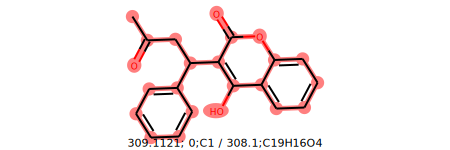

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})]}
732.0
384.0
666.0
732.0
Parent fragment frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})
Generated fragment. Current indexes[frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22})]
Generated fragment. Parrent indexes[frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22})]


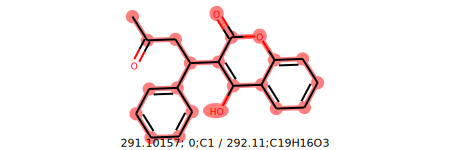

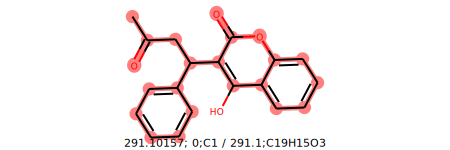

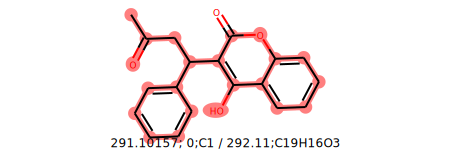

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22})]}
1568.0
1568.0
1568.0
1220.0
1220.0
1220.0
1672.0
1672.0
1672.0
1672.0
2404.0
2404.0
2404.0
2404.0
2056.0
2056.0
2056.0
2056.0
2508.0
2508.0
2508.0
2508.0
2508.0
2404.0
2404.0
2404.0
2404.0
2056.0
2056.0
2056.0
2056.0
2508.0
2508.0
2508.0
2508.0
2508.0
2404.0
2404.0
2404.0
2404.0
2404.0
2056.0
2056.0
2056.0
2056.0
2056.0
1672.0
2404.0
2404.0
2404.0
2404.0
2056.0
2056.0
2056.0
2056.0
2508.0
2508.0
2508.0
2508.0
2508.0
2404.0
2404.0
2404.0
2404.0
2404.0
2056.0
2056.0
2056.0
2056.0
2056.0
1672.0
1568.0
1220.0
2404.0
2404.0
2404.0
2

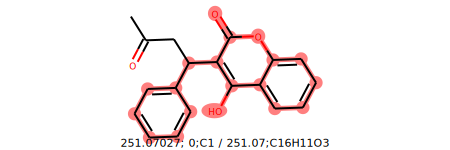

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})]}
2040.0
2040.0
1936.0
1588.0
2508.0
1622.0
2354.0
2006.0
2090.0
2822.0
2474.0
2090.0
2090.0
2269.0
2737.0
2319.0
2319.0
1921.0
2389.0
1971.0
1971.0
1587.0
1587.0
1587.0
1870.0
1537.0
2005.0
1587.0
1587.0
1936.0
2354.0
2822.0
2269.0
2737.0
2319.0
2319.0
1955.0
1955.0
2423.0
2408.0
2408.0
1956.0
2876.0
2408.0
1956.0
2876.0
2424.0
2876.0
2876.0
1990.0
2374.0
2458.0
2842.0
2458.0
2458.0
2842.0
2842.0
2458.0
2458.0
2458.0
2289.0
2757.0
2757.0
2757.0
23

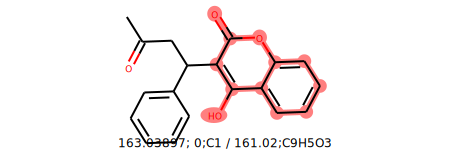

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})]}
2986.0
2986.0
3454.0
2653.0
3121.0
3121.0
3121.0
2703.0
2703.0
2703.0
2319.0
2319.0
2319.0
2319.0
3504.0
3504.0
3052.0
3972.0
3504.0
3052.0
3972.0
3520.0
3972.0
3972.0
3086.0
3470.0
3554.0
3938.0
3554.0
3554.0
3938.0
3938.0
3554.0
3554.0
3554.0
3385.0
3853.0
3853.0
3853.0
3435.0
3435.0
3435.0
3051.0
3051.0
3051.0
3051.0
3334.0
3334.0
3802.0
3001.0
3469.0
3469.0
3469.0
3051.0
3051.0
3051

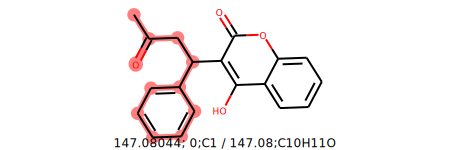

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})]}
3718.0
3718.0
4186.0
3385.0
3853.0
3853.0
3853.0
3435.0
3435.0
3435.0
3051.0
3051.0
3051.0
3051.0
3071.0
3071.0
3539.0
3071.0
3539.0
3539.0
3539.0
2738.0
3206.0
3206.0
3206.0
3206.0
3206.0
3206.0
2788.0
2788.0
2788.0
2788.0
2404.0
2404.0
2404.0
2404.0
2404.0
1100.0
4086.0
4086.0
4554.0
4086.0
4554.0
4554.0
4554.0
3753.0
4221.0
4221.0
4221.0

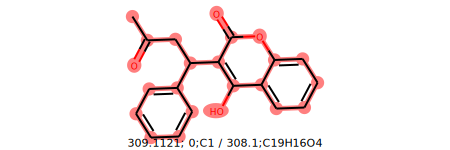

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})]}
732.0
384.0
666.0
732.0
Parent fragment frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})
Generated fragment. Current indexes[frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22})]
Generated fragment. Parrent indexes[frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22})]


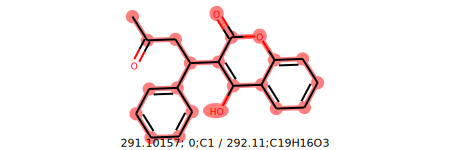

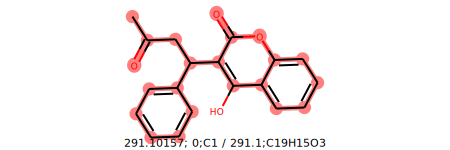

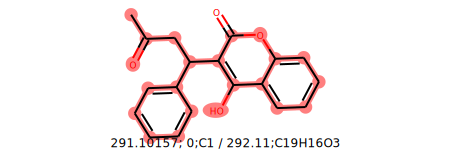

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22})]}
1568.0
1568.0
1568.0
1220.0
1220.0
1220.0
1672.0
1672.0
1672.0
1672.0
2404.0
2404.0
2404.0
2404.0
2056.0
2056.0
2056.0
2056.0
2508.0
2508.0
2508.0
2508.0
2508.0
2404.0
2404.0
2404.0
2404.0
2056.0
2056.0
2056.0
2056.0
2508.0
2508.0
2508.0
2508.0
2508.0
2404.0
2404.0
2404.0
2404.0
2404.0
2056.0
2056.0
2056.0
2056.0
2056.0
1672.0
2404.0
2404.0
2404.0
2404.0
2056.0
2056.0
2056.0
2056.0
2508.0
2508.0
2508.0
2508.0
2508.0
2404.0
2404.0
2404.0
2404.0
2404.0
2056.0
2056.0
2056.0
2056.0
2056.0
1672.0
1568.0
1220.0
2404.0
2404.0
2404.0
2

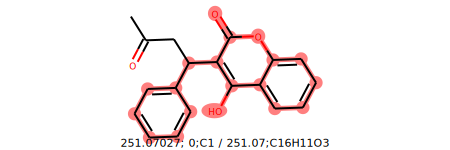

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})]}
2040.0
2040.0
1936.0
1588.0
2508.0
1622.0
2354.0
2006.0
2090.0
2822.0
2474.0
2090.0
2090.0
2269.0
2737.0
2319.0
2319.0
1921.0
2389.0
1971.0
1971.0
1587.0
1587.0
1587.0
1870.0
1537.0
2005.0
1587.0
1587.0
1936.0
2354.0
2822.0
2269.0
2737.0
2319.0
2319.0
1955.0
1955.0
2423.0
2408.0
2408.0
1956.0
2876.0
2408.0
1956.0
2876.0
2424.0
2876.0
2876.0
1990.0
2374.0
2458.0
2842.0
2458.0
2458.0
2842.0
2842.0
2458.0
2458.0
2458.0
2289.0
2757.0
2757.0
2757.0
23

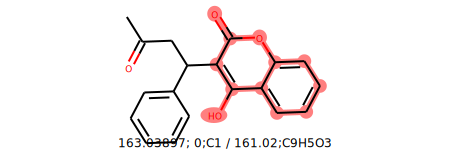

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})]}
2986.0
2986.0
3454.0
2653.0
3121.0
3121.0
3121.0
2703.0
2703.0
2703.0
2319.0
2319.0
2319.0
2319.0
3504.0
3504.0
3052.0
3972.0
3504.0
3052.0
3972.0
3520.0
3972.0
3972.0
3086.0
3470.0
3554.0
3938.0
3554.0
3554.0
3938.0
3938.0
3554.0
3554.0
3554.0
3385.0
3853.0
3853.0
3853.0
3435.0
3435.0
3435.0
3051.0
3051.0
3051.0
3051.0
3334.0
3334.0
3802.0
3001.0
3469.0
3469.0
3469.0
3051.0
3051.0
3051

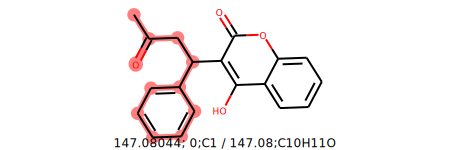

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})]}
3718.0
3718.0
4186.0
3385.0
3853.0
3853.0
3853.0
3435.0
3435.0
3435.0
3051.0
3051.0
3051.0
3051.0
3071.0
3071.0
3539.0
3071.0
3539.0
3539.0
3539.0
2738.0
3206.0
3206.0
3206.0
3206.0
3206.0
3206.0
2788.0
2788.0
2788.0
2788.0
2404.0
2404.0
2404.0
2404.0
2404.0
1100.0
4086.0
4086.0
4554.0
4086.0
4554.0
4554.0
4554.0
3753.0
4221.0
4221.0
4221.0

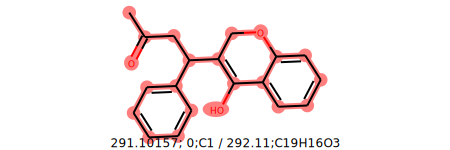

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22})]}
836.0
836.0
836.0
1672.0
1672.0
1672.0
1672.0
1672.0
1672.0
1672.0
1672.0
1672.0
1672.0
1672.0
1672.0
1672.0
1672.0
1672.0
1672.0
1672.0
1672.0
1672.0
1672.0


Parent fragment frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22})
Generated fragment. Current indexes[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})]
Generated fragment. Parrent indexes[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})]


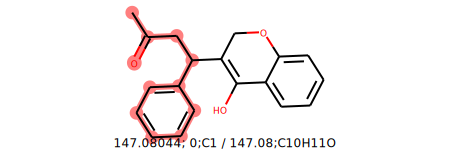

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})]}
2986.0
2986.0
3454.0
2653.0
3121.0
3121.0
3121.0
2703.0
2703.0
2703.0
2319.0
2319.0
2319.0
2319.0
3071.0
3071.0

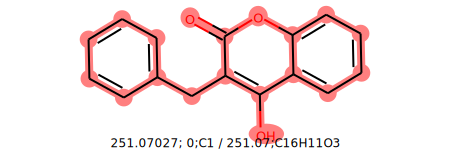

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

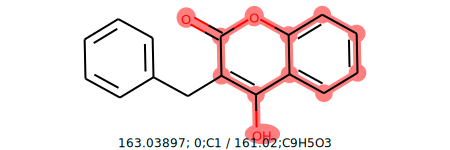

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

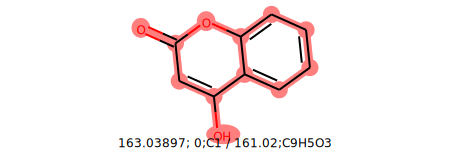

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

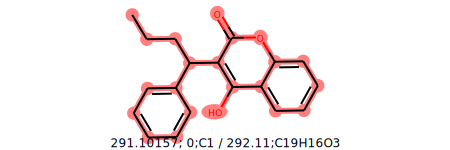

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

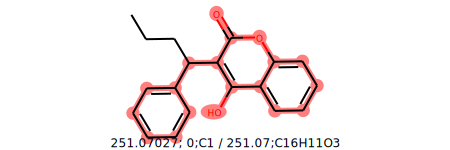

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

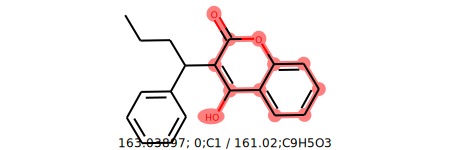

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

3175.0
2374.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2424.0
2424.0
2424.0
2424.0
2424.0
1204.0
3354.0
3354.0
3822.0
3354.0
3822.0
3822.0
3822.0
3354.0
3822.0
3822.0
3822.0
3822.0
3822.0
3822.0
3021.0
3489.0
3489.0
3489.0
3489.0
3489.0
3489.0
3489.0
3489.0
3489.0
3489.0
3071.0
3071.0
3071.0
3071.0
3071.0
1851.0
1871.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
1588.0
2235.0
2006.0
3489.0
3175.0
2842.0
3489.0
3175.0
2842.0
3822.0
3489.0
3175.0
3175.0
2842.0
3489.0
3175.0
2842.0
3822.0
3489.0
3175.0
3175.0
2842.0
3822.0
3822.0
3489.0
3175.0
3175.0
3175.0
2842.0
3489.0
3175.0
2842.0
3822.0
3489.0
3175.0
3175.0
2842.0
3822.0
3822.0
3489.0
3175.0
3175.0
3175.0
2842.0
3822.0
3822.0
3822.0
3489.0
3175.0
3175.0
3175.0
3175.0
2842.0
3489.0
3175.0
2842.0
3822.0
3489.0

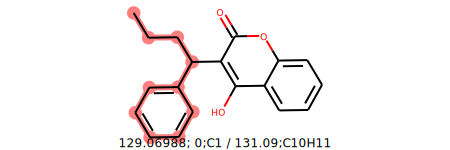

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

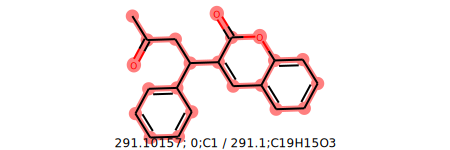

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

2706.0
2706.0
2238.0
2706.0
2706.0
2706.0
2706.0
2706.0
2706.0
1905.0
2373.0
2373.0
2373.0
2373.0
2373.0
2373.0
2373.0
2373.0
2373.0
2373.0
1955.0
1955.0
1955.0
1955.0
1955.0
1119.0
2304.0
2304.0
3608.0
2304.0
3608.0
2772.0
3608.0
3608.0
2304.0
3608.0
2772.0
3608.0
3608.0
2772.0
2772.0
3608.0
3608.0
3608.0
2304.0
3608.0
2772.0
3608.0
3608.0
2772.0
2772.0
3608.0
3608.0
3608.0
2772.0
2772.0
2772.0
3608.0
3608.0
3608.0
3608.0
2722.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
2637.0
3105.0
3105.0
3105.0
3105.0
3105.0
3105.0
3105.0
3105.0
3105.0
3105.0
2687.0
2687.0
2687.0
2687.0
2687.0
1851.0
1487.0
2791.0
2791.0
2791.0
2791.0
2791.0
2791.0
2791.0
2791.0
2791.0
2791.0
2791.0
2791.0
2791.0
2791.0
2791.0
2791.0
2791.0
2791.0
2791.0
2791.0
1119.0
2354.0
1851.0
2373.0
3608.0
3190.0
3190.0
3105.0
2791.0
2373.0
3608.0
3190.0
3190.0
3105.0
2791.0
2706.0
2373.0
3608.0

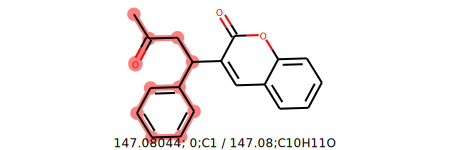

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

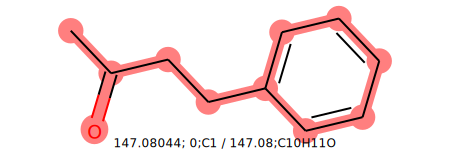

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

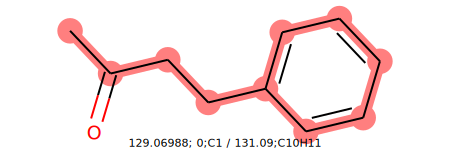

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

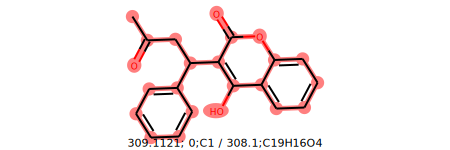

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})], frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})], frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 1

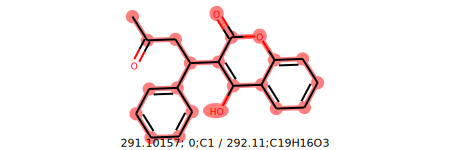

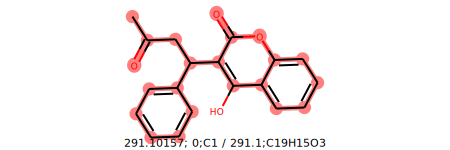

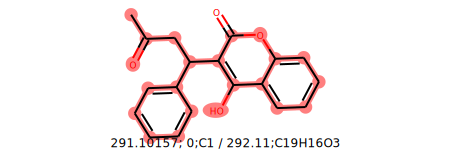

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})], frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({

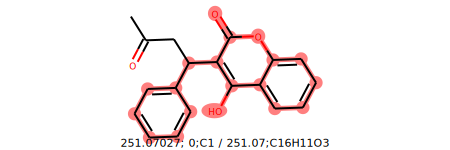

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2

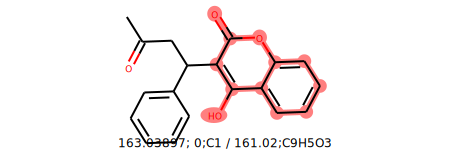

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2

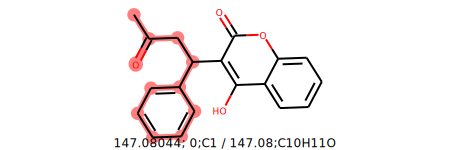

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

0
Parent fragment frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22})
Generated fragment. Current indexes[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21})]
Generated fragment. Parrent indexes[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22})]


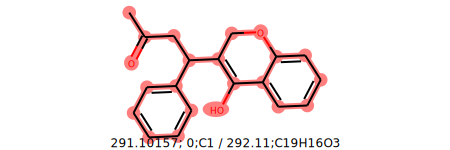

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2

3438.0
3438.0
3438.0
2637.0
3105.0
3105.0
3105.0
3105.0
3105.0
3105.0
2687.0
2687.0
2687.0
2687.0
3055.0
3055.0
3523.0
3055.0
3523.0
3523.0
3523.0
3055.0
3523.0
3523.0
3523.0
3523.0
3523.0
3523.0
2722.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
3190.0
2772.0
2772.0
2772.0
2772.0
2772.0
3439.0
3439.0
3907.0
3439.0
3907.0
3907.0
3907.0
3439.0
3907.0
3907.0
3907.0
3907.0
3907.0
3907.0
1572.0
1956.0
2876.0
1956.0
2876.0
2424.0
2876.0
2876.0
1956.0
2876.0
2424.0
2876.0
2876.0
2424.0
2424.0
2876.0
2876.0
2876.0
1956.0
2876.0
2424.0
2876.0
2876.0
2424.0
2424.0
2876.0
2876.0
2876.0
2424.0
2424.0
2424.0
2876.0
2876.0
2876.0
2876.0
2374.0
2458.0
2842.0
2458.0
2458.0
2842.0
2842.0
2458.0
2458.0
2458.0
2842.0
2842.0
2842.0
2458.0
2458.0
2458.0
2458.0
2842.0
2842.0
2842.0
2842.0
2458.0
2458.0
2458.0
2458.0
2458.0
2289.0
2757.0
2757.0
2757.0
2757.0
2757.0
2757.0
2757.0
2757.0
2757.0
2757.0
2339.0
2339.0
2339.0
2339.0
2339.0
1119.0
2238.0
2238.0
2706.0
2238.0
2706.0
2706.0
2706.0

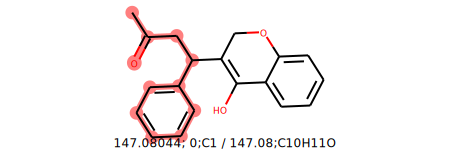

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

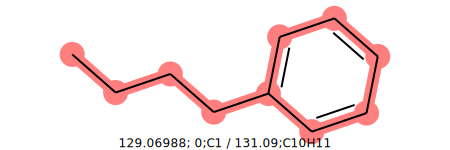

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

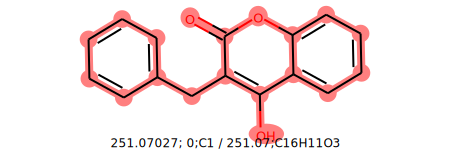

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

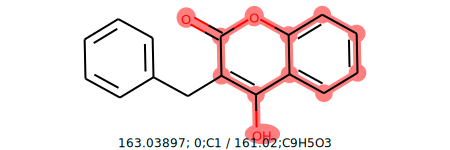

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

1587.0
1587.0
2090.0
1971.0
1587.0
2319.0
1587.0
2090.0
1971.0
1587.0
2319.0
2508.0
2090.0
2474.0
2389.0
2005.0
2822.0
2737.0
2423.0
1587.0
2090.0
1971.0
1587.0
2319.0
2508.0
2090.0
2474.0
2389.0
2005.0
2822.0
2737.0
2423.0
2508.0
2508.0
2056.0
2090.0
2474.0
2389.0
2338.0
2005.0
2404.0
2822.0
2737.0
2423.0
2423.0
2040.0
2040.0
1588.0
2040.0
1588.0
1622.0
2006.0
1921.0
1870.0
1870.0
1537.0
1936.0
1936.0
2354.0
2269.0
1955.0
1955.0
1955.0
1936.0
1936.0
1936.0
1955.0
1955.0
1955.0
1955.0
1870.0
1870.0
1870.0
1537.0
2269.0
2354.0
1588.0
1588.0
1588.0
1921.0
2006.0
2056.0
2056.0
2056.0
2056.0
2404.0
2404.0
2404.0
2404.0
751.0
836.0
2040.0
2040.0
2040.0
1622.0
2040.0
{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1

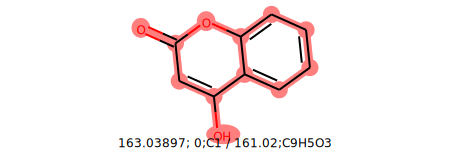

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

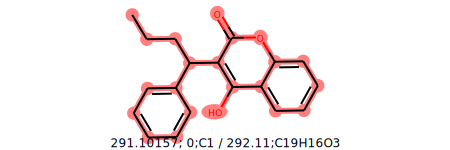

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

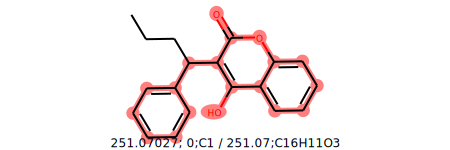

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

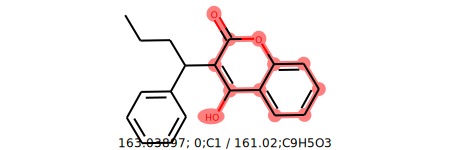

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

2986.0
2986.0
3454.0
2653.0
3121.0
3121.0
3121.0
2703.0
2703.0
2703.0
2319.0
2319.0
2319.0
2319.0
2339.0
2339.0
2807.0
2339.0
2807.0
2807.0
2807.0
2006.0
2474.0
2474.0
2474.0
2474.0
2474.0
2474.0
2056.0
2056.0
2056.0
2056.0
1672.0
1672.0
1672.0
1672.0
1672.0
368.0
3354.0
3354.0
3822.0
3354.0
3822.0
3822.0
3822.0
3021.0
3489.0
3489.0
3489.0
3489.0
3489.0
3489.0
3071.0
3071.0
3071.0
3071.0
2687.0
2687.0
2687.0
2687.0
2687.0
2707.0
2707.0
3175.0
2707.0
3175.0
3175.0
3175.0
2707.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
2374.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2842.0
2424.0
2424.0
2424.0
2424.0
2424.0
1204.0
3354.0
3354.0
3822.0
3354.0
3822.0
3822.0
3822.0
3354.0
3822.0
3822.0
3822.0
3822.0
3822.0
3822.0
3021.0
3489.0
3489.0
3489.0
3489.0
3489.0
3489.0
3489.0
3489.0
3489.0
3489.0
3071.0
3071.0
3071.0
3071.0
3071.0
1851.0
1871.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0
3175.0


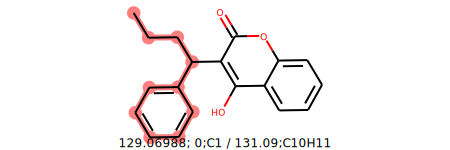

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

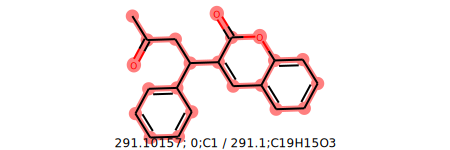

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

3105.0
3105.0
2687.0
2687.0
2687.0
2687.0
2687.0
2687.0
2687.0
2687.0
2687.0
3872.0
3872.0
3036.0
4340.0
3872.0
3036.0
4340.0
3504.0
4340.0
4340.0
3872.0
3036.0
4340.0
3504.0
4340.0
4340.0
3504.0
3504.0
4340.0
4340.0
4340.0
3454.0
3454.0
3922.0
3922.0
3922.0
3922.0
3922.0
3922.0
3922.0
3922.0
3922.0
3922.0
3922.0
3922.0
3922.0
3922.0
3922.0
3922.0
3369.0
3837.0
3837.0
3837.0
3837.0
3837.0
3837.0
3419.0
3419.0
3419.0
3419.0
3419.0
3419.0
3419.0
3419.0
3419.0
3055.0
3055.0
3523.0
3055.0
3523.0
3523.0
3523.0
3055.0
3523.0
3523.0
3523.0
3523.0
3523.0
3523.0
2238.0
2238.0
2706.0
2238.0
2706.0
2706.0
2706.0
2238.0
2706.0
2706.0
2706.0
2706.0
2706.0
2706.0
1905.0
2373.0
2373.0
2373.0
2373.0
2373.0
2373.0
2373.0
2373.0
2373.0
2373.0
1955.0
1955.0
1955.0
1955.0
1955.0
1119.0
2304.0
2304.0
3608.0
2304.0
3608.0
2772.0
3608.0
3608.0
2304.0
3608.0
2772.0
3608.0
3608.0
2772.0
2772.0
3608.0
3608.0
3608.0
2304.0
3608.0
2772.0
3608.0
3608.0
2772.0
2772.0
3608.0
3608.0
3608.0
2772.0
2772.0
2772.0
3608.0

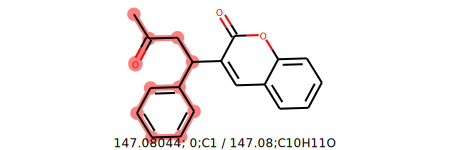

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

0
Parent fragment frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})
Generated fragment. Current indexes[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})]
Generated fragment. Parrent indexes[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})]


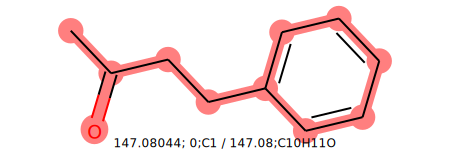

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

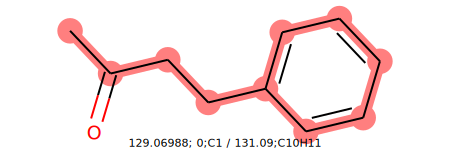

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})], frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}): [frozenset({4, 5, 6, 7, 8, 9

In [115]:
################################################################################################
#
# Generate fragmentatoin graph
#
################################################################################################

Generated_data=Calculate_fragmentation_tree (mol,Number_of_levels,Fragment_data, Breaking_bonds_max, Remaining_fragments_max)


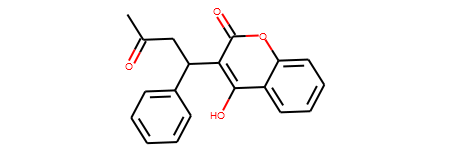

In [116]:
# Add label For MDPV

Molecular_Smiles="CCCC(C(=O)C1=CC2=C(C=C1)OCO2)N3CCCC3"
Molecular_Smiles="CCCC(C(=[18O])C1=CC2=C(C=C1)OCO2)N3CCCC3"
#Molecular_Smiles="CCCC(C(=O)C1=CC2=C(C=C1)[18O]CO2)N3CCCC3"

# Add label For Ketoprofen
Molecular_Smiles="CC(C1=CC(=CC=C1)C(=O)C2=CC=CC=C2)C(=O)O"

# Add label For Warfarin
Molecular_Smiles="CC(=O)CC(C1=CC=CC=C1)C2=C(C3=CC=CC=C3OC2=O)O"

mol = Chem.MolFromSmiles(Molecular_Smiles)
mol

Displaying parent structure frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})
Fragmentation_graph_sets_edge[[1, 1, 732.0, 'C19H15O3'], [1, 1, 384.0, 'C19H15O3'], [1, 1, 732.0, 'C19H15O3'], [1, 1, 368.0, 'C16H11O3'], [1, 1, 368.0, 'C9H7O3'], [1, 1, 368.0, 'C10H11O']]
dddddddddddddddd
C19O4


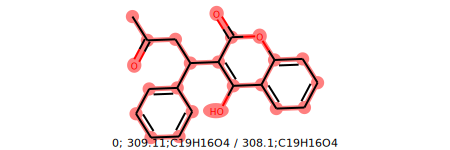

Displaying fragments frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})
dddddddddddddddd
C19O3


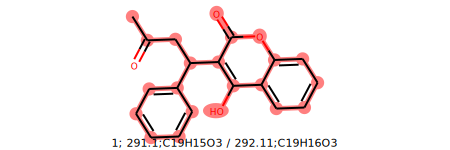

Displaying fragments frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21})
dddddddddddddddd
C19O3


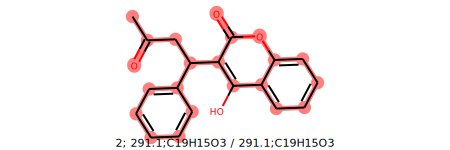

Displaying fragments frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22})
dddddddddddddddd
C19O3


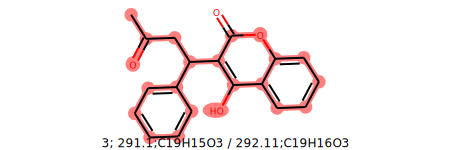

Displaying fragments frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})
dddddddddddddddd
C16O3


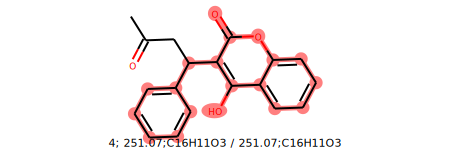

Displaying fragments frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})
dddddddddddddddd
C9O3


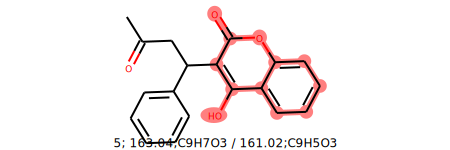

Displaying fragments frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})
dddddddddddddddd
C10O


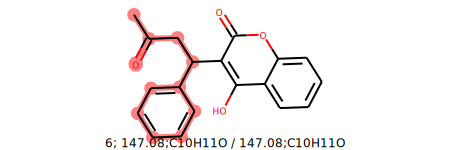

Displaying parent structure frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22})
Fragmentation_graph_sets_edge[[1, 1, 368.0, 'C10H11O']]


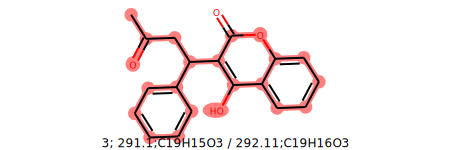

Displaying fragments frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})


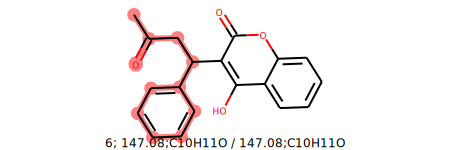

Displaying parent structure frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})
Fragmentation_graph_sets_edge[[1, 1, 368.0, 'C9H7O3']]


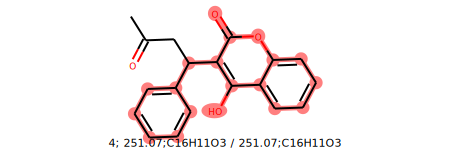

Displaying fragments frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})


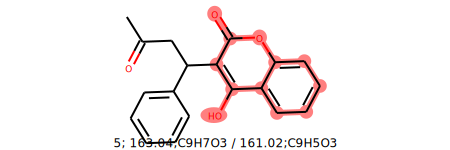

Displaying parent structure frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})
Fragmentation_graph_sets_edge[]


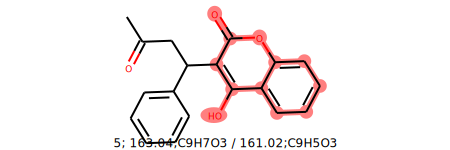

Displaying parent structure frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})
Fragmentation_graph_sets_edge[[1, 1, 368.0, 'C16H11O3'], [1, 1, 368.0, 'C9H7O3'], [1, 1, 368.0, 'C10H9']]


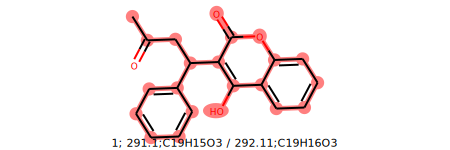

Displaying fragments frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})


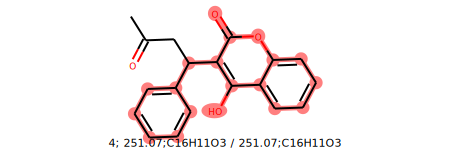

Displaying fragments frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})


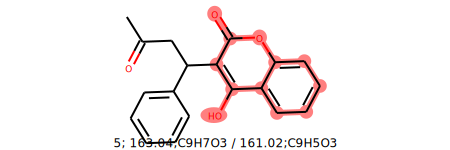

Displaying fragments frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10})
dddddddddddddddd
C10


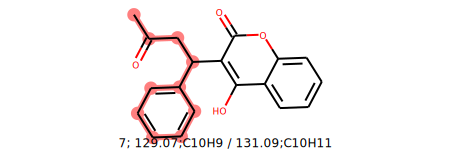

Displaying parent structure frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21})
Fragmentation_graph_sets_edge[[1, 1, 368.0, 'C10H11O']]


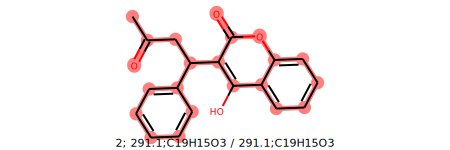

Displaying fragments frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})


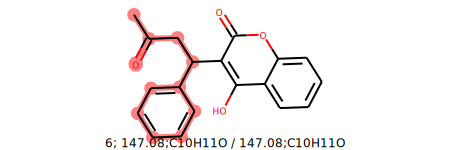

Displaying parent structure frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})
Fragmentation_graph_sets_edge[[1, 1, 732.0, 'C10H9']]


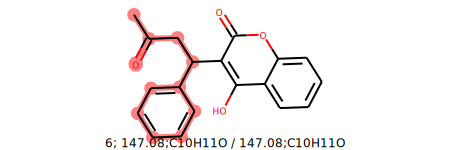

Displaying fragments frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10})


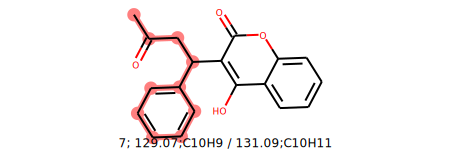

Displaying parent structure frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10})
Fragmentation_graph_sets_edge[]


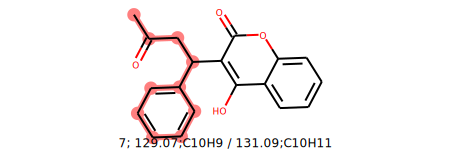

{('4', '5'), ('0', '4'), ('1', '4'), ('0', '6'), ('0', '1'), ('6', '7'), ('0', '3'), ('0', '5'), ('3', '6'), ('2', '6'), ('1', '5'), ('1', '7'), ('0', '2')}
1.0 1.0 5892.0
0.8571428571428571
frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})
frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})
frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21})
frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22})
frozenset({4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})
frozenset({11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})
frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10})
frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10})
frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})
frozenset({0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22})
frozenset({0, 1, 2, 3, 4, 5,

In [117]:
################################################################################################
#
# Draw fragmentatoin graph
#
################################################################################################

# Add lable

Draw_tree_data=Generate_Fragments_Id (mol,Fragment_data,Generated_data[0],Generated_data[1],path_to_pictures,DropIsotopes=True)

Draw_Graph_For_GraphViz_output=Draw_Graph_For_GraphViz (Draw_tree_data[0],Draw_tree_data[1],Draw_tree_data[2],Generated_data[0],Generated_data[1])


# Old way 
#Draw_tree_data=Draw_tree (mol,Fragment_data,Generated_data[0],Generated_data[1],path_to_pictures,DropIsotopes=True)
#check_call(['dot','-Tpng',output_path+name+'\\'+'For_Graphviz.txt','-o',output_path+name+'\\'+'Graph.png'])


In [118]:
# Call GraphViz

check_call(['dot','-Tpng',output_path+name+'\\'+'For_Graphviz.txt','-o',output_path+name+'\\'+'Graph.png'])


0

In [119]:
#Draw_tree_data

In [120]:
##################################################
#
# Create NetworX representation of fragmentation tree
#
##################################################

G=Draw_Graph_For_GraphViz_output[0]
G1=Set_mass_differences_to_esges(G)

('0', '4')
C19H16O4
  element  number
0       C      19
1       H      16
2       O       4
  element  number
0       C      16
1       H      11
2       O       3
  element  number
0       C     3.0
1       H     5.0
2       O     1.0
('0', '6')
C19H16O4
  element  number
0       C      19
1       H      16
2       O       4
  element  number
0       C      10
1       H      11
2       O       1
  element  number
0       C     9.0
1       H     5.0
2       O     3.0
('0', '1')
C19H16O4
  element  number
0       C      19
1       H      16
2       O       4
  element  number
0       C      19
1       H      15
2       O       3
  element  number
0       H     1.0
1       O     1.0
('0', '3')
C19H16O4
  element  number
0       C      19
1       H      16
2       O       4
  element  number
0       C      19
1       H      15
2       O       3
  element  number
0       H     1.0
1       O     1.0
('0', '5')
C19H16O4
  element  number
0       C      19
1       H      16
2       O       4


In [121]:
G.nodes['0']
for a in list(G1.edges):
    print(a)
    print(G1.get_edge_data(*a))
    Diff_data=G1.get_edge_data(*a)['f1_minus_f2_DatFrame']


('0', '4')
{'nr': '1', 'bb': ' 1', 'f1_minus_f2_DatFrame':   element  number
0       C     3.0
1       H     5.0
2       O     1.0}
('0', '6')
{'nr': '1', 'bb': ' 1', 'f1_minus_f2_DatFrame':   element  number
0       C     9.0
1       H     5.0
2       O     3.0}
('0', '1')
{'nr': '1', 'bb': ' 1', 'f1_minus_f2_DatFrame':   element  number
0       H     1.0
1       O     1.0}
('0', '3')
{'nr': '1', 'bb': ' 1', 'f1_minus_f2_DatFrame':   element  number
0       H     1.0
1       O     1.0}
('0', '5')
{'nr': '1', 'bb': ' 1', 'f1_minus_f2_DatFrame':   element  number
0       C    10.0
1       H     9.0
2       O     1.0}
('0', '2')
{'nr': '1', 'bb': ' 1', 'f1_minus_f2_DatFrame':   element  number
0       H     1.0
1       O     1.0}
('1', '4')
{'nr': '1', 'bb': ' 1', 'f1_minus_f2_DatFrame':   element  number
0       C     3.0
1       H     4.0}
('1', '5')
{'nr': '1', 'bb': ' 1', 'f1_minus_f2_DatFrame':   element  number
0       C    10.0
1       H     8.0}
('1', '7')
{'nr': '1', 'bb': ' 1',

In [122]:
Rewrite_for_Graphviz(output_path,name,G1)
check_call(['dot','-Tpng',output_path+name+'\\'+'For_Graphviz_mass_diff.txt','-o',output_path+name+'\\'+'Graph_mass_diff.png'])
  

0

In [123]:
Fragments_Id=Draw_tree_data[0]
Fragments_Id

,atom_set,name,fi,formula,mz,formulaNoH,frag_intensity,mol_weight_from_formula,elem_formula_from_input,color
0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0a1a2a3a4a5a6a7a8a9a10a11a12a13a14a15a16a17a18...,0,C19H16O4,309.11210,C19O4,15.0,308.104859,C19H16O4,black
1,"(0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0a1a3a4a5a6a7a8a9a10a11a12a13a14a15a16a17a18a1...,1,C19H16O3,291.10157,C19O3,12.0,292.109944,C19H15O3,red
2,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0a1a2a3a4a5a6a7a8a9a10a11a12a13a14a15a16a17a18...,2,C19H15O3,291.10157,C19O3,12.0,291.102119,C19H15O3,black
3,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0a1a2a3a4a5a6a7a8a9a10a11a12a13a14a15a16a17a18...,3,C19H16O3,291.10157,C19O3,12.0,292.109944,C19H15O3,red
4,"(4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",4a5a6a7a8a9a10a11a12a13a14a15a16a17a18a19a20a2...,4,C16H11O3,251.07027,C16O3,20.0,251.070819,C16H11O3,black
5,"(11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22)",11a12a13a14a15a16a17a18a19a20a21a22,5,C9H5O3,163.03897,C9O3,100.0,161.023869,C9H7O3,red
6,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)",0a1a2a3a4a5a6a7a8a9a10,6,C10H11O,147.08044,C10O,20.0,147.080990,C10H11O,black
7,"(0, 1, 3, 4, 5, 6, 7, 8, 9, 10)",0a1a3a4a5a6a7a8a9a10,7,C10H11,129.06988,C10,14.0,131.086075,C10H9,red


C:\Users\Yury Kostyukevich\.conda\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
C:\Users\Yury Kostyukevich\.conda\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: zero-size array to reduction operation minimum which has no identity

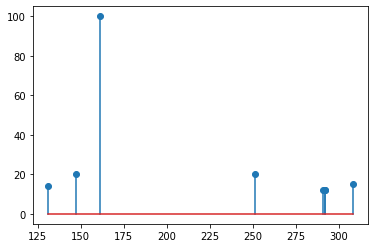

In [124]:
import matplotlib.pyplot as plt
plt.stem(Fragments_Id[Fragments_Id['elem_formula_from_input']!='С1']['mol_weight_from_formula'], Fragments_Id[Fragments_Id['elem_formula_from_input']!='С1']['frag_intensity'],'C0')
plt.stem(Fragments_Id[Fragments_Id['elem_formula_from_input']=='C1']['mol_weight_from_formula'], Fragments_Id[Fragments_Id['elem_formula_from_input']=='C1']['frag_intensity'],'C1')


In [ ]:
#####################################################################################
# !!!!!!!!!!!!!!!!!!
# SRART EXAMPLE
# !!!!!!!!!!!!!!!!!!
# Generate fragmenatation tree for set of molecules
#
######################################################################################


In [ ]:
#########################
# 13.05.2020 generating isomers for mefedron. 
# Input - folder with execel files for each molecule
#
##########################

size_x=450 
size_y=150

Number_of_levels=2
Breaking_bonds_max = 3 
Remaining_fragments_max = 2

output_path="C:\\Users\\Public\\" # No spaces in path!!!!!!!

# Get names of files files
Files_in_Dir=os.listdir("Mephedrone_//")

for file_name in Files_in_Dir:
    # Or read fragmentation data from file
    Fragment_data=pd.read_excel("Mephedrone_//"+file_name)
    
    # Remove fragments with low intensity
    Fragment_data.loc[(Fragment_data["mz"]==178.12),"Intensity"]+=10
    Fragment_data=Fragment_data[Fragment_data["Intensity"]>10]
    Fragment_data=Fragment_data.reset_index()
    
    name=f5(Fragment_data['name'])[0]
    Molecular_Smiles=f5(Fragment_data['Molecular_Smiles'])[0]
    Normalized_collision_Energy=f5(Fragment_data['NCE'])[0]

    Fragment_data["formulaNoH"]=[re.sub("H\d*", "", i) for i in Fragment_data["formula"]]

    mol = Chem.MolFromSmiles(Molecular_Smiles)
    Molecular_Formula=Chem.rdMolDescriptors.CalcMolFormula(mol,True)

    # Set unchangeble properties to atoms
    for a in range(len(mol.GetAtoms())):
        mol.GetAtomWithIdx(a).SetProp('pi',str(a))

    set_bond_energy(mol)

    Check_input_data (Fragment_data)

    os.mkdir(output_path+name+'\\')#
    os.mkdir(output_path+name+'\\'+'\\Fig\\')
    path_to_pictures=output_path+name+'\\'


    ##########################################################

    Generated_data=Calculate_fragmentation_tree (mol,Number_of_levels,Fragment_data, Breaking_bonds_max, Remaining_fragments_max)

    Draw_tree_data = Draw_tree (mol,Fragment_data,Generated_data[0],Generated_data[1],path_to_pictures,Number_of_levels)
    check_call(['dot','-Tpng',output_path+name+'\\'+'For_Graphviz.txt','-o',output_path+name+'\\'+'Graph.png'])
    
    Fragment_data.to_excel(output_path+name+'\\'+file_name)
    
    ###############################################################
    #
    #
    #
    ################################################################
    
    Draw_tree_data=Generate_Fragments_Id (mol,Fragment_data,Generated_data[0],Generated_data[1],path_to_pictures,DropIsotopes=True)
    Draw_Graph_For_GraphViz_output=Draw_Graph_For_GraphViz (Draw_tree_data[0],Draw_tree_data[1],Draw_tree_data[2],Generated_data[0],Generated_data[1])
    G=Draw_Graph_For_GraphViz_output[0]
    G1=Set_mass_differences_to_esges(G)
    Rewrite_for_Graphviz(output_path,name,G1)
    check_call(['dot','-Tpng',output_path+name+'\\'+'For_Graphviz_mass_diff.txt','-o',output_path+name+'\\'+'Graph_mass_diff.png'])
  


NameError: name 'Fragment_data' is not defined

In [ ]:
#####################################################################################
# !!!!!!!!!!!!!!!!!!
# SRART EXAMPLE
# !!!!!!!!!!!!!!!!!!
# Generate fragmenatation tree for set of molecules (for future use for training dataset)
#
# Fixed problem with undeleteble files 
#
######################################################################################


C15H22NO 232 232.347 -0.3470000000000084 
C12H15NO 189 189.258 -0.2580000000000098 
C11H13O 161 161.224 -0.22399999999998954 
C8H16N 126 126.223 -0.22299999999999898 
C8H7O 119 119.143 -0.14300000000000068 
C7H5O 105 105.116 -0.11599999999999966 
C7H7 91 91.133 -0.13299999999999557 
C4H8N 70 70.115 -0.11499999999999488 
0
Parent fragment frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})
Generated fragment. Current indexes[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})]
Generated fragment. Parrent indexes[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})]


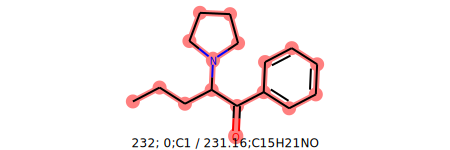

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})]}
836.0
836.0
836.0
1535.0
1535.0
1535.0
1535.0
1572.0
1572.0
1572.0
1572.0
1535.0
1535.0
1535.0
1535.0
1535.0
1572.0
1572.0
1572.0
1572.0
1572.0
1572.0
1572.0
1572.0
1572.0
699.0
1535.0
1535.0
1535.0
1535.0
1535.0
1535.0
1535.0
1535.0
1535.0
699.0
1204.0
1204.0
1204.0
1204.0
1903.0
1903.0
1903.0
1903.0
1903.0
1940.0
1940.0
1940.0
1940.0
1940.0
1067.0
1940.0
1940.0
1940.0
1940.0
1940.0
1104.0
1903.0
1903.0
1903.0
1903.0
1903.0
1067.0
1204.0
1204.0
1204.0
1204.0
1204.0
1067.0
1104.0
1104.0
1067.0
368.0
Parent fragment frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})
Generated fragment. Current indexes[frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})]
Generated fragment. Parrent indexes[frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})]


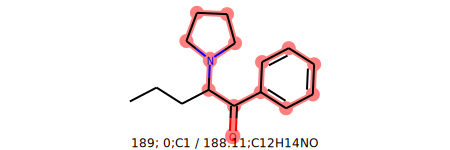

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})]}
331.0
Parent fragment frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})
Generated fragment. Current indexes[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})]
Generated fragment. Parrent indexes[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})]


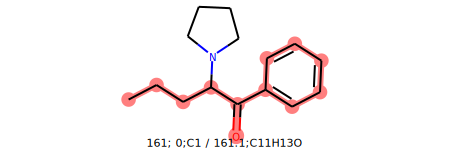

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})]}
368.0
1799.0
1836.0
2267.0
1836.0
2304.0
2267.0
2267.0
1799.0
2267.0
2267.0
2267.0
2230.0
2230.0
2230.0
1468.0
2635.0
2672.0
2635.0
2635.0
2672.0
2672.0
2672.0
2635.0
2635.0
2635.0
2635.0
2635.0
2635.0
2635.0
2635.0
2635.0
2598.0
2598.0
2598.0
2598.0
1936.0
2635.0
2635.0
2672.0
2672.0
2635.0
2635.0
2635.0
2672.0
2672.0
2672.0
2672.0
2672.0
2635.0
2635.0
2635.0
2635.0
2635.0
2635.0
2635.0
2635.0
2635.0
2635.0
2635.0
2635.0
2635.0
2598.0
2598.0
2598.0
2598.0
2598.0
1762.0
2635.0
2635.0
2635.0
2635.0
2635.0
2672.0
2635.0
2635.0
2635.0
2635.0
2672.0
2635.0
2635.0
2672.0
2672.0
2635.0
2635.0
2635.0
2635.0
2672.0
2635.0
2635.0
2672.0
2672.0
2635.0
1936.0
2635.0
2635.0
2635.0
2672.0
2635.0
2635.0
2672.0
2672.0
2635.0
1936.0
Parent fragment

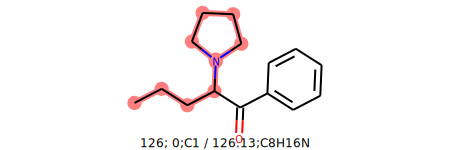

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16})]}
1167.0
1167.0
1167.0
1535.0
1535.0
1535.0
1535.0
1535.0
1535.0
1535.0
1535.0
1535.0
699.0
Parent fragment frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})
Generated fragment. Current indexes[frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})]
Generated fragment. Parrent indexes[frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})]


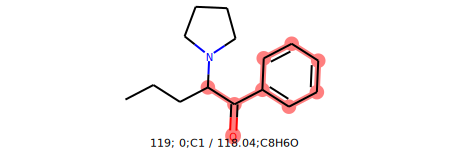

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})]}
1167.0
1167.0
1535.0
1535.0
1535.0
1535.0
1535.0
1535.0
1535.0
1535.0
1535.0
1535.0
1535.0
1535.0
368.0
Parent fragment frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})
Generated fragment. Current indexes[frozenset({4, 5, 6, 7, 8, 9, 10, 11})]
Generated fragment. Parrent indexes[frozenset({4, 5, 6, 7, 8, 9, 10, 11})]


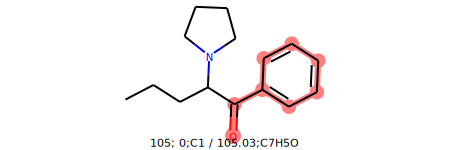

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11})]}
1899.0
1899.0
2267.0
2267.0
2267.0
2267.0
2267.0
2267.0
2267.0
2267.0
2267.0
2267.0
2267.0
2267.0
1100.0
Parent fragment frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})
Generated fragment. Current indexes[frozenset({4, 6, 7, 8, 9, 10, 11})]
Generated fragment. Parrent indexes[frozenset({4, 6, 7, 8, 9, 10, 11})]


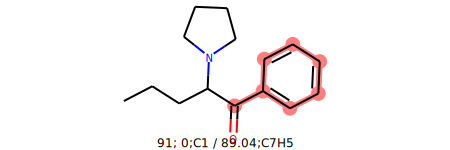

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})]}
1030.0
1435.0
1435.0
2130.0
1435.0
1472.0
2167.0
1435.0
2167.0
2598.0
2598.0
2598.0
2635.0
2635.0
2167.0
2204.0
2167.0
1435.0
1472.0
1472.0
1435.0
331.0
Parent fragment frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})
Generated fragment. Current indexes[frozenset({16, 12, 13, 14, 15})]
Generated fragment. Parrent indexes[frozenset({16, 12, 13, 14, 15})]


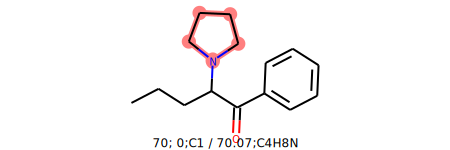

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})]}
0
Parent fragment frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})
Generated fragment. Current indexes[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})]
Generated fragment. Parrent indexes[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})]


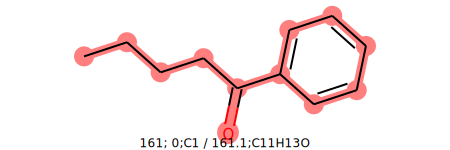

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})]}
836.0
836.0
836.0
1204.0
1204.0
1204.0
1204.0
1204.0
1204.0
1204.0
1204.0
1204.0
368.0
Parent fragment frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})
Generated fragment. Current indexes[frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})]
Generated fragment. Parrent indexes[frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})]


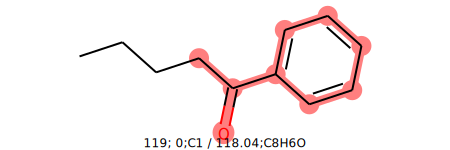

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})]}
836.0
836.0
1204.0
1204.0
1204.0
1204.0
1204.0
1204.0
1204.0
1204.0
1204.0
1204.0
1204.0
1204.0
368.0
Parent fragment frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})
Generated fragment. Current indexes[frozenset({4, 5, 6, 7, 8, 9, 10, 11})]
Generated fragment. Parrent indexes[frozenset({4, 5, 6, 7, 8, 9, 10, 11})]


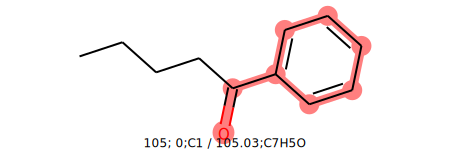

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11})]}
1568.0
1568.0
1936.0
1936.0
1936.0
1936.0
1936.0
1936.0
1936.0
1936.0
1936.0
1936.0
1936.0
1936.0
1100.0
Parent fragment frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})
Generated fragment. Current indexes[frozenset({4, 6, 7, 8, 9, 10, 11})]
Generated fragment. Parrent indexes[frozenset({4, 6, 7, 8, 9, 10, 11})]


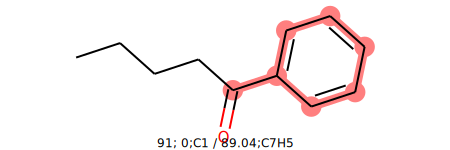

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})]}
0
Parent fragment frozenset({4, 6, 7, 8, 9, 10, 11})
Generated fragment. Current indexes[frozenset({0, 1, 2, 3, 4, 5, 6})]
Generated fragment. Parrent indexes[frozenset({4, 6, 7, 8, 9, 10, 11})]


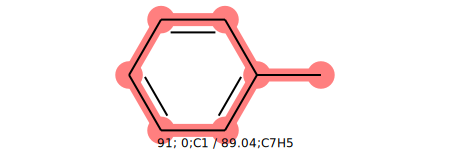

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})]}
0
Parent fragment frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16})
Generated fragment. Current indexes[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8})]
Generated fragment. Parrent indexes[frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16})]


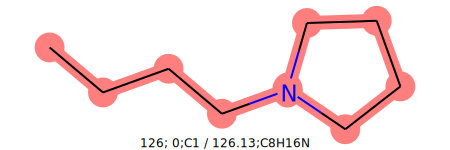

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16})]}
662.0
1067.0
1067.0
1067.0
1104.0
1067.0
1067.0
1104.0
1104.0
1067.0
331.0
Parent fragment frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16})
Generated fragment. Curre

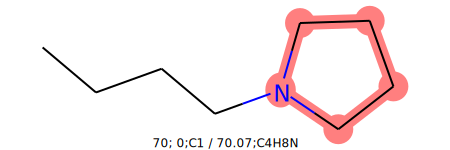

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})]}
0
Parent fragment frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})
Generated fragment. Current indexes[frozenset({0

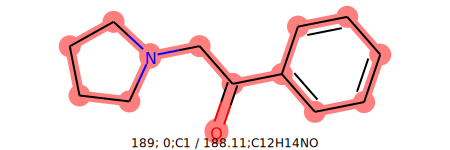

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})]}
1

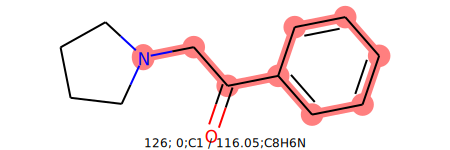

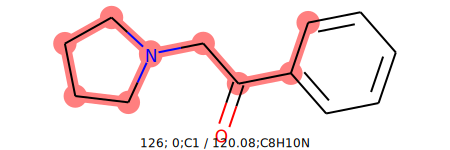

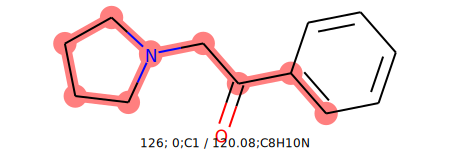

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

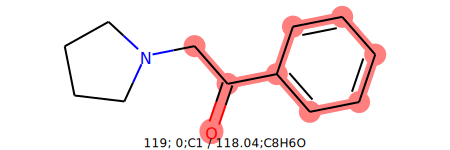

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

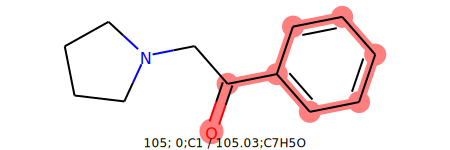

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

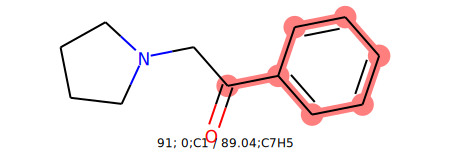

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

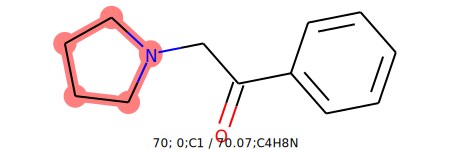

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

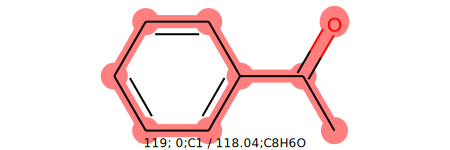

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

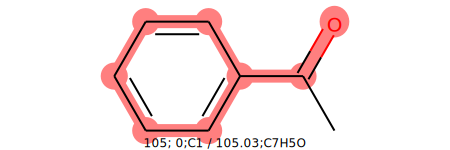

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

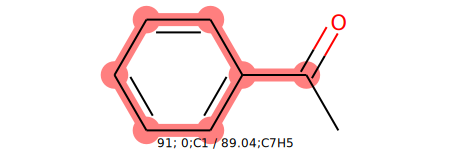

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

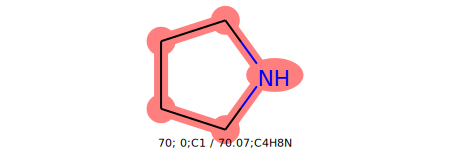

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

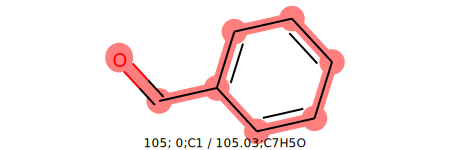

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

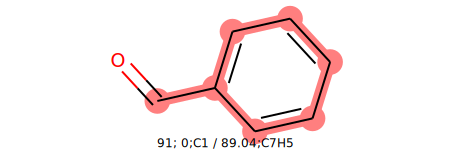

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

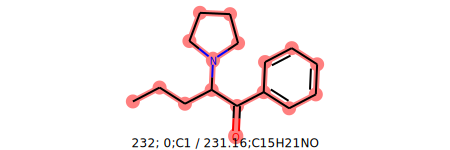

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7,

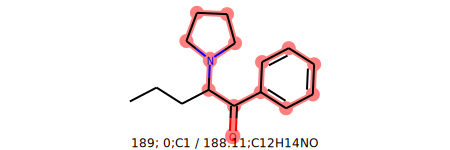

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}

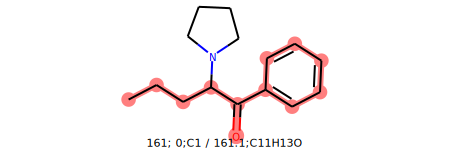

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7

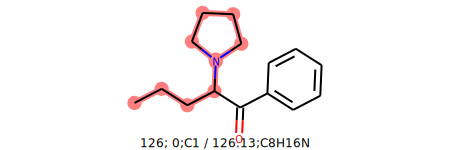

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 12, 13, 14, 15, 16}), frozenset({3, 4, 5

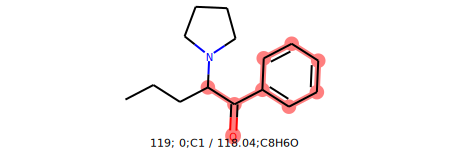

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7

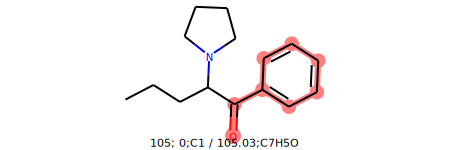

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 

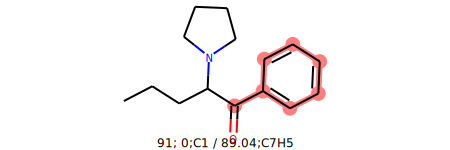

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11

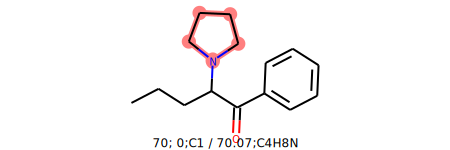

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

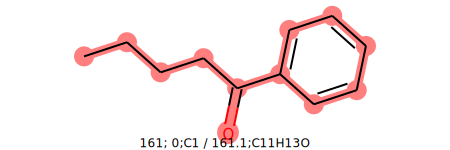

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 12, 13,

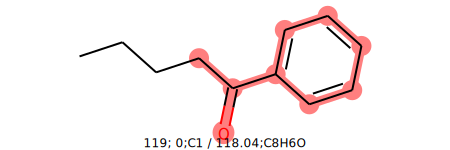

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14

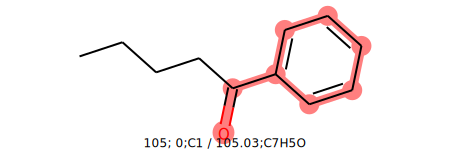

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 1

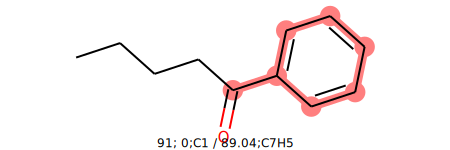

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

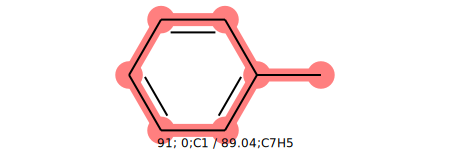

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

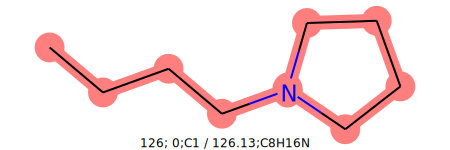

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11

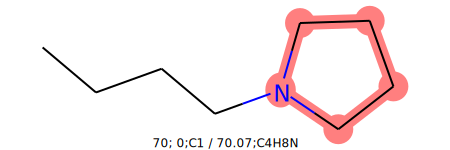

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

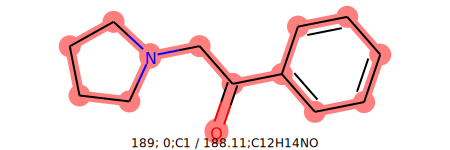

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})], f

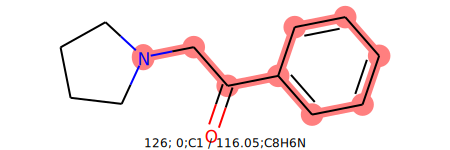

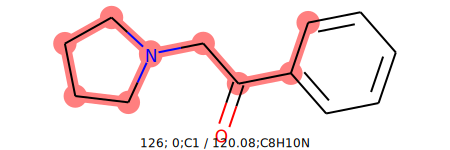

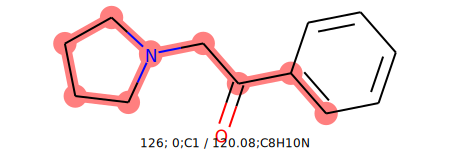

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

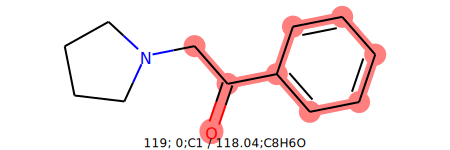

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

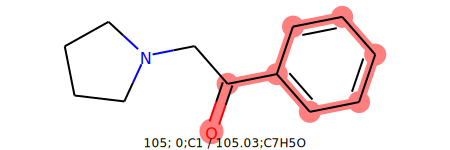

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

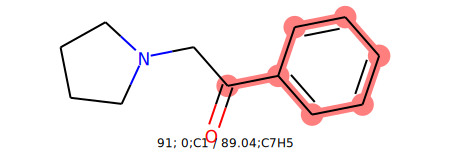

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

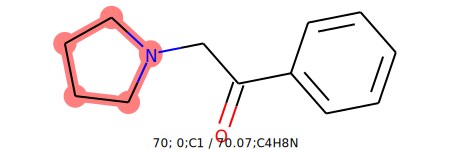

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

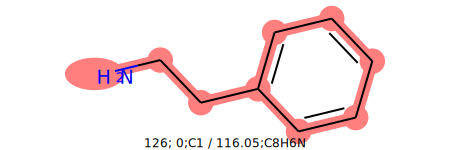

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

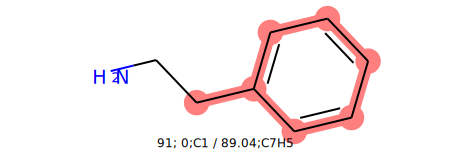

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

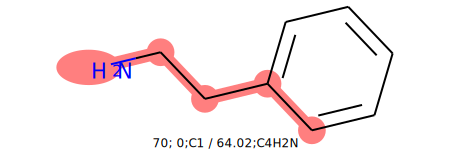

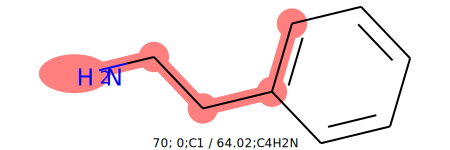

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

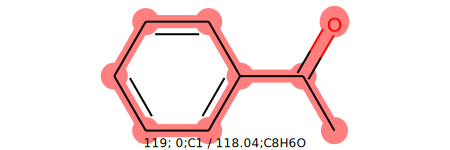

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

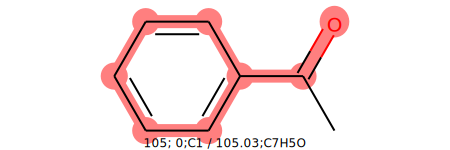

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

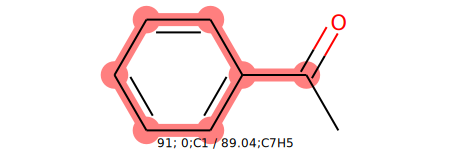

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

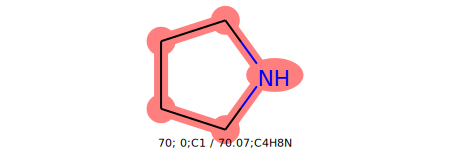

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

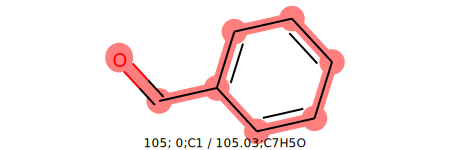

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

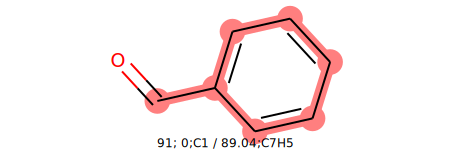

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

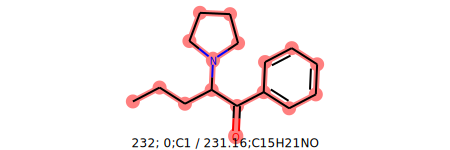

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7,

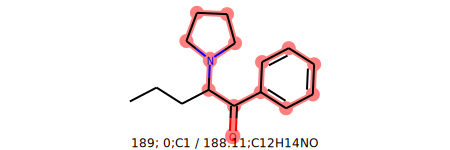

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}

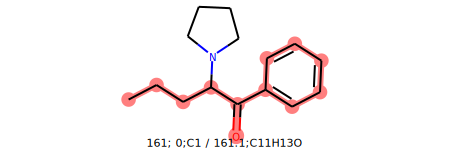

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7

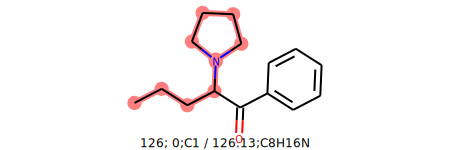

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 12, 13, 14, 15, 16}), frozenset({3, 4, 5

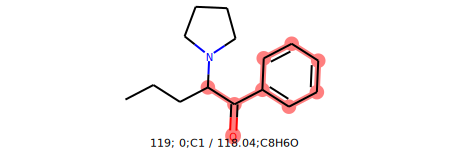

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7

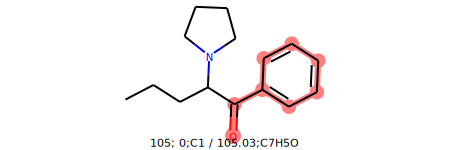

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 

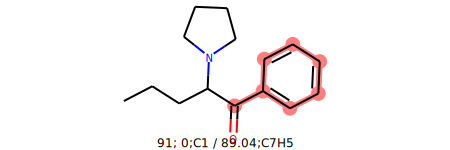

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11

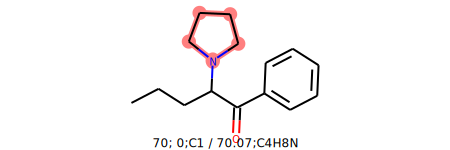

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

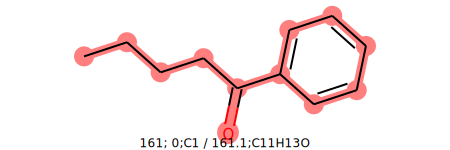

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 12, 13,

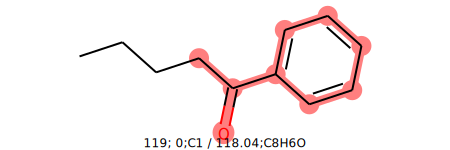

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14

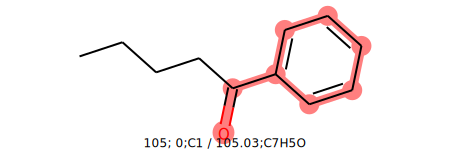

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 1

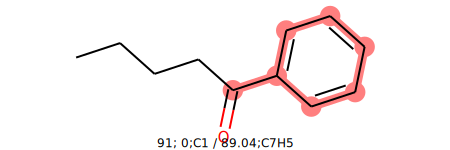

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

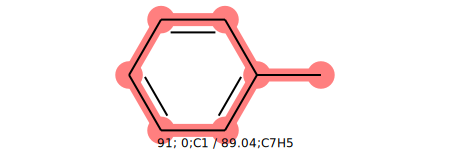

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

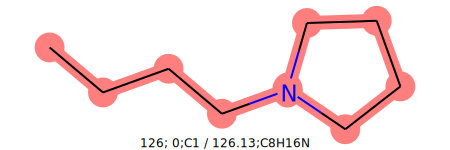

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11

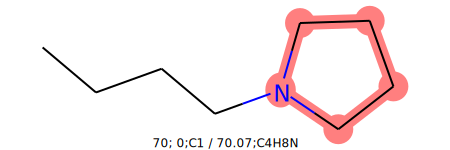

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

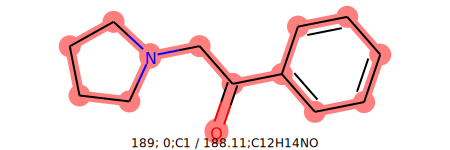

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})], f

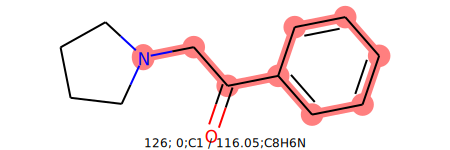

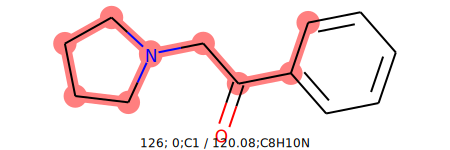

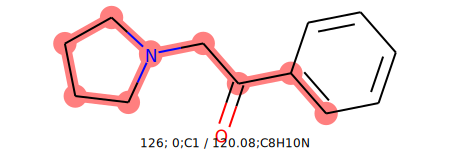

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

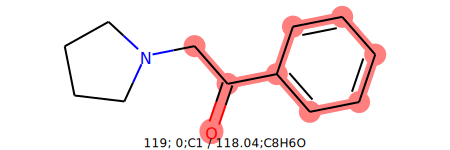

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

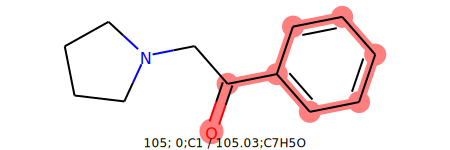

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

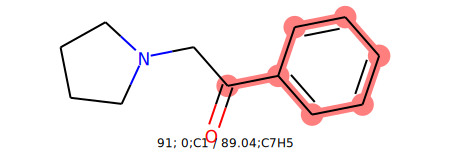

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

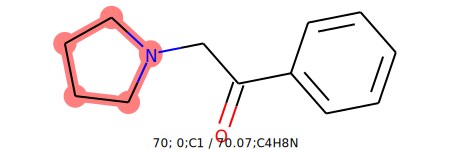

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

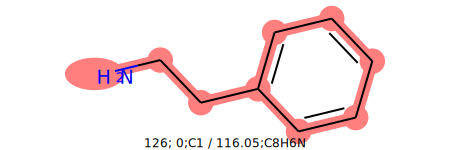

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

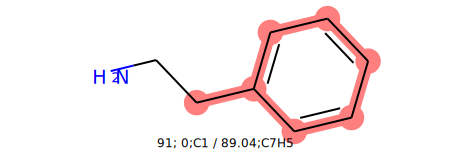

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

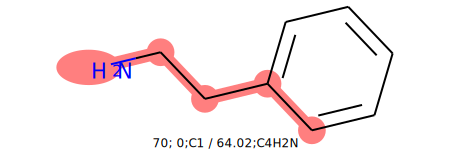

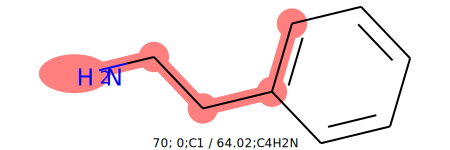

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

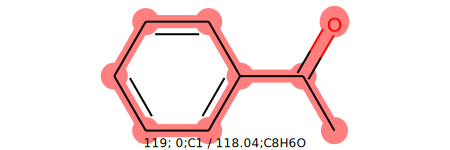

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

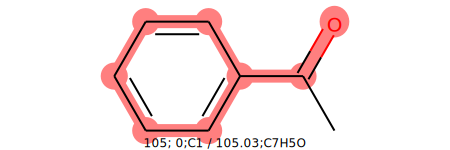

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

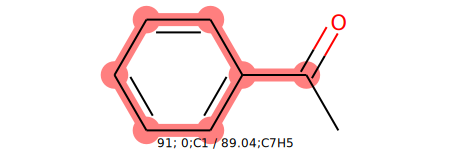

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

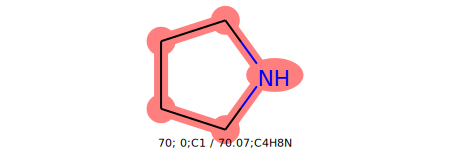

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

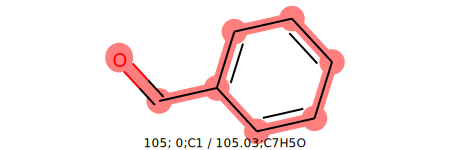

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

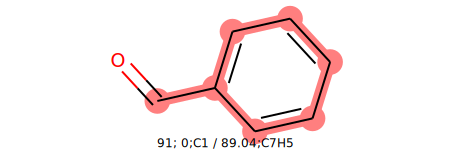

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

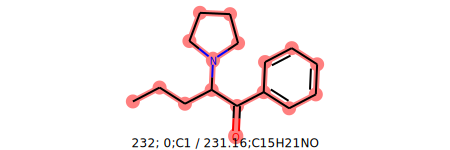

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7,

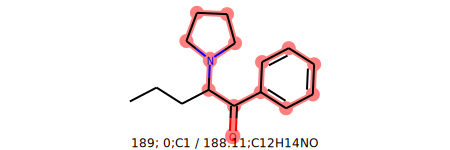

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}

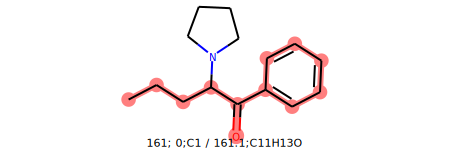

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7

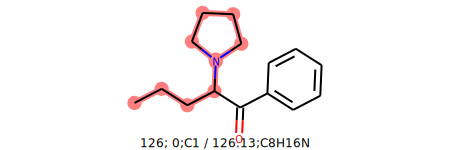

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 12, 13, 14, 15, 16}), frozenset({3, 4, 5

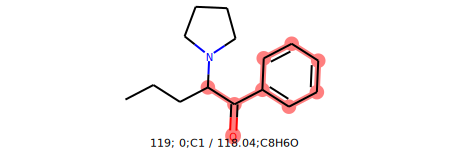

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7

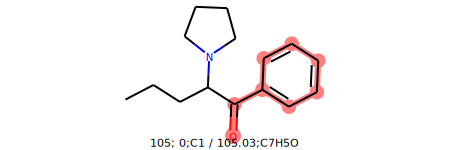

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12}), frozenset({3, 4, 6, 11, 12, 

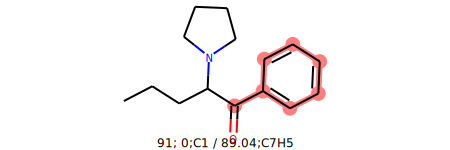

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 6, 7, 8, 9, 10, 11

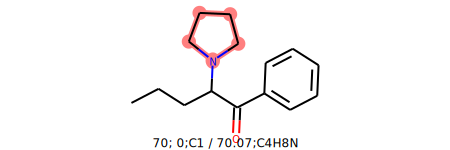

{frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11}), frozenset({16, 12, 13, 14, 15})], frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}): [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 5, 6, 7, 8, 9, 10, 11}), frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({4, 6, 7, 8, 9, 10, 11}): [frozenset({4, 6, 7, 8, 9, 10, 11})], frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}): [frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16}), frozenset({16, 12, 13, 14, 15})], frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}): [frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}), fr

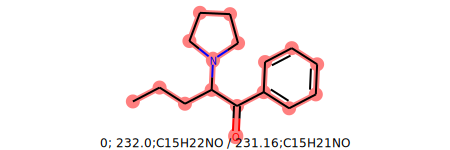

Displaying fragments frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})
dddddddddddddddd


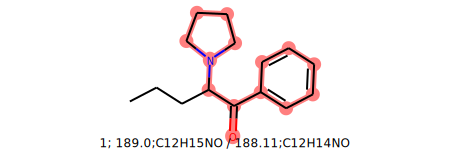

Displaying fragments frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})
dddddddddddddddd


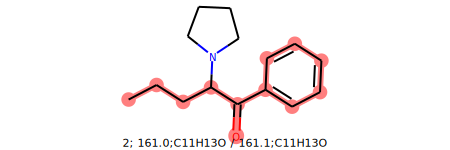

Displaying fragments frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16})
dddddddddddddddd


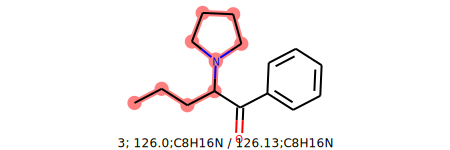

Displaying fragments frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})
dddddddddddddddd


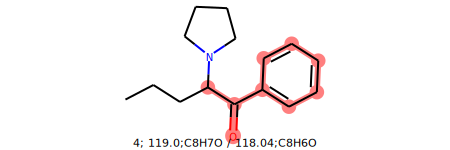

Displaying fragments frozenset({4, 5, 6, 7, 8, 9, 10, 11})
dddddddddddddddd


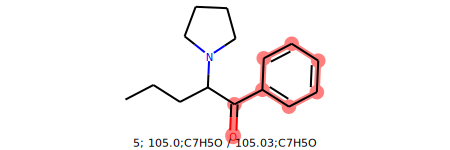

Displaying fragments frozenset({4, 6, 7, 8, 9, 10, 11})
dddddddddddddddd


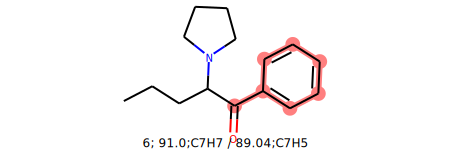

Displaying fragments frozenset({16, 12, 13, 14, 15})
dddddddddddddddd


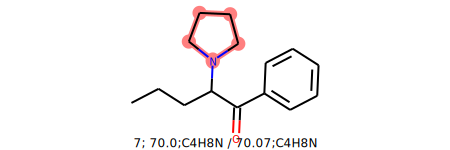

Displaying parent structure frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})
Fragmentation_graph_sets_edge[[1, 1, 368.0, 'C8H7O'], [1, 1, 368.0, 'C7H5O'], [2, 2, 1100.0, 'C7H7']]


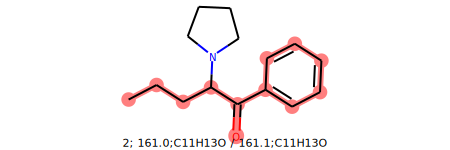

Displaying fragments frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})


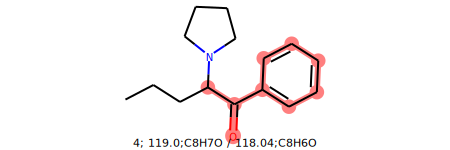

Displaying fragments frozenset({4, 5, 6, 7, 8, 9, 10, 11})


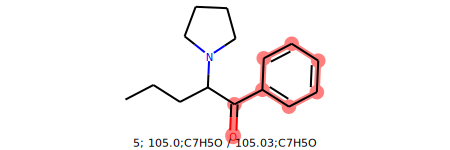

Displaying fragments frozenset({4, 6, 7, 8, 9, 10, 11})


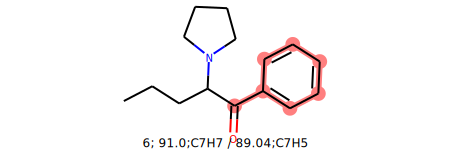

Displaying parent structure frozenset({4, 6, 7, 8, 9, 10, 11})
Fragmentation_graph_sets_edge[]


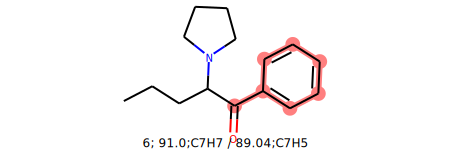

Displaying parent structure frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16})
Fragmentation_graph_sets_edge[[1, 1, 331.0, 'C4H8N']]


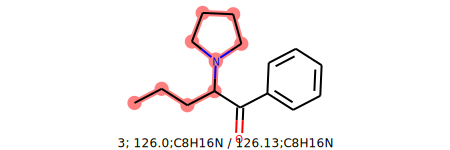

Displaying fragments frozenset({16, 12, 13, 14, 15})


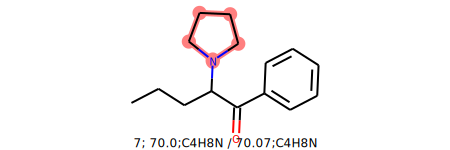

Displaying parent structure frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})
Fragmentation_graph_sets_edge[[2, 3, 1394.0, 'C8H16N'], [2, 3, 1568.0, 'C8H16N'], [2, 3, 1568.0, 'C8H16N'], [1, 1, 331.0, 'C8H7O'], [1, 1, 368.0, 'C7H5O'], [2, 2, 1100.0, 'C7H7'], [1, 1, 331.0, 'C4H8N']]


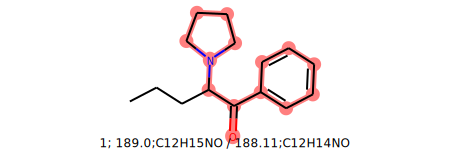

Displaying fragments frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12})
dddddddddddddddd


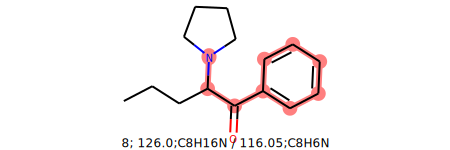

Displaying fragments frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16})
dddddddddddddddd


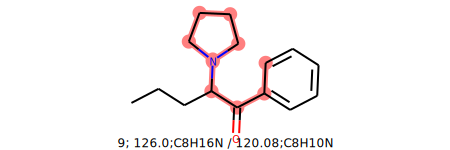

Displaying fragments frozenset({3, 4, 6, 7, 12, 13, 14, 15, 16})
dddddddddddddddd


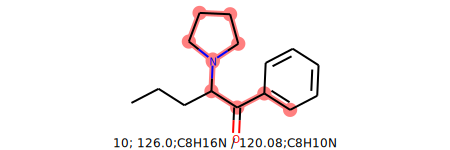

Displaying fragments frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})


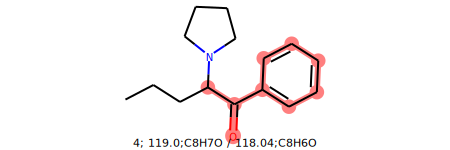

Displaying fragments frozenset({4, 5, 6, 7, 8, 9, 10, 11})


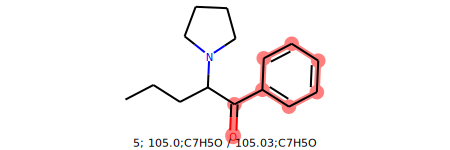

Displaying fragments frozenset({4, 6, 7, 8, 9, 10, 11})


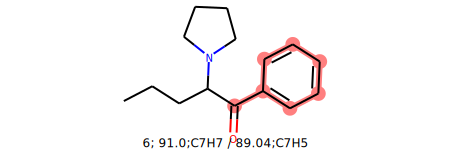

Displaying fragments frozenset({16, 12, 13, 14, 15})


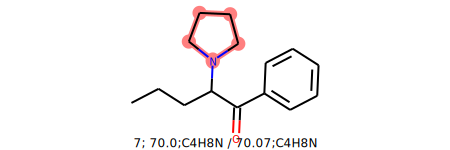

Displaying parent structure frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})
Fragmentation_graph_sets_edge[[1, 1, 368.0, 'C7H5O'], [2, 2, 1100.0, 'C7H7']]


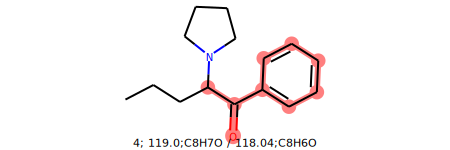

Displaying fragments frozenset({4, 5, 6, 7, 8, 9, 10, 11})


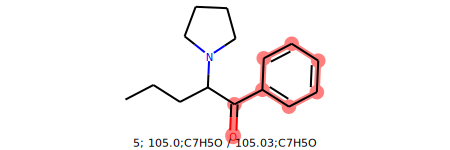

Displaying fragments frozenset({4, 6, 7, 8, 9, 10, 11})


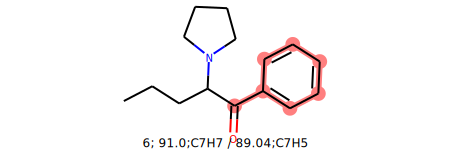

Displaying parent structure frozenset({16, 12, 13, 14, 15})
Fragmentation_graph_sets_edge[]


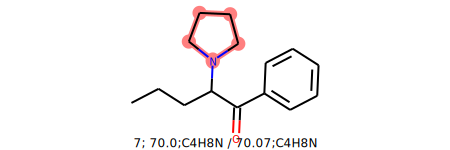

Displaying parent structure frozenset({4, 5, 6, 7, 8, 9, 10, 11})
Fragmentation_graph_sets_edge[[1, 1, 732.0, 'C7H7']]


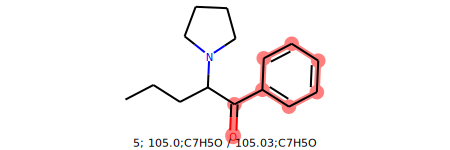

Displaying fragments frozenset({4, 6, 7, 8, 9, 10, 11})


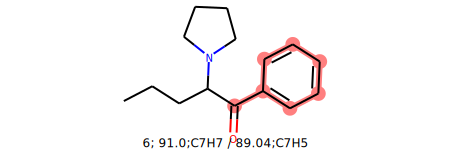

Displaying parent structure frozenset({3, 4, 6, 7, 12, 13, 14, 15, 16})
Fragmentation_graph_sets_edge[[1, 1, 331.0, 'C4H8N']]


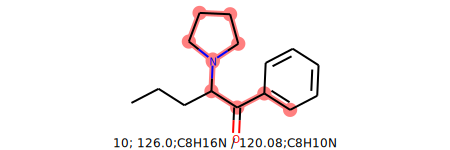

Displaying fragments frozenset({16, 12, 13, 14, 15})


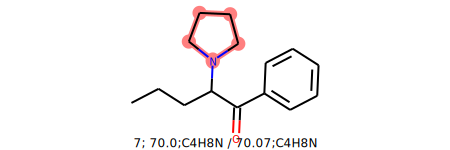

Displaying parent structure frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16})
Fragmentation_graph_sets_edge[[1, 1, 331.0, 'C4H8N']]


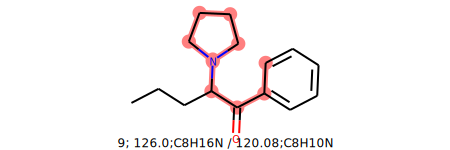

Displaying fragments frozenset({16, 12, 13, 14, 15})


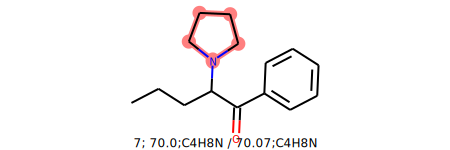

Displaying parent structure frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12})
Fragmentation_graph_sets_edge[[1, 1, 368.0, 'C7H7'], [1, 2, 836.0, 'C4H8N'], [1, 2, 836.0, 'C4H8N']]


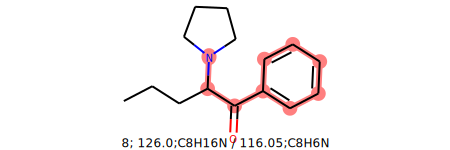

Displaying fragments frozenset({4, 6, 7, 8, 9, 10, 11})


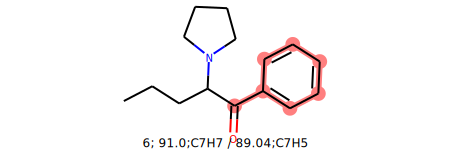

Displaying fragments frozenset({3, 4, 6, 11, 12})
dddddddddddddddd


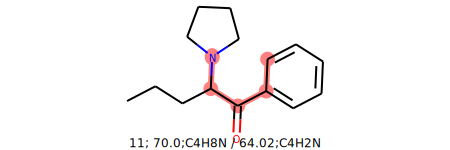

Displaying fragments frozenset({3, 4, 6, 7, 12})
dddddddddddddddd


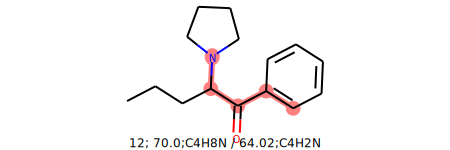

Displaying parent structure frozenset({3, 4, 6, 7, 12})
Fragmentation_graph_sets_edge[]


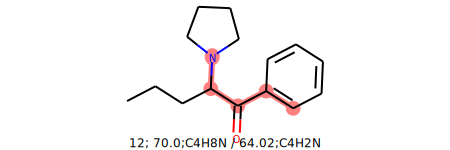

Displaying parent structure frozenset({3, 4, 6, 11, 12})
Fragmentation_graph_sets_edge[]


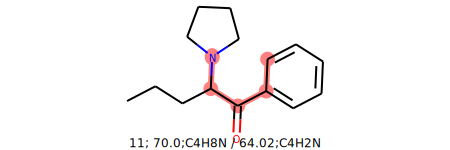

{('0', '3'), ('8', '6'), ('8', '12'), ('4', '6'), ('2', '5'), ('8', '11'), ('1', '9'), ('0', '6'), ('1', '4'), ('1', '5'), ('0', '2'), ('1', '7'), ('2', '6'), ('0', '1'), ('1', '10'), ('0', '7'), ('1', '8'), ('2', '4'), ('9', '7'), ('10', '7'), ('4', '5'), ('1', '6'), ('0', '4'), ('0', '5'), ('3', '7'), ('5', '6')}
1.3076923076923077 1.5 17294.0
1.0
frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})
frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})
frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})
frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16})
frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12})
frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16})
frozenset({3, 4, 6, 7, 12, 13, 14, 15, 16})
frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})
frozenset({4, 5, 6, 7, 8, 9, 10, 11})
frozenset({4, 6, 7, 8, 9, 10, 11})
frozenset({16, 12, 13, 14, 15})
frozenset({3, 4, 6, 11, 12})
frozenset({3, 4, 6, 7, 12})
frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})
frozenset({3, 4, 5,

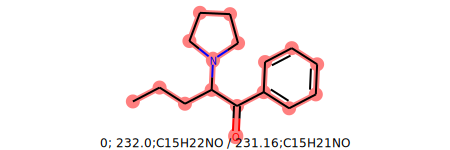

Displaying fragments frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})
dddddddddddddddd
C12NO


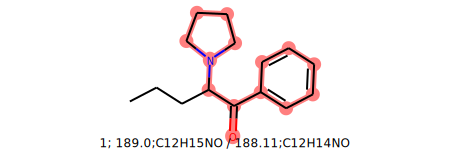

Displaying fragments frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})
dddddddddddddddd
C11O


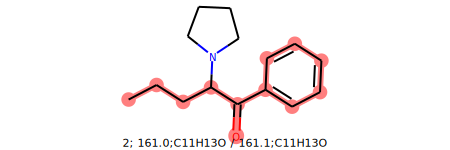

Displaying fragments frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16})
dddddddddddddddd
C8N


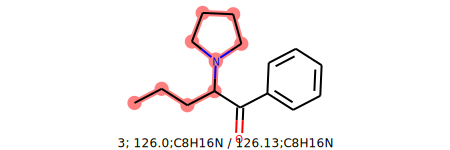

Displaying fragments frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})
dddddddddddddddd
C8O


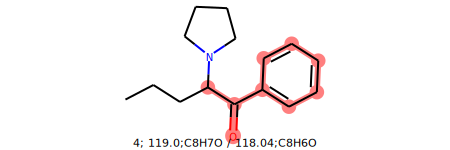

Displaying fragments frozenset({4, 5, 6, 7, 8, 9, 10, 11})
dddddddddddddddd
C7O


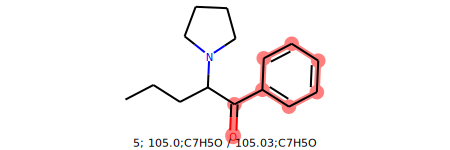

Displaying fragments frozenset({4, 6, 7, 8, 9, 10, 11})
dddddddddddddddd
C7


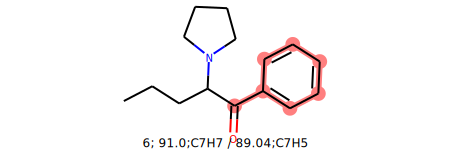

Displaying fragments frozenset({16, 12, 13, 14, 15})
dddddddddddddddd
C4N


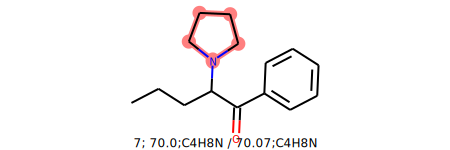

Displaying parent structure frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})
Fragmentation_graph_sets_edge[[1, 1, 368.0, 'C8H7O'], [1, 1, 368.0, 'C7H5O'], [2, 2, 1100.0, 'C7H7']]


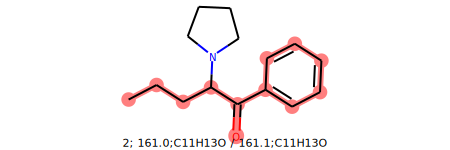

Displaying fragments frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})


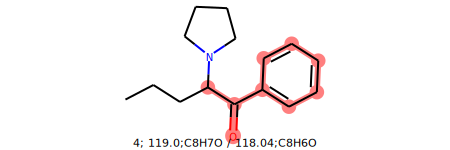

Displaying fragments frozenset({4, 5, 6, 7, 8, 9, 10, 11})


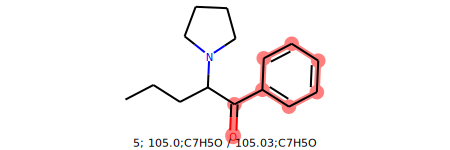

Displaying fragments frozenset({4, 6, 7, 8, 9, 10, 11})


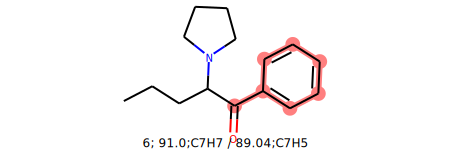

Displaying parent structure frozenset({4, 6, 7, 8, 9, 10, 11})
Fragmentation_graph_sets_edge[]


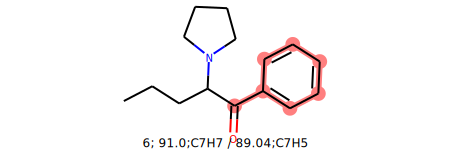

Displaying parent structure frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16})
Fragmentation_graph_sets_edge[[1, 1, 331.0, 'C4H8N']]


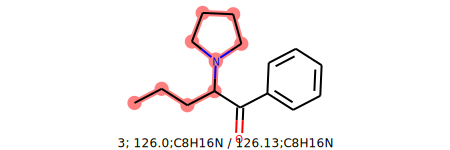

Displaying fragments frozenset({16, 12, 13, 14, 15})


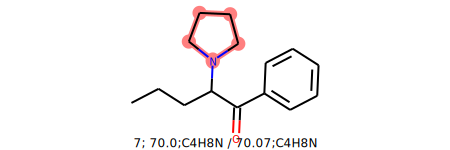

Displaying parent structure frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})
Fragmentation_graph_sets_edge[[2, 3, 1394.0, 'C8H16N'], [2, 3, 1568.0, 'C8H16N'], [2, 3, 1568.0, 'C8H16N'], [1, 1, 331.0, 'C8H7O'], [1, 1, 368.0, 'C7H5O'], [2, 2, 1100.0, 'C7H7'], [1, 1, 331.0, 'C4H8N']]


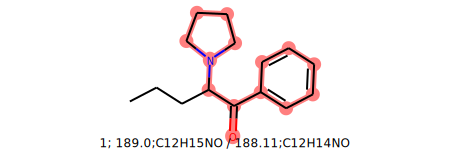

Displaying fragments frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12})
dddddddddddddddd
C8N


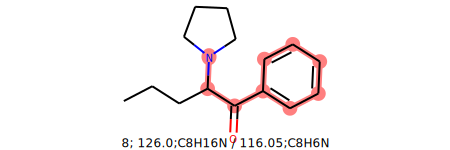

Displaying fragments frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16})
dddddddddddddddd
C8N


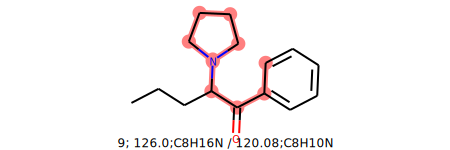

Displaying fragments frozenset({3, 4, 6, 7, 12, 13, 14, 15, 16})
dddddddddddddddd
C8N


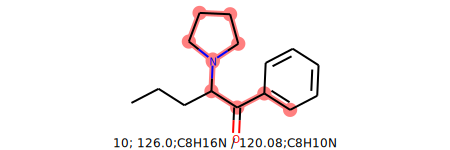

Displaying fragments frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})


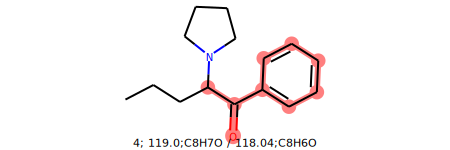

Displaying fragments frozenset({4, 5, 6, 7, 8, 9, 10, 11})


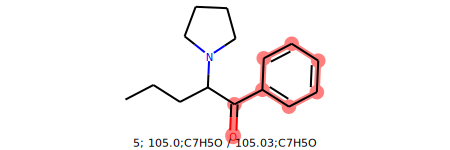

Displaying fragments frozenset({4, 6, 7, 8, 9, 10, 11})


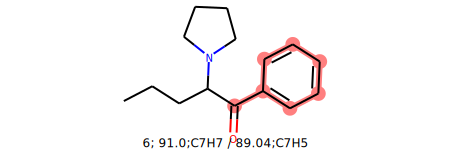

Displaying fragments frozenset({16, 12, 13, 14, 15})


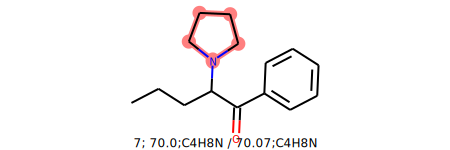

Displaying parent structure frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})
Fragmentation_graph_sets_edge[[1, 1, 368.0, 'C7H5O'], [2, 2, 1100.0, 'C7H7']]


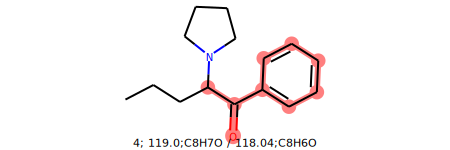

Displaying fragments frozenset({4, 5, 6, 7, 8, 9, 10, 11})


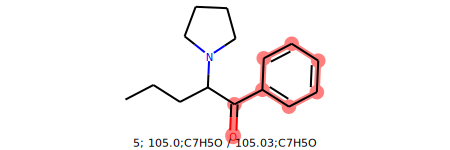

Displaying fragments frozenset({4, 6, 7, 8, 9, 10, 11})


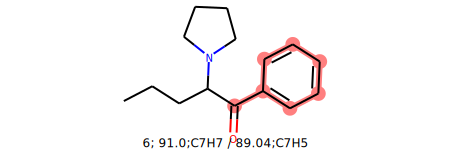

Displaying parent structure frozenset({16, 12, 13, 14, 15})
Fragmentation_graph_sets_edge[]


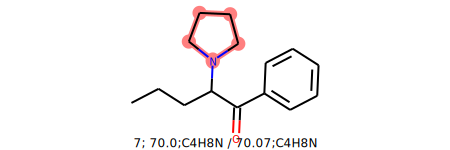

Displaying parent structure frozenset({4, 5, 6, 7, 8, 9, 10, 11})
Fragmentation_graph_sets_edge[[1, 1, 732.0, 'C7H7']]


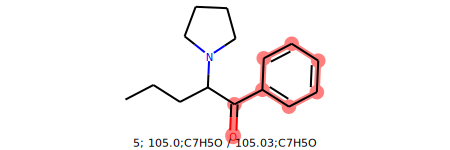

Displaying fragments frozenset({4, 6, 7, 8, 9, 10, 11})


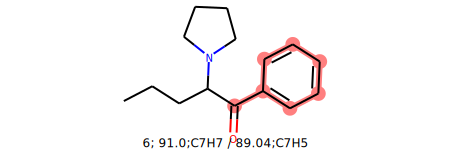

Displaying parent structure frozenset({3, 4, 6, 7, 12, 13, 14, 15, 16})
Fragmentation_graph_sets_edge[[1, 1, 331.0, 'C4H8N']]


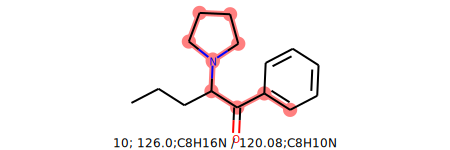

Displaying fragments frozenset({16, 12, 13, 14, 15})


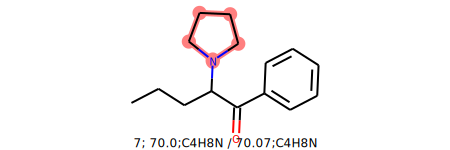

Displaying parent structure frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16})
Fragmentation_graph_sets_edge[[1, 1, 331.0, 'C4H8N']]


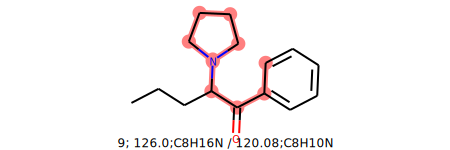

Displaying fragments frozenset({16, 12, 13, 14, 15})


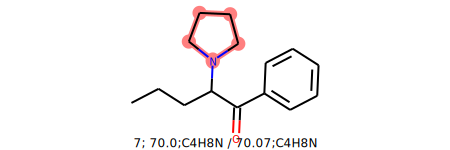

Displaying parent structure frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12})
Fragmentation_graph_sets_edge[[1, 1, 368.0, 'C7H7'], [1, 2, 836.0, 'C4H8N'], [1, 2, 836.0, 'C4H8N']]


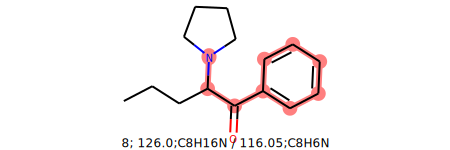

Displaying fragments frozenset({4, 6, 7, 8, 9, 10, 11})


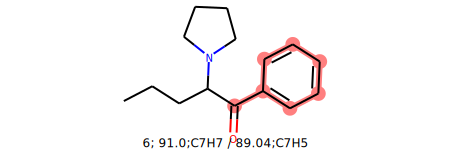

Displaying fragments frozenset({3, 4, 6, 11, 12})
dddddddddddddddd
C4N


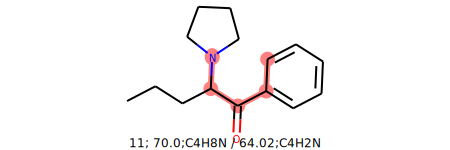

Displaying fragments frozenset({3, 4, 6, 7, 12})
dddddddddddddddd
C4N


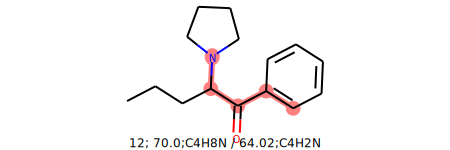

Displaying parent structure frozenset({3, 4, 6, 7, 12})
Fragmentation_graph_sets_edge[]


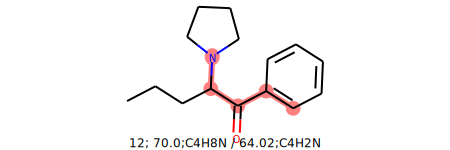

Displaying parent structure frozenset({3, 4, 6, 11, 12})
Fragmentation_graph_sets_edge[]


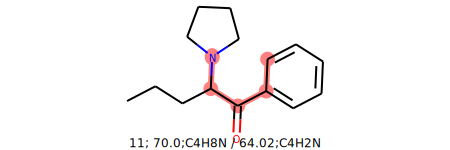

{('0', '3'), ('8', '6'), ('8', '12'), ('4', '6'), ('2', '5'), ('8', '11'), ('1', '9'), ('0', '6'), ('1', '4'), ('1', '5'), ('0', '2'), ('1', '7'), ('2', '6'), ('0', '1'), ('1', '10'), ('0', '7'), ('1', '8'), ('2', '4'), ('9', '7'), ('10', '7'), ('4', '5'), ('1', '6'), ('0', '4'), ('0', '5'), ('3', '7'), ('5', '6')}
1.3076923076923077 1.5 17294.0
1.0
frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})
frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})
frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})
frozenset({0, 1, 2, 3, 12, 13, 14, 15, 16})
frozenset({3, 4, 6, 7, 8, 9, 10, 11, 12})
frozenset({3, 4, 6, 11, 12, 13, 14, 15, 16})
frozenset({3, 4, 6, 7, 12, 13, 14, 15, 16})
frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11})
frozenset({4, 5, 6, 7, 8, 9, 10, 11})
frozenset({4, 6, 7, 8, 9, 10, 11})
frozenset({16, 12, 13, 14, 15})
frozenset({3, 4, 6, 11, 12})
frozenset({3, 4, 6, 7, 12})
frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})
frozenset({3, 4, 5,

In [ ]:
#########################
# 28.09.2020 generating trees for set of molecules. 
# Input - folder with execel files for each molecule
#
##########################

size_x=450 
size_y=150

Number_of_levels=3             #2
Breaking_bonds_max = 4         #3
Remaining_fragments_max = 3    #2

Dir_with_input_files="MolRearrangment"
Dir_with_input_files="Doxo"

output_path="C:\\Users\\Public\\Data_for_trees_1\\" # No spaces in path!!!!!!!

# Get names of files files
Files_in_Dir=os.listdir(Dir_with_input_files+"//")

for file_name in Files_in_Dir:
    # Or read fragmentation data from file
    Fragment_data=pd.read_excel(Dir_with_input_files+"//"+file_name)
    
    # Remove fragments with low intensity
    Fragment_data.loc[(Fragment_data["mz"]==max(Fragment_data["mz"])),"Intensity"]=+12
    Fragment_data=Fragment_data[Fragment_data["Intensity"]>10]
    Fragment_data=Fragment_data.reset_index()
    
    #
    for elem in Fragment_data['formula']:
        Fragment_data.loc[Fragment_data['formula']==elem,'formula']=molmassFormula(elem).formula
    
    #name=f5(Fragment_data['name'])[0]
    name=file_name.split('.')[0]
    
    Molecular_Smiles=f5(Fragment_data['Molecular_Smiles'])[0]
    Normalized_collision_Energy=f5(Fragment_data['NCE'])[0]

    Fragment_data["formulaNoH"]=[re.sub("H\d*", "", i) for i in Fragment_data["formula"]]

    mol = Chem.MolFromSmiles(Molecular_Smiles)
    Molecular_Formula=Chem.rdMolDescriptors.CalcMolFormula(mol,True)

    # Set unchangeble properties to atoms
    for a in range(len(mol.GetAtoms())):
        mol.GetAtomWithIdx(a).SetProp('pi',str(a))

    set_bond_energy(mol)

    Check_input_data (Fragment_data)

    os.mkdir(output_path+name+'\\')#
    os.mkdir(output_path+name+'\\'+'\\Fig\\')
    path_to_pictures=output_path+name+'\\'


    ##########################################################

    Generated_data=Calculate_fragmentation_tree (mol,Number_of_levels,Fragment_data, Breaking_bonds_max, Remaining_fragments_max)

    Draw_tree_data = Draw_tree (mol,Fragment_data,Generated_data[0],Generated_data[1],path_to_pictures,Number_of_levels)
    
    try:
        check_call(['dot','-Tpng',output_path+name+'\\'+'For_Graphviz.txt','-o',output_path+name+'\\'+'Graph.png'])
    except subprocess.CalledProcessError:
        print ("Exaption")
        
    Fragment_data.to_excel(output_path+name+'\\'+file_name)  

    ###############################################################
    #
    #
    #
    ################################################################
    
    Draw_tree_data=Generate_Fragments_Id (mol,Fragment_data,Generated_data[0],Generated_data[1],path_to_pictures,DropIsotopes=True)
    Draw_Graph_For_GraphViz_output=Draw_Graph_For_GraphViz (Draw_tree_data[0],Draw_tree_data[1],Draw_tree_data[2],Generated_data[0],Generated_data[1])
    G=Draw_Graph_For_GraphViz_output[0]
    G1=Set_mass_differences_to_esges(G)
    Rewrite_for_Graphviz(output_path,name,G1)
    check_call(['dot','-Tpng',output_path+name+'\\'+'For_Graphviz_mass_diff.txt','-o',output_path+name+'\\'+'Graph_mass_diff.png'])


In [54]:
Fragments_Id=Draw_tree_data[0]
All_Edges_description_Id=Draw_tree_data[2]

In [97]:
G.nodes['0']
for a in list(G1.edges):
    print(a)
    print(G1.get_edge_data(*a))
    Diff_data=G1.get_edge_data(*a)['f1_minus_f2_DatFrame']


('0', '6')
{'nr': '2', 'bb': ' 2', 'f1_minus_f2_DatFrame':   element  number
0       C     1.0
1       H     2.0
2       O     1.0}
('0', '4')
{'nr': '1', 'bb': ' 2', 'f1_minus_f2_DatFrame':   element  number
0       C     2.0
1       H     2.0}
('0', '8')
{'nr': '1', 'bb': ' 2', 'f1_minus_f2_DatFrame':   element  number
0       C     3.0
1       H     4.0
2       O     1.0}
('0', '3')
{'nr': '1', 'bb': ' 2', 'f1_minus_f2_DatFrame':   element  number
0       C     2.0
1       H     2.0}
('0', '2')
{'nr': '1', 'bb': ' 2', 'f1_minus_f2_DatFrame':   element  number
0       C     2.0
1       H     2.0}
('0', '5')
{'nr': '1', 'bb': ' 2', 'f1_minus_f2_DatFrame':   element  number
0       C     2.0
1       H     2.0}
('0', '7')
{'nr': '1', 'bb': ' 1', 'f1_minus_f2_DatFrame':   element  number
0       C     2.0
1       H     2.0
2       O     1.0}
('0', '1')
{'nr': '1', 'bb': ' 1', 'f1_minus_f2_DatFrame':   element  number
0       O     1.0}
('1', '1')
{'nr': '0', 'bb': ' 0', 'f1_minus_f2_DatF

In [ ]:
#####################################################################################
# !!!!!!!!!!!!!!!!!!
# SRART EXAMPLE
# !!!!!!!!!!!!!!!!!!
# Generate fragmenatation tree for set of molecules
# Mix SMILES and ions
#
######################################################################################


In [ ]:
#########################
# 13.05.2020 generating isomers for mefedron. 
# Input - folder with execel files for each molecule
# 
# Interchange!!!!!!!!!!
# Mix SMILES and ions
#
##########################


size_x=450 
size_y=150

Number_of_levels=2
Breaking_bonds_max = 3 
Remaining_fragments_max = 2

output_path="C:\\Users\\Public\\Meph_AND\\" # No spaces in path!!!!!!!

# Get names of files files
Files_in_Dir=os.listdir("Mephedrone_//")

Index_DataFrame=pd.DataFrame(0,columns = Files_in_Dir, index=Files_in_Dir)

for file_name1 in Files_in_Dir:
    for file_name2 in Files_in_Dir:
       
    # Or read fragmentation data from file
        Fragment_data=pd.read_excel("Mephedrone_//"+file_name1)
        
        Fragment_data2=pd.read_excel("Mephedrone_//"+file_name2)

        # Remove fragments with low intensity
        Intensity_min=5
        Fragment_data.loc[(Fragment_data["mz"]==178.12),"Intensity"]+=Intensity_min
        Fragment_data=Fragment_data[Fragment_data["Intensity"]>Intensity_min]
        Fragment_data=Fragment_data.reset_index()
        
        # Construct name
        name=f5(Fragment_data['name'])[0]+"_AND_"+f5(Fragment_data2['name'])[0]
        
        # Take SMILES from Fragment_data2
        Molecular_Smiles=f5(Fragment_data2['Molecular_Smiles'])[0]
        Normalized_collision_Energy=f5(Fragment_data['NCE'])[0]

        Fragment_data["formulaNoH"]=[re.sub("H\d*", "", i) for i in Fragment_data["formula"]]

        mol = Chem.MolFromSmiles(Molecular_Smiles)
        Molecular_Formula=Chem.rdMolDescriptors.CalcMolFormula(mol,True)

        # Set unchangeble properties to atoms
        for a in range(len(mol.GetAtoms())):
            mol.GetAtomWithIdx(a).SetProp('pi',str(a))

        set_bond_energy(mol)

        Check_input_data (Fragment_data)

        os.mkdir(output_path+name+'\\')#
        os.mkdir(output_path+name+'\\'+'\\Fig\\')
        path_to_pictures=output_path+name+'\\'


        ##########################################################

        Generated_data=Calculate_fragmentation_tree (mol,Number_of_levels,Fragment_data, Breaking_bonds_max, Remaining_fragments_max)
        
        Draw_tree_data = Draw_tree (mol,Fragment_data,Generated_data[0],Generated_data[1],path_to_pictures,Number_of_levels)
        check_call(['dot','-Tpng',output_path+name+'\\'+'For_Graphviz.txt','-o',output_path+name+'\\'+'Graph.png'])

        Index_DataFrame[file_name2] = Index_DataFrame[file_name2].astype('object')
        Index_DataFrame.at[file_name1,file_name2]=[[i for i in Draw_tree_data[2].values()][j] for j in [7,8]]

        


In [ ]:
####
# Calculate index for heatmap

Index_DataFrame_1=copy.deepcopy(Index_DataFrame)
for i in range(len(Index_DataFrame_1)):
    for j in range(len(Index_DataFrame_1)):
        Index_DataFrame_1.iloc[i,j]=round(Index_DataFrame.iloc[i,j][1]/Index_DataFrame.iloc[i,j][0],2)


        Index_DataFrame_1
        
###################
#
# Remove .xlsx from col and row names and plot heatmap
#
########

Index_DataFrame_1 = Index_DataFrame_1.rename(columns=lambda x: x.split('.')[0])
Index_DataFrame_1 = Index_DataFrame_1.rename(index=lambda x: x.split('.')[0])

ax = sns.heatmap(Index_DataFrame_1.apply(pd.to_numeric, errors='coerce'),annot=True,fmt='.1f')

In [ ]:
#####################################################################################
# !!!!!!!!!!!!!!!!!!
# SRART EXAMPLE
# !!!!!!!!!!!!!!!!!!
# 17.05.2020 Read folders with fragmentation trees and create lists of graphs, smiles, folrulas etc.
#
######################################################################################


In [ ]:
############
#
# 17.05.2020 Read folders with fragmentation trees and create lists of graphs, smiles, folrulas etc.
#
#########


size_x=450 
size_y=150

name_of_folder_with_trees='Generated_Data_for_trees_1'

Files_in_dir=os.listdir(name_of_folder_with_trees)
Molecular_names=list(filter(re.compile("(?!.*\.)").match, Files_in_dir)) # Read Note

Smiles_list=[]
Fragment_formulas_list=[]
Mz_list_list=[]
Fragmentation_graph_sets_list=[]
Fragments_Id_list=[]
Fragment_data_list=[]

for Molecule_folder_name in Molecular_names:
    Files_in_dir=os.listdir(name_of_folder_with_trees+"//"+Molecule_folder_name)
    
    
    Fragment_data=pd.read_excel(name_of_folder_with_trees+"//"+Molecule_folder_name+"//"+Molecule_folder_name+'.xlsx')
    
    Molecular_Smiles=f5(Fragment_data['Molecular_Smiles'])[0]
    
    Fragment_formulas=Fragment_data['formula']
    
    Mz_list=Fragment_data['mz']
    
    #Folders_in_dir=list(filter(re.compile("(?!.*\.)").match, Files_in_dir))
    #Folder_with_txt_name=list(filter(re.compile("(?!Fig)").match, Folders_in_dir))[0]
    
    file1 = open(name_of_folder_with_trees+"//"+Molecule_folder_name+"\\"+'Fragmentation_graph_sets.txt', 'r') 
    Lines = file1.readline() 
    Fragmentation_graph_sets=eval(Lines)

    Fragments_Id=pd.read_table(name_of_folder_with_trees+"//"+Molecule_folder_name+"\\"+'Fragments_Id.txt',delimiter='\t',index_col=0) 


    Smiles_list.append(Molecular_Smiles)
    Fragment_formulas_list.append(Fragment_formulas)
    Mz_list_list.append(Mz_list)
    Fragmentation_graph_sets_list.append(Fragmentation_graph_sets)
    Fragments_Id_list.append(Fragments_Id)
    Fragment_data_list.append(Fragment_data)
    
print(Molecule_folder_name)

In [ ]:
########################################################
#
# Analyze fragments in all folders.
# Combine fragments in DataFrame
#
########################################################
import json

Fragments_inchi=pd.DataFrame()
Fragments_smiles=pd.DataFrame()

Fragments_all=pd.DataFrame()


for mol_index in range(len(Smiles_list)):

    # Get molecules
    Molecular_Smiles=Smiles_list[mol_index]
    Fragment_formulas=    Fragment_formulas_list[mol_index]
    Mz_list=    Mz_list_list[mol_index]
    Fragmentation_graph_sets=    Fragmentation_graph_sets_list[mol_index]
    Fragments_Id=    Fragments_Id_list[mol_index]
    Fragment_data=Fragment_data_list[mol_index]

    mol = Chem.MolFromSmiles(Molecular_Smiles)
    Molecular_Formula=Chem.rdMolDescriptors.CalcMolFormula(mol,True)

    Parent_mol = Chem.MolFromSmiles(Molecular_Smiles)

    # Set unchangeble properties to atoms
    for a in range(len(Parent_mol.GetAtoms())):
        Parent_mol.GetAtomWithIdx(a).SetProp('pi',str(a))
        
    # Map Atom Numbers
    [a.SetProp('molAtomMapNumber',str(i)) for i,a in enumerate(Parent_mol.GetAtoms())]


    for parent in Fragmentation_graph_sets:

        Remaining_mol=set([i for i in range(len(Parent_mol.GetAtoms()))])-parent
        ################
        mol_parent = Chem.RWMol(Parent_mol)
        for idx in sorted(list(Remaining_mol), reverse=True):
            mol_parent.RemoveAtom(idx)
        try:
            parent_inchi=Chem.inchi.MolToInchi(mol_parent)
        except ValueError:
            parent_inchi=""

        parent_smiles=Chem.rdmolfiles.MolToSmiles(mol_parent)

        for frag in Fragmentation_graph_sets[parent]:
            Remaining_mol=set([i for i in range(len(Parent_mol.GetAtoms()))])-frag
            ################
            mol_fragment = Chem.RWMol(Parent_mol)
            for idx in sorted(list(Remaining_mol), reverse=True):
                mol_fragment.RemoveAtom(idx)

            lost_fragment=(parent-frag)
            Remaining_mol=set([i for i in range(len(Parent_mol.GetAtoms()))])-lost_fragment
            ################
            mol_lost_fragment = Chem.RWMol(Parent_mol)
            for idx in sorted(list(Remaining_mol), reverse=True):
                mol_lost_fragment.RemoveAtom(idx)
            try:
                fragment_inchi=Chem.inchi.MolToInchi(mol_fragment)
            except ValueError:
                fragment_inchi=""
            try:
                lost_fragment_inchi=Chem.inchi.MolToInchi(mol_lost_fragment)
            except ValueError:
                lost_fragment_inchi=""              
            #Chem.Kekulize(mol_lost_fragment)

            fragment_smiles=Chem.rdmolfiles.MolToSmiles(mol_fragment)
            lost_fragment_smiles=Chem.rdmolfiles.MolToSmiles(mol_lost_fragment)
                    
            Nummber_of_remaining_fragments = validate_connectivity(mol_parent,frag,True)

            Bonds_between_fr_and_restofmol=0
            breaking_bonds_list=[]
            for fr_atom in frag:
                for mol_atom in lost_fragment:
                    bond=Parent_mol.GetBondBetweenAtoms(fr_atom,mol_atom)
                    if bond !=None:
                        Bonds_between_fr_and_restofmol=Bonds_between_fr_and_restofmol+1
                        begin = bond.GetBeginAtom()
                        end   = bond.GetEndAtom()
                        breaking_bonds_list.append([begin.GetProp('pi'),end.GetProp('pi')])

            Fragments_inchi=Fragments_inchi.append(pd.DataFrame({'parent':[parent_inchi],'fragment':[fragment_inchi],'lost':[lost_fragment_inchi],'nr':[Nummber_of_remaining_fragments],"bb=":[Bonds_between_fr_and_restofmol]}),ignore_index=True)
            Fragments_smiles=Fragments_smiles.append(pd.DataFrame({'initial':[Molecular_Smiles],'parent':[parent_smiles],'pa':[parent],'fragment':[fragment_smiles],'fa':[frag],'lost':[lost_fragment_smiles],'la':[lost_fragment],'nr':[Nummber_of_remaining_fragments],"bb":[Bonds_between_fr_and_restofmol],'bbind':[breaking_bonds_list]}),ignore_index=True)
            bb_json=json.dumps(breaking_bonds_list)
            Fragments_smiles=Fragments_smiles.append(pd.DataFrame({'initial':[Molecular_Smiles],'parent':[parent_smiles],'pa':[parent],'fragment':[fragment_smiles],'fa':[frag],'lost':[lost_fragment_smiles],'la':[lost_fragment],'nr':[Nummber_of_remaining_fragments],"bb":[Bonds_between_fr_and_restofmol],'bbind':[bb_json]}),ignore_index=True)

            Fragments_all=Fragments_all.append(pd.DataFrame({'initial':[Molecular_Smiles],'parent_s':[parent_smiles],'parent_i':[parent_inchi],'pa':[parent],'fragment_s':[fragment_smiles],'fragment_i':[fragment_inchi],'fa':[frag],'lost_s':[lost_fragment_smiles],'lost_i':[lost_fragment_inchi],'la':[lost_fragment],'nr':[Nummber_of_remaining_fragments],"bb":[Bonds_between_fr_and_restofmol],'bbind':[breaking_bonds_list]}),ignore_index=True)

            
            print("Parent smiles",parent_smiles,"fragment smiles",fragment_smiles,"Name",Molecular_names[mol_index])
            m1=Chem.MolFromSmiles(lost_fragment_smiles)
            if (m1!=None):
                display(SVG(Gererate_SVG(m1,"nr="+str(Nummber_of_remaining_fragments)+', bb='+str(Bonds_between_fr_and_restofmol),set(),Fragment_data)))
        
        


In [ ]:
Fragments_smiles
Fragments_smiles.to_csv('Fragments_smiles_NEW.txt', sep='\t')

In [ ]:
################################################
# 
# Order fragments
#
#################################################

Fragments_unique_lost_inchi=list(Counter(Fragments_all["lost_i"]).keys()) # equals to list(set(words))
Fragments_unique_lost_counter=list(Counter(Fragments_all["lost_i"]).values()) # counts the elements' frequency

Fragment_unique_inchi=pd.DataFrame({"inchi":Fragments_unique_lost_inchi,"counter":Fragments_unique_lost_counter})
Fragment_unique_inchi=Fragment_unique_inchi.sort_values(by=['counter'],ascending=False)
Fragment_unique_inchi = Fragment_unique_inchi.reset_index(drop=True)

Fragments_unique_lost_smiles=list(Counter(Fragments_all["lost_s"]).keys()) # equals to list(set(words))
Fragments_unique_lost_counter_s=list(Counter(Fragments_all["lost_s"]).values()) # counts the elements' frequency

Fragment_unique_smiles=pd.DataFrame({"smiles":Fragments_unique_lost_smiles,"counter":Fragments_unique_lost_counter_s})
Fragment_unique_smiles=Fragment_unique_smiles.sort_values(by=['counter'],ascending=False)
Fragment_unique_smiles = Fragment_unique_smiles.reset_index(drop=True)

for i in range(len(Fragments_unique_lost_inchi)):
    m1=Chem.inchi.MolFromInchi(Fragment_unique_inchi["inchi"][i])
    if (Fragment_unique_inchi["inchi"][i]!=""):
        display(SVG(Gererate_SVG(m1,str(Fragment_unique_inchi["counter"][i]),set())))

In [ ]:
# Show sorted smiles of lost fragments

Fragment_unique_smiles=Fragment_unique_smiles[Fragment_unique_smiles['smiles']!='']

with pd.option_context("display.max_rows", 1000):
    display(Fragment_unique_smiles)

In [ ]:
# Plot fragments and highlitght loss
# For all molecules (initial and parent) loosing specific group (smiles_1) show and highlight fragmentation

for smiles_1 in Fragment_unique_smiles['smiles']:

    Fragments_all_1=Fragments_all[Fragments_all['lost_s']==smiles_1]
    Fragments_all_1

    for idx in range(len(Fragments_all_1)):
        Fragments_all_1_idx=Fragments_all_1.iloc[idx]
        Parent_mol=Chem.MolFromSmiles(Fragments_all_1_idx['initial'])

        # Set unchangeble properties to atoms
        for a in range(len(Parent_mol.GetAtoms())):
            Parent_mol.GetAtomWithIdx(a).SetProp('pi',str(a))

        Remaining_mol=set([i for i in range(len(Parent_mol.GetAtoms()))])-Fragments_all_1_idx['pa']
        ################
        mol_fragment = Chem.RWMol(Parent_mol)
        for idx in sorted(list(Remaining_mol), reverse=True):
            mol_fragment.RemoveAtom(idx)

        For_highlight=pd.DataFrame({'pa':[mol_fragment.GetAtomWithIdx(a).GetProp('pi') for a in range(len(mol_fragment.GetAtoms()))],'local_a':[i for i in range(len(mol_fragment.GetAtoms()))]})
        highlight=set(For_highlight['local_a'][[(int(q) in Fragments_all_1_idx['la']) for q in For_highlight['pa']]])

        svg=Gererate_SVG(mol_fragment,str(Fragment_unique_inchi["counter"][i]),highlight)
        if svg!=False:
            display(SVG(svg))

In [ ]:
#####################################################################################
# !!!!!!!!!!!!!!!!!!
# SRART EXAMPLE
# !!!!!!!!!!!!!!!!!!
# 18.05.2020 Analysis of real and possible fragmentation
#
######################################################################################


In [ ]:
####################################
#
# 18.05.2020 Analysis of real and possible fragmentation
#
# For each initial molecule
# For each parent molecule
# Get experimental loss
# For each possible loss (from Selected_Smiles) check possibility
#
####################################

Number_of_levels=0
Breaking_bonds_max = 3 
Remaining_fragments_max = 2

Selected_and_tested_dataframe=pd.DataFrame()

Selected_Smiles_list=Fragment_unique_smiles[0:30]
Selected_Smiles=Selected_Smiles_list.iloc[0]['smiles']

initial_molecule_list=f5(Fragments_all['initial'])
initial_molecule=initial_molecule_list[0]

for initial_molecule in initial_molecule_list:

    parent_molecule_list=f5(Fragments_all[Fragments_all['initial']==initial_molecule]['pa'])
    parent_molecule=parent_molecule_list[0]

    for parent_molecule in parent_molecule_list:

        # experimental loss
        Fragments_all_parent_molecule=Fragments_all[((Fragments_all['initial']==initial_molecule) & (Fragments_all['pa']==parent_molecule))]
        print(Fragments_all_parent_molecule)
        
        experimental_loss=f5(Fragments_all_parent_molecule['lost_s'])

        # calculate theoretically possible loss

        Parent_mol=Chem.MolFromSmiles(initial_molecule)

        # Set unchangeble properties to atoms
        for a in range(len(Parent_mol.GetAtoms())):
            Parent_mol.GetAtomWithIdx(a).SetProp('pi',str(a))

        Remaining_mol=set([i for i in range(len(Parent_mol.GetAtoms()))])-parent_molecule #Fragments_all_Selected_Smiles_idx['pa']
        ################
        mol_fragment = Chem.RWMol(Parent_mol)
        for idx in sorted(list(Remaining_mol), reverse=True):
            mol_fragment.RemoveAtom(idx)

        # Check fragmentation possibility

        # Set unchangeble properties to atoms
        for a in range(len(mol_fragment.GetAtoms())):
            mol_fragment.GetAtomWithIdx(a).SetProp('pi',str(a))

        set_bond_energy(mol_fragment)
        print("Set bond energy")

        Possible_Smiles_list=[]

        for Tested_Smiles in Selected_Smiles_list['smiles']:
            print(Tested_Smiles)

            Tested_Smiles_Formula=molecular_formula_from_smiles(Tested_Smiles)

            Fragment_data=pd.DataFrame({"formula":[Tested_Smiles_Formula], "mz":[10]})
            Fragment_data["formulaNoH"]=[re.sub("H\d*", "", i) for i in Fragment_data["formula"]]
            Generated_Data=Calculate_fragmentation_tree (mol_fragment,Number_of_levels,Fragment_data, Breaking_bonds_max, Remaining_fragments_max)
            print(Generated_Data)

            if list(Generated_Data[1].values())[0]==[]:
                is_tested_fragmentation_possible=False
            else:
                is_tested_fragmentation_possible=True
                Possible_Smiles_list.append(Tested_Smiles)

        Selected_and_tested_dataframe=Selected_and_tested_dataframe.append(pd.DataFrame({"initial":[initial_molecule],'pa':[parent_molecule],"possible_f":[Possible_Smiles_list],'experimental_loss':[experimental_loss]}),ignore_index=True)    

In [ ]:
with pd.option_context("display.max_rows", 1000):
    display(Selected_and_tested_dataframe)

In [ ]:
#####################################################################################
# !!!!!!!!!!!!!!!!!!
# SRART EXAMPLE
# !!!!!!!!!!!!!!!!!!
# 18.05.2020 Predict fragmentation
#
######################################################################################

In [ ]:
data = pd.read_csv('Fragments_smiles_NEW.txt',delimiter='\t')
bonds = list(data.bbind.apply(lambda s:loads(s.replace('\'',''))))
mols = list(data.parent)
to_process = list(zip(mols,bonds))

#data[['parent','bbind']].groupby(by='parent')#.agg({'parent':lambda x:x,'bbind':lambda b:})
unique = {}
for mol,bonds in to_process:
    #print(bonds)
    if bonds == []: continue
    if mol not in unique: unique[mol] = []
    for bond in bonds:
        #print(bond)
        unique[mol].append(bond)
#print(unique)

check_bond_break([(k,v) for k,v in unique.items()])                    

In [ ]:
X,y = calc_descriptors(unique,with_global=False)

dtrain = xgb.DMatrix(np.asmatrix(X), label=y)

param = {'max_depth': 4, 'eta': 0.1, 'objective': 'binary:logistic','eval_metric':'aucpr','tree_method': 'gpu_hist'}
#xgb.cv(param, dtrain, num_boost_round=1000, nfold=5,verbose_eval=5)
model = xgb.train(param, dtrain, num_boost_round=1000)

pred = model.predict(dtrain)
sns.kdeplot(model.predict(dtrain),shade=True)
#model.predict(dtrain)

In [ ]:
#confusion_matrix(y,pred)
mol = Chem.MolFromSmiles("CCCC(C(=O)C1=CC2=C(C=C1)OCO2)N3CCCC3")

#mol = Chem.MolFromSmiles("CCN(CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl)CCO")
Molecular_Smiles="CN1C(CCC1=O)C2=CN=CC=C2"
mol = Chem.MolFromSmiles(Molecular_Smiles)


# Set unchangeble properties to atoms
for a in range(len(mol.GetAtoms())):
    mol.GetAtomWithIdx(a).SetProp('pi',str(a))

mol

a=Gererate_SVG(predict_for_a_molecule(mol))
display(SVG(a))
Parent_mol=mol
Parent_mol_set=frozenset(int(i.GetProp("pi")) for i in mol.GetAtoms())


In [ ]:
#####################################################################################
# !!!!!!!!!!!!!!!!!!
# SRART EXAMPLE
# !!!!!!!!!!!!!!!!!!
# 18.05.2020 Generate fragmentation tree for Predict fragmentation
#
######################################################################################

In [ ]:
############################################################
#
# Generate fragmentation tree for Predict fragmentation
# 
# Sometime it Can't kekulize mol. Anyway the tree is computed. Proceed with next cells.
#
############################################################

Min_prob_to_break=0.2
Number_of_levels=2

All_info_list_ini=(Parent_mol_set,tuple(frozenset()))
Fragmentation_graph_sets_btobraek={All_info_list_ini:[]}

for level in range (Number_of_levels):
    
    print("#\n#\n#"+"Level = "+str(level)+"#\n#\n#")

    # Get unique parent molecules
    Parent_fragments_set_btobraek=[list(Fragmentation_graph_sets_btobraek.keys())[0]]
    Parent_fragments_set_btobraek_val=list(chain.from_iterable(Fragmentation_graph_sets_btobraek.values()))
    if(Parent_fragments_set_btobraek_val!=[]):
        Parent_fragments_set_btobraek.extend(Parent_fragments_set_btobraek_val)

#    for mol_pi in Parent_fragments_set:
    for All_info_list in Parent_fragments_set_btobraek:
        
        print("All_info_list = "+str(All_info_list))
        
        mol_pi=All_info_list[0]
        mol_bonds_to_braek_pa=All_info_list[1]
        
        mol_bonds_to_braek=[]
        for idx in mol_bonds_to_braek_pa:
            to_break=list(idx)
            if to_break!=[]:
                try:
                    ba=mol.GetAtomWithIdx(to_break[0])
                except RuntimeError:
                    ba=''
                try:
                    ea=mol.GetAtomWithIdx(to_break[1])
                except RuntimeError:
                    ea=''

                if ((ba!='') & (ea!='')):
                    mol_bonds_to_braek.append([ba.GetIdx(),ea.GetIdx()])
            #mol_bonds_to_braek=f5(mol_bonds_to_braek)
            
        print("mol_bonds_to_braek = "+str(mol_bonds_to_braek)) 
        
        # Create fragment molecule
        Remaining_mol=set([i for i in range(len(Parent_mol.GetAtoms()))])-mol_pi
        ################
        mol = Chem.RWMol(Parent_mol)
        for idx in sorted(list(Remaining_mol), reverse=True):
            mol.RemoveAtom(idx)
        Chem.Kekulize(mol, clearAromaticFlags=True)
        
        for idx in mol_bonds_to_braek:
            try:
                mol.RemoveBond(idx[0],idx[1])
            except RuntimeError:
                print("Range Error")   

        For_order=pd.DataFrame()

        for bond in mol.GetBonds():
            breaking_prob=bond.GetProp('bondNote')
            begin=bond.GetBeginAtom()
            end=bond.GetEndAtom()

            ba_pa=begin.GetProp("pi")
            ea_pa=end.GetProp("pi")

            ba=begin.GetIdx()
            ea=end.GetIdx()

            bonds_l=[ba,ea,breaking_prob]

            For_order=For_order.append(pd.DataFrame({'ba_pa':[ba_pa],'ea_pa':[ea_pa],'ba':[int(ba)],'ea':[int(ea)],'prob':[float(breaking_prob)]}),ignore_index=True)
        
        if len(For_order)>0:
            For_order=For_order.sort_values(by=['prob'],ascending=False)

            # Restoring row indexing to normal. Without it it will remain the same even after sorting!!!!
            For_order = For_order.reset_index(drop=True)
            Bonds_to_Break=For_order[For_order['prob']>Min_prob_to_break]
          
            Fragment_structure_list_btobreake=[]

            for i in range(len(Bonds_to_Break)):
                
                print("\n i = "+str(i)+'\n')
                
                m1=copy.deepcopy(mol)
                Chem.Kekulize(m1, clearAromaticFlags=True)
                Bonds_to_Break1=Bonds_to_Break.iloc[i]

                #m1.RemoveBond(1,2)
                m1.RemoveBond(int(Bonds_to_Break1['ba']),int(Bonds_to_Break1['ea']))

                try:
                    rs = Chem.GetMolFrags(m1,asMols=True)    
                except ValueError:
                        rs=''

                for ind_mols in rs:

                    ind_mols_set=frozenset(int(i.GetProp("pi")) for i in ind_mols.GetAtoms())
                    
                    b_to_breake=frozenset({int(Bonds_to_Break1['ba_pa']),int(Bonds_to_Break1['ea_pa'])})
                    
                    b_to_breake_with_ini=list(copy.deepcopy(mol_bonds_to_braek_pa))

                    b_to_breake_with_ini.append(b_to_breake)
                    b_to_breake_with_ini=tuple(b_to_breake_with_ini)
                    
                    print("\nb_to_breake_with_ini = "+str(b_to_breake_with_ini))
                    
                    All_info_list_frag=(ind_mols_set,b_to_breake_with_ini)
                    
                    Fragment_structure_list_btobreake.append(All_info_list_frag)


                    display(SVG(Gererate_SVG(ind_mols)))
                    
                    print(Fragment_structure_list_btobreake)
            
            #For_unification=pd.DataFrame({'structure':Fragment_structure_list_pi,'prob':Fragment_structure_list_pi_probabilities})
                       
            Fragmentation_graph_sets_btobraek[All_info_list]=Fragment_structure_list_btobreake
            
            print("\ = "+str(Fragmentation_graph_sets_btobraek))


In [ ]:
output_path="C:\\Users\\Public\\" # No spaces in path!!!!!!!

name="Simulated"

path_to_pictures=output_path+name+'\\'

os.mkdir(output_path+name+'\\')#
os.mkdir(output_path+name+'\\'+'\\Fig\\')



In [ ]:
Draw_tree_data = Draw_tree_for_predicted (Parent_mol,pd.DataFrame({"formula":["C9H9O4"], "mz":[181.0495],"formulaNoH":["C9O4"],"Intensity":[1]}),Fragmentation_graph_sets_btobraek,path_to_pictures,Number_of_levels,True)
check_call(['dot','-Tpng',output_path+name+'\\'+'For_Graphviz.txt','-o',output_path+name+'\\'+'Graph.png'])